# Weeaboo Subsite Overview

## Preliminary Preparations

In [1]:
import numpy as np
import pandas as pd
import pandas_profiling

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib_venn
import seaborn as sns

import json
import yaml
import ast

import requests
from PIL import Image
from io import BytesIO
import IPython.display as Disp

from re import findall, match, sub
import itertools

from datetime import datetime
from datetime import tzinfo

%matplotlib inline
plt.rcParams["figure.figsize"] = [14, 10]

%config Completer.use_jedi = False

print("Imports Done!")

Imports Done!


In [2]:
PATH = "/home/aleksey/PycharmProjects/DTF_database_and_scrapper_config/"

In [3]:
weeaboo_origin = pd.read_csv(PATH + 'data_weeaboo_02_04.csv', index_col=0)
weeaboo_origin.reset_index(inplace=True)
weeaboo_origin.drop(columns=['index'], inplace=True)
weeaboo_origin.head()

,id,url,author,badges,commentsCount,commentsSeenCount,favoritesCount,cover,date,dateRFC,...,is_show_thanks,is_still_updating,is_filled_by_editors,isEditorial,audioUrl,hotness,commentEditor,summarize,repost,stackedRepostsAuthors
0,690121,https://dtf.ru/s/weaboo/690121-itogi-mesyaca-mart,"{'id': 130392, 'url': 'https://dtf.ru/u/130392...","[{'type': 'top', 'text': 'Виабу', 'background'...",59,NaN,13,"{'additionalData': {'size': 1942242, 'type': '...",1617350215,"Fri, 02 Apr 2021 10:56:55 +0300",...,False,False,False,False,NaN,0,{'enabled': True},Награды в трех категориях: Лучший мем месяца. ...,NaN,NaN
1,691434,https://dtf.ru/s/weaboo/691434,"{'id': 46404, 'url': 'https://dtf.ru/u/46404-o...","[{'type': 'top', 'text': 'Виабу', 'background'...",4,NaN,1,"{'additionalData': {'size': 103112, 'type': 'j...",1617389883,"Fri, 02 Apr 2021 21:58:03 +0300",...,False,False,False,False,NaN,0,{'enabled': True},#meme #виабу,NaN,NaN
2,691350,https://dtf.ru/s/weaboo/691350,"{'id': 120739, 'url': 'https://dtf.ru/u/120739...","[{'type': 'top', 'text': 'Виабу', 'background'...",4,NaN,4,"{'additionalData': {'size': 114314, 'type': 'j...",1617384763,"Fri, 02 Apr 2021 20:32:43 +0300",...,False,False,False,False,NaN,0,{'enabled': True},NaN,NaN,NaN
3,688125,https://dtf.ru/s/weaboo/688125-evangelion-podb...,"{'id': 165653, 'url': 'https://dtf.ru/u/165653...","[{'type': 'top', 'text': 'Виабу', 'background'...",5,NaN,9,"{'additionalData': {'size': 54458, 'type': 'jp...",1617380824,"Fri, 02 Apr 2021 19:27:04 +0300",...,False,False,False,False,NaN,0,{'enabled': True},#подборка #anime #nsfw,NaN,NaN
4,691229,https://dtf.ru/u/195405-oleg-mattewho/691229-p...,"{'id': 195405, 'url': 'https://dtf.ru/u/195405...","[{'type': 'top', 'text': 'Oleg Mattewho', 'bac...",6,NaN,11,"{'additionalData': {'size': 109437, 'type': 'g...",1617378634,"Fri, 02 Apr 2021 18:50:34 +0300",...,False,False,False,False,NaN,0,{'enabled': True},"Подборочка, содержащая только cute scientist. ...","{'author': {'id': 261696, 'url': 'https://dtf....",[]


In [4]:
weeaboo_origin.tail(3)

,id,url,author,badges,commentsCount,commentsSeenCount,favoritesCount,cover,date,dateRFC,...,is_show_thanks,is_still_updating,is_filled_by_editors,isEditorial,audioUrl,hotness,commentEditor,summarize,repost,stackedRepostsAuthors
7099,170958,https://dtf.ru/s/weaboo/170958,"{'id': 197370, 'url': 'https://dtf.ru/u/197370...","[{'type': 'top', 'text': 'Виабу', 'background'...",8,NaN,1,"{'additionalData': {'size': 2761663, 'type': '...",1594749437,"Tue, 14 Jul 2020 20:57:17 +0300",...,False,False,False,False,NaN,0,{'enabled': True},"Говоров красава, спасибо за анимемы на дтф",NaN,NaN
7100,170948,https://dtf.ru/s/weaboo/170948,"{'id': 92674, 'url': 'https://dtf.ru/u/92674-a...","[{'type': 'top', 'text': 'Виабу', 'background'...",6,NaN,1,"{'additionalData': {'size': 5588717, 'type': '...",1594748952,"Tue, 14 Jul 2020 20:49:12 +0300",...,False,False,False,False,NaN,0,{'enabled': True},Иначе я в Драме запосщу как они до меня домога...,NaN,NaN
7101,170920,https://dtf.ru/s/weaboo/170920-nu-che-pacany-a...,"{'id': 212847, 'url': 'https://dtf.ru/u/212847...","[{'type': 'top', 'text': 'Виабу', 'background'...",42,NaN,4,"{'additionalData': {'size': 287640, 'type': 'j...",1594746603,"Tue, 14 Jul 2020 20:10:03 +0300",...,False,False,False,False,NaN,0,{'enabled': True},"Еще один мертвый подсайт, но зато с аниме Вмес...",NaN,NaN


In [5]:
weeaboo_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7102 entries, 0 to 7101
Data columns (total 43 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      7102 non-null   int64  
 1   url                     7102 non-null   object 
 2   author                  7102 non-null   object 
 3   badges                  7102 non-null   object 
 4   commentsCount           7102 non-null   int64  
 5   commentsSeenCount       0 non-null      float64
 6   favoritesCount          7102 non-null   int64  
 7   cover                   6807 non-null   object 
 8   date                    7102 non-null   int64  
 9   dateRFC                 7102 non-null   object 
 10  date_favorite           0 non-null      float64
 11  last_modification_date  7102 non-null   int64  
 12  hitsCount               7102 non-null   int64  
 13  intro                   3982 non-null   object 
 14  introInFeed             0 non-null      

**Потенциально полезно:**
- id -- ИД статьи в базе, инкрементный идентификатор
- url -- ссылка на статью
- author -- автор: словарь с данными, нужна обработка
- commentsCount -- кол-во комментов
- favoritesCount -- кол-во добавлений в закладки
- cover -- это КПДВ (нужно ли?)
- date -- unix timestamp
- dateRFC -- человекочитаемое время, UTC+3
- hitsCount -- просмотры
- isRepost -- бинарный маркер репоста
- likes -- лайки: словарь, нужна обработка
- subsite -- подсайт, в котором опубликован оригинал статьи
- title -- заголовок
- type -- тип статьи 
- entryContent -- содержимое поста
- repost -- подсайт из которого сделан репост: словарь, нужна обработка
- stackedRepostsAuthors -- репостнувшие пользователи/подсайты - список
- blocks -- содержимое поста поблочно. 
- summarize -- последний абзац/резюмирующий абзац - видимо, некая фича редактора

## Data Preprocessing

In [6]:
date_parser = lambda x: datetime.fromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M:%S')

In [9]:
df = pd.read_csv(PATH + "data_weeaboo_02_04.csv", parse_dates=['date'], date_parser=date_parser, 
                 index_col=None, # None / 0 / ['date']
                 usecols=['id', 'url', 'author', 'commentsCount', 'favoritesCount', 'date', 
                          'hitsCount', 'isRepost', 'likes', 'subsite', 'title', 'type', 
                          'repost', 'stackedRepostsAuthors', 'blocks'])
df.head()

,id,url,author,commentsCount,favoritesCount,date,hitsCount,isRepost,likes,subsite,title,type,blocks,repost,stackedRepostsAuthors
0,690121,https://dtf.ru/s/weaboo/690121-itogi-mesyaca-mart,"{'id': 130392, 'url': 'https://dtf.ru/u/130392...",59,13,2021-04-02 10:56:55,599,False,"{'is_liked': 0, 'count': 62, 'summ': 62, 'is_h...","{'id': 261696, 'url': 'https://dtf.ru/s/weaboo...",Итоги месяца. Март,1,"[{'type': 'media', 'data': {'items': [{'title'...",NaN,NaN
1,691434,https://dtf.ru/s/weaboo/691434,"{'id': 46404, 'url': 'https://dtf.ru/u/46404-o...",4,1,2021-04-02 21:58:03,70,False,"{'is_liked': 0, 'count': 9, 'summ': 9, 'is_hid...","{'id': 261696, 'url': 'https://dtf.ru/s/weaboo...",NaN,1,"[{'type': 'media', 'data': {'items': [{'title'...",NaN,NaN
2,691350,https://dtf.ru/s/weaboo/691350,"{'id': 120739, 'url': 'https://dtf.ru/u/120739...",4,4,2021-04-02 20:32:43,85,False,"{'is_liked': 0, 'count': 17, 'summ': 17, 'is_h...","{'id': 261696, 'url': 'https://dtf.ru/s/weaboo...",NaN,1,"[{'type': 'media', 'data': {'items': [{'title'...",NaN,NaN
3,688125,https://dtf.ru/s/weaboo/688125-evangelion-podb...,"{'id': 165653, 'url': 'https://dtf.ru/u/165653...",5,9,2021-04-02 19:27:04,88,False,"{'is_liked': 0, 'count': 23, 'summ': 23, 'is_h...","{'id': 261696, 'url': 'https://dtf.ru/s/weaboo...",Евангелион: подборка артов,1,"[{'type': 'media', 'data': {'items': [{'title'...",NaN,NaN
4,691229,https://dtf.ru/u/195405-oleg-mattewho/691229-p...,"{'id': 195405, 'url': 'https://dtf.ru/u/195405...",6,11,2021-04-02 18:50:34,177,True,"{'is_liked': 0, 'count': 37, 'summ': 37, 'is_h...","{'id': 195405, 'url': 'https://dtf.ru/u/195405...",Пятница в честь Курису Макисе,1,"[{'type': 'text', 'data': {'text': 'Подборочка...","{'author': {'id': 261696, 'url': 'https://dtf....",[]


In [10]:
df.shape

(7102, 15)

Нужно:
- id
- url
- author -- автор: словарь с данными, нужна обработка
- commentsCount -- кол-во комментов
- favoritesCount -- кол-во добавлений в закладки
- date -- unix timestamp
- dateRFC -- человекочитаемое время, UTC+3
- hitsCount -- просмотры
- isRepost -- бинарный маркер репоста
- likes -- лайки, словарь, нужна обработка
- subsite -- подсайт, в котором опубликован оригинал статьи
- title -- заголовок
- type -- тип статьи 
- repost -- подсайт из которого сделан репост, словарь, нужна обработка
- stackedRepostsAuthors -- репостнувшие пользователи/подсайты - список
- blocks -- содержимое поста поблочно. 

Извлечём виды контента, содержащиеся в посте.

In [11]:
def get_medias(media):
    """
        Extracting mediacontent types from pd.Series
    """
    medias = []
    for x in media:
        medias.append(x['type'])
    return(set(medias))    

Преобразуем лайки, автора и подсайт в удобочитаемый формат.

In [12]:
df['likes'] = df['likes'].apply(lambda x: ast.literal_eval(x))
df['likes'] = df['likes'].apply(lambda x: x.get('summ'))

medias = df.loc[:, 'blocks']
medias_resume_list = medias.apply(lambda x: ast.literal_eval(x))
df['media_content_types'] = medias_resume_list.apply(lambda el: get_medias(el))


df['author'] = df['author'].apply(lambda x: ast.literal_eval(x))
df['author_name'] = df['author'].apply(lambda x: x.get('name'))
df['author_type'] = df['author'].apply(lambda x: x.get('type'))
df['author_avatar_url'] = df['author'].apply(lambda x: x.get('avatar_url'))

df['subsite'] = df['subsite'].apply(lambda x: ast.literal_eval(x))
df['subsite'] = df['subsite'].apply(lambda x: x.get('name'))

In [13]:
df.head()

,id,url,author,commentsCount,favoritesCount,date,hitsCount,isRepost,likes,subsite,title,type,blocks,repost,stackedRepostsAuthors,media_content_types,author_name,author_type,author_avatar_url
0,690121,https://dtf.ru/s/weaboo/690121-itogi-mesyaca-mart,"{'id': 130392, 'url': 'https://dtf.ru/u/130392...",59,13,2021-04-02 10:56:55,599,False,62,Виабу,Итоги месяца. Март,1,"[{'type': 'media', 'data': {'items': [{'title'...",NaN,NaN,"{header, list, text, delimiter, media, link}",Kurisu Makise,1,https://leonardo.osnova.io/d5c2ea3d-26c7-521b-...
1,691434,https://dtf.ru/s/weaboo/691434,"{'id': 46404, 'url': 'https://dtf.ru/u/46404-o...",4,1,2021-04-02 21:58:03,70,False,9,Виабу,NaN,1,"[{'type': 'media', 'data': {'items': [{'title'...",NaN,NaN,"{media, text}",Over9k5000,1,https://leonardo.osnova.io/5dded09e-5816-5b52-...
2,691350,https://dtf.ru/s/weaboo/691350,"{'id': 120739, 'url': 'https://dtf.ru/u/120739...",4,4,2021-04-02 20:32:43,85,False,17,Виабу,NaN,1,"[{'type': 'media', 'data': {'items': [{'title'...",NaN,NaN,{media},Diego Paw,1,https://leonardo.osnova.io/7df667af-003c-502d-...
3,688125,https://dtf.ru/s/weaboo/688125-evangelion-podb...,"{'id': 165653, 'url': 'https://dtf.ru/u/165653...",5,9,2021-04-02 19:27:04,88,False,23,Виабу,Евангелион: подборка артов,1,"[{'type': 'media', 'data': {'items': [{'title'...",NaN,NaN,"{media, text}",SAW,1,https://leonardo.osnova.io/f1b27fd6-2c89-56b1-...
4,691229,https://dtf.ru/u/195405-oleg-mattewho/691229-p...,"{'id': 195405, 'url': 'https://dtf.ru/u/195405...",6,11,2021-04-02 18:50:34,177,True,37,Oleg Mattewho,Пятница в честь Курису Макисе,1,"[{'type': 'text', 'data': {'text': 'Подборочка...","{'author': {'id': 261696, 'url': 'https://dtf....",[],"{media, text}",Oleg Mattewho,1,https://leonardo.osnova.io/fe59528c-8e0d-52fc-...


---
### Проведём тесты на небольшом кусочке датасета
---

In [14]:
df_subs = df.loc[0:5, :]
df_subs

,id,url,author,commentsCount,favoritesCount,date,hitsCount,isRepost,likes,subsite,title,type,blocks,repost,stackedRepostsAuthors,media_content_types,author_name,author_type,author_avatar_url
0,690121,https://dtf.ru/s/weaboo/690121-itogi-mesyaca-mart,"{'id': 130392, 'url': 'https://dtf.ru/u/130392...",59,13,2021-04-02 10:56:55,599,False,62,Виабу,Итоги месяца. Март,1,"[{'type': 'media', 'data': {'items': [{'title'...",NaN,NaN,"{header, list, text, delimiter, media, link}",Kurisu Makise,1,https://leonardo.osnova.io/d5c2ea3d-26c7-521b-...
1,691434,https://dtf.ru/s/weaboo/691434,"{'id': 46404, 'url': 'https://dtf.ru/u/46404-o...",4,1,2021-04-02 21:58:03,70,False,9,Виабу,NaN,1,"[{'type': 'media', 'data': {'items': [{'title'...",NaN,NaN,"{media, text}",Over9k5000,1,https://leonardo.osnova.io/5dded09e-5816-5b52-...
2,691350,https://dtf.ru/s/weaboo/691350,"{'id': 120739, 'url': 'https://dtf.ru/u/120739...",4,4,2021-04-02 20:32:43,85,False,17,Виабу,NaN,1,"[{'type': 'media', 'data': {'items': [{'title'...",NaN,NaN,{media},Diego Paw,1,https://leonardo.osnova.io/7df667af-003c-502d-...
3,688125,https://dtf.ru/s/weaboo/688125-evangelion-podb...,"{'id': 165653, 'url': 'https://dtf.ru/u/165653...",5,9,2021-04-02 19:27:04,88,False,23,Виабу,Евангелион: подборка артов,1,"[{'type': 'media', 'data': {'items': [{'title'...",NaN,NaN,"{media, text}",SAW,1,https://leonardo.osnova.io/f1b27fd6-2c89-56b1-...
4,691229,https://dtf.ru/u/195405-oleg-mattewho/691229-p...,"{'id': 195405, 'url': 'https://dtf.ru/u/195405...",6,11,2021-04-02 18:50:34,177,True,37,Oleg Mattewho,Пятница в честь Курису Макисе,1,"[{'type': 'text', 'data': {'text': 'Подборочка...","{'author': {'id': 261696, 'url': 'https://dtf....",[],"{media, text}",Oleg Mattewho,1,https://leonardo.osnova.io/fe59528c-8e0d-52fc-...
5,690722,https://dtf.ru/s/weaboo/690722-some-meme,"{'id': 124435, 'url': 'https://dtf.ru/u/124435...",21,4,2021-04-02 18:47:58,340,False,54,Виабу,_some:Meme,1,"[{'type': 'text', 'data': {'text': '[\\#1memet...",NaN,NaN,"{media, text}",Suzume-sama,1,https://leonardo.osnova.io/efb06bbf-cd2a-5011-...


In [15]:
df_subs['media_content_types']

0    {header, list, text, delimiter, media, link}
1                                   {media, text}
2                                         {media}
3                                   {media, text}
4                                   {media, text}
5                                   {media, text}
Name: media_content_types, dtype: object

Создаём множество с самыми распространёнными типами контента в статьях. Остальное будем отлавливать специально.

In [16]:
etalon_set = {"media", "delimiter", "link", "header", "text", "video", "list", "telegram", "quote"}

In [17]:
df_subs.loc[:, 'exotic_media_type'] = df_subs.apply(lambda row: row.media_content_types - etalon_set, axis=1)
df_subs.loc[:, 'exotic_media_type'] = df_subs['exotic_media_type'].apply(lambda row: row if len(row) != 0 else 0)

/home/aleksey/PycharmProjects/Machine_Learning_test_area/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/aleksey/PycharmProjects/Machine_Learning_test_area/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


https://stackoverflow.com/questions/58528989/pandas-get-unique-values-from-column-of-lists

https://datascience.stackexchange.com/questions/17769/how-to-fill-missing-value-based-on-other-columns-in-pandas-dataframe

https://www.geeksforgeeks.org/create-a-new-column-in-pandas-dataframe-based-on-the-existing-columns/


In [18]:
df_subs['exotic_media_type'].explode().unique() 

array([0])

In [19]:
df_subs

,id,url,author,commentsCount,favoritesCount,date,hitsCount,isRepost,likes,subsite,title,type,blocks,repost,stackedRepostsAuthors,media_content_types,author_name,author_type,author_avatar_url,exotic_media_type
0,690121,https://dtf.ru/s/weaboo/690121-itogi-mesyaca-mart,"{'id': 130392, 'url': 'https://dtf.ru/u/130392...",59,13,2021-04-02 10:56:55,599,False,62,Виабу,Итоги месяца. Март,1,"[{'type': 'media', 'data': {'items': [{'title'...",NaN,NaN,"{header, list, text, delimiter, media, link}",Kurisu Makise,1,https://leonardo.osnova.io/d5c2ea3d-26c7-521b-...,0
1,691434,https://dtf.ru/s/weaboo/691434,"{'id': 46404, 'url': 'https://dtf.ru/u/46404-o...",4,1,2021-04-02 21:58:03,70,False,9,Виабу,NaN,1,"[{'type': 'media', 'data': {'items': [{'title'...",NaN,NaN,"{media, text}",Over9k5000,1,https://leonardo.osnova.io/5dded09e-5816-5b52-...,0
2,691350,https://dtf.ru/s/weaboo/691350,"{'id': 120739, 'url': 'https://dtf.ru/u/120739...",4,4,2021-04-02 20:32:43,85,False,17,Виабу,NaN,1,"[{'type': 'media', 'data': {'items': [{'title'...",NaN,NaN,{media},Diego Paw,1,https://leonardo.osnova.io/7df667af-003c-502d-...,0
3,688125,https://dtf.ru/s/weaboo/688125-evangelion-podb...,"{'id': 165653, 'url': 'https://dtf.ru/u/165653...",5,9,2021-04-02 19:27:04,88,False,23,Виабу,Евангелион: подборка артов,1,"[{'type': 'media', 'data': {'items': [{'title'...",NaN,NaN,"{media, text}",SAW,1,https://leonardo.osnova.io/f1b27fd6-2c89-56b1-...,0
4,691229,https://dtf.ru/u/195405-oleg-mattewho/691229-p...,"{'id': 195405, 'url': 'https://dtf.ru/u/195405...",6,11,2021-04-02 18:50:34,177,True,37,Oleg Mattewho,Пятница в честь Курису Макисе,1,"[{'type': 'text', 'data': {'text': 'Подборочка...","{'author': {'id': 261696, 'url': 'https://dtf....",[],"{media, text}",Oleg Mattewho,1,https://leonardo.osnova.io/fe59528c-8e0d-52fc-...,0
5,690722,https://dtf.ru/s/weaboo/690722-some-meme,"{'id': 124435, 'url': 'https://dtf.ru/u/124435...",21,4,2021-04-02 18:47:58,340,False,54,Виабу,_some:Meme,1,"[{'type': 'text', 'data': {'text': '[\\#1memet...",NaN,NaN,"{media, text}",Suzume-sama,1,https://leonardo.osnova.io/efb06bbf-cd2a-5011-...,0


Произведём расчёт количества символов, слов, хэш-тэгов, а также медиаконтента, содержащегося в статьях.

Ссылки на твиттер, телеграм и прочие источники учитываются как один тип.

Также виджет инстаграма учитывается как одно изображение, вне зависимости от количества изображений в галерее. Это вызвано тем, что API Очобы не отдаёт информацию о типе содержимого виджета.

https://stackoverflow.com/questions/48632356/python-extract-hashtags-out-of-a-text-file
    
https://stackoverflow.com/questions/2527892/parsing-a-tweet-to-extract-hashtags-into-an-array


Нужно попробовать вот этот паттерн [#][^\s#]+

In [20]:
def stats_counter(df: pd.DataFrame):
    
    # Гифки считаются изображениями-картинками
    
    symbols_by_block = []
    words_by_block = []
    
    image_counter = 0
    video_counter = 0
    audio_counter = 0
    
    links_counter = 0
    
    hashtags = []
      
    content_in_str = df['blocks']
    resume_list = ast.literal_eval(content_in_str) 
    
    for element in resume_list:
        if element['type'] in ['text', 'quote', 'header', 'incut', 'warning']:
            symbols_by_block.append(len(element['data']['text']))
            words_by_block.append(len(element['data']['text'].split()))
            hashtags.append(findall(r'#.*?(?=\s|$)', element['data']['text']))
            
        if element['type'] == 'number': 
            symbols_by_block.append(len(element['data']['title']))
            words_by_block.append(len(element['data']['title'].split()))

        if element['type'] == 'list': 
            for elem in element['data']['items']:
                symbols_by_block.append(len(elem))
                words_by_block.append(len(elem.split()))
                hashtags.append(findall(r'[#][^\s#]+', elem))

        if element['type'] == 'video':
            video_counter += 1

        if element['type'] == 'media': 
            for elem in element['data']['items']:
                image_counter += 1
                symbols_by_block.append(len(elem['title']))
                words_by_block.append(len(elem['title'].split())) 
                
        if element['type'] == 'instagram': 
            image_counter += 1
            
        if element['type'] in ['audio', 'spotify']:
            audio_counter += 1

        if element['type'] in ['tweet', 'link', 'telegram', 'person']: 
            links_counter += 1
    
    hashtags = [x for x in hashtags if x != []]
    hashtags = list(itertools.chain(*hashtags))    
    
    return(sum(symbols_by_block), sum(words_by_block), image_counter, video_counter, 
           links_counter, audio_counter, sum([image_counter, video_counter, 
           links_counter, audio_counter]), hashtags)

In [21]:
df_subs.apply(lambda row: stats_counter(row), axis=1)

0    (4241, 547, 8, 0, 8, 0, 16, [#), #weeabo, #ani...
1    (94, 2, 1, 0, 0, 0, 1, [#meme](https://dtf.ru/...
2                            (0, 0, 3, 0, 0, 0, 3, [])
3    (395, 52, 16, 0, 0, 0, 16, [#подборка, #anime,...
4    (199, 28, 14, 0, 0, 0, 14, [#mattewhoart, #sfw...
5    (124, 2, 1, 0, 0, 0, 1, [#1memetime](https://d...
dtype: object

https://stackoverflow.com/questions/23586510/return-multiple-columns-from-pandas-apply

https://stackoverflow.com/questions/47969756/pandas-apply-function-that-returns-two-new-columns

https://stackoverflow.com/questions/16236684/apply-pandas-function-to-column-to-create-multiple-new-columns

In [22]:
df_subs[['symbols', 'words', 'images', 'videos', 'links', 'audio', 'total_mediacontent', 'hashtags']] = \
df_subs.apply(lambda row: stats_counter(row), axis=1, result_type='expand')

/home/aleksey/PycharmProjects/Machine_Learning_test_area/lib/python3.8/site-packages/pandas/core/frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [23]:
df_subs.loc[2, :]

id                                                                  691350
url                                         https://dtf.ru/s/weaboo/691350
author                   {'id': 120739, 'url': 'https://dtf.ru/u/120739...
commentsCount                                                            4
favoritesCount                                                           4
date                                                   2021-04-02 20:32:43
hitsCount                                                               85
isRepost                                                             False
likes                                                                   17
subsite                                                              Виабу
title                                                                  NaN
type                                                                     1
blocks                   [{'type': 'media', 'data': {'items': [{'title'...
repost                   

In [24]:
df_subs

,id,url,author,commentsCount,favoritesCount,date,hitsCount,isRepost,likes,subsite,...,author_avatar_url,exotic_media_type,symbols,words,images,videos,links,audio,total_mediacontent,hashtags
0,690121,https://dtf.ru/s/weaboo/690121-itogi-mesyaca-mart,"{'id': 130392, 'url': 'https://dtf.ru/u/130392...",59,13,2021-04-02 10:56:55,599,False,62,Виабу,...,https://leonardo.osnova.io/d5c2ea3d-26c7-521b-...,0,4241,547,8,0,8,0,16,"[#), #weeabo, #anime, #weeaboomonthlytop, #виа..."
1,691434,https://dtf.ru/s/weaboo/691434,"{'id': 46404, 'url': 'https://dtf.ru/u/46404-o...",4,1,2021-04-02 21:58:03,70,False,9,Виабу,...,https://leonardo.osnova.io/5dded09e-5816-5b52-...,0,94,2,1,0,0,0,1,"[#meme](https://dtf.ru/tag/meme), #виабу](http..."
2,691350,https://dtf.ru/s/weaboo/691350,"{'id': 120739, 'url': 'https://dtf.ru/u/120739...",4,4,2021-04-02 20:32:43,85,False,17,Виабу,...,https://leonardo.osnova.io/7df667af-003c-502d-...,0,0,0,3,0,0,0,3,[]
3,688125,https://dtf.ru/s/weaboo/688125-evangelion-podb...,"{'id': 165653, 'url': 'https://dtf.ru/u/165653...",5,9,2021-04-02 19:27:04,88,False,23,Виабу,...,https://leonardo.osnova.io/f1b27fd6-2c89-56b1-...,0,395,52,16,0,0,0,16,"[#подборка, #anime, #nsfw]"
4,691229,https://dtf.ru/u/195405-oleg-mattewho/691229-p...,"{'id': 195405, 'url': 'https://dtf.ru/u/195405...",6,11,2021-04-02 18:50:34,177,True,37,Oleg Mattewho,...,https://leonardo.osnova.io/fe59528c-8e0d-52fc-...,0,199,28,14,0,0,0,14,"[#mattewhoart, #sfw, #steinsgate]"
5,690722,https://dtf.ru/s/weaboo/690722-some-meme,"{'id': 124435, 'url': 'https://dtf.ru/u/124435...",21,4,2021-04-02 18:47:58,340,False,54,Виабу,...,https://leonardo.osnova.io/efb06bbf-cd2a-5011-...,0,124,2,1,0,0,0,1,[#1memetime](https://dtf.ru/tag/1memetime)[\#s...


---
### Возвращаемся к исходному датасету и применяем разработанные функции
---

In [25]:
df.apply(lambda row: stats_counter(row), axis=1)

0       (4241, 547, 8, 0, 8, 0, 16, [#), #weeabo, #ani...
1       (94, 2, 1, 0, 0, 0, 1, [#meme](https://dtf.ru/...
2                               (0, 0, 3, 0, 0, 0, 3, [])
3       (395, 52, 16, 0, 0, 0, 16, [#подборка, #anime,...
4       (199, 28, 14, 0, 0, 0, 14, [#mattewhoart, #sfw...
                              ...                        
7097                            (0, 0, 1, 0, 0, 0, 1, [])
7098                            (0, 0, 0, 1, 0, 0, 1, [])
7099                           (42, 7, 1, 0, 0, 0, 1, [])
7100                         (181, 26, 1, 0, 0, 0, 1, [])
7101                         (118, 22, 1, 0, 0, 0, 1, [])
Length: 7102, dtype: object

In [26]:
df[['symbols', 'words', 'images', 'videos', 'links', 'audio', 'total_mediacontent', 'hashtags']] = \
df.apply(lambda row: stats_counter(row), axis=1, result_type='expand')

In [27]:
df.head()

,id,url,author,commentsCount,favoritesCount,date,hitsCount,isRepost,likes,subsite,...,author_type,author_avatar_url,symbols,words,images,videos,links,audio,total_mediacontent,hashtags
0,690121,https://dtf.ru/s/weaboo/690121-itogi-mesyaca-mart,"{'id': 130392, 'url': 'https://dtf.ru/u/130392...",59,13,2021-04-02 10:56:55,599,False,62,Виабу,...,1,https://leonardo.osnova.io/d5c2ea3d-26c7-521b-...,4241,547,8,0,8,0,16,"[#), #weeabo, #anime, #weeaboomonthlytop, #виа..."
1,691434,https://dtf.ru/s/weaboo/691434,"{'id': 46404, 'url': 'https://dtf.ru/u/46404-o...",4,1,2021-04-02 21:58:03,70,False,9,Виабу,...,1,https://leonardo.osnova.io/5dded09e-5816-5b52-...,94,2,1,0,0,0,1,"[#meme](https://dtf.ru/tag/meme), #виабу](http..."
2,691350,https://dtf.ru/s/weaboo/691350,"{'id': 120739, 'url': 'https://dtf.ru/u/120739...",4,4,2021-04-02 20:32:43,85,False,17,Виабу,...,1,https://leonardo.osnova.io/7df667af-003c-502d-...,0,0,3,0,0,0,3,[]
3,688125,https://dtf.ru/s/weaboo/688125-evangelion-podb...,"{'id': 165653, 'url': 'https://dtf.ru/u/165653...",5,9,2021-04-02 19:27:04,88,False,23,Виабу,...,1,https://leonardo.osnova.io/f1b27fd6-2c89-56b1-...,395,52,16,0,0,0,16,"[#подборка, #anime, #nsfw]"
4,691229,https://dtf.ru/u/195405-oleg-mattewho/691229-p...,"{'id': 195405, 'url': 'https://dtf.ru/u/195405...",6,11,2021-04-02 18:50:34,177,True,37,Oleg Mattewho,...,1,https://leonardo.osnova.io/fe59528c-8e0d-52fc-...,199,28,14,0,0,0,14,"[#mattewhoart, #sfw, #steinsgate]"


In [28]:
df.tail()

,id,url,author,commentsCount,favoritesCount,date,hitsCount,isRepost,likes,subsite,...,author_type,author_avatar_url,symbols,words,images,videos,links,audio,total_mediacontent,hashtags
7097,171001,https://dtf.ru/s/weaboo/171001-satdog,"{'id': 127404, 'url': 'https://dtf.ru/u/127404...",1,1,2020-07-14 21:43:51,130,False,20,Виабу,...,1,https://leonardo.osnova.io/d1119c29-41a3-5997-...,0,0,1,0,0,0,1,[]
7098,170996,https://dtf.ru/s/weaboo/170996-milota,"{'id': 162369, 'url': 'https://dtf.ru/u/162369...",6,1,2020-07-14 21:34:11,107,False,18,Виабу,...,1,https://leonardo.osnova.io/76e96796-197d-59db-...,0,0,0,1,0,0,1,[]
7099,170958,https://dtf.ru/s/weaboo/170958,"{'id': 197370, 'url': 'https://dtf.ru/u/197370...",8,1,2020-07-14 20:57:17,117,False,19,Виабу,...,1,https://leonardo.osnova.io/dc4f5913-3646-5404-...,42,7,1,0,0,0,1,[]
7100,170948,https://dtf.ru/s/weaboo/170948,"{'id': 92674, 'url': 'https://dtf.ru/u/92674-a...",6,1,2020-07-14 20:49:12,160,False,24,Виабу,...,1,https://leonardo.osnova.io/c6fbeb6b-56c0-586d-...,181,26,1,0,0,0,1,[]
7101,170920,https://dtf.ru/s/weaboo/170920-nu-che-pacany-a...,"{'id': 212847, 'url': 'https://dtf.ru/u/212847...",42,4,2020-07-14 20:10:03,1400,False,64,Виабу,...,1,https://leonardo.osnova.io/b6f745b6-3963-56d5-...,118,22,1,0,0,0,1,[]


In [29]:
etalon_set = {"media", "delimiter", "link", "header", "text", "video", "list", "telegram", "quote", 
              "tweet", "audio", "incut", "number", "instagram", "quiz", "warning", "spotify", "person"}

In [30]:
df.loc[:, 'exotic_media_type'] = df.apply(lambda row: row.media_content_types - etalon_set, axis=1)
df.loc[:, 'exotic_media_type'] = df['exotic_media_type'].apply(lambda row: row if len(row) != 0 else 0)

In [31]:
df['exotic_media_type'].explode().unique() 

array([0])

In [32]:
df[df['exotic_media_type'] != 0]

,id,url,author,commentsCount,favoritesCount,date,hitsCount,isRepost,likes,subsite,...,author_avatar_url,symbols,words,images,videos,links,audio,total_mediacontent,hashtags,exotic_media_type


In [33]:
df.drop(columns=['exotic_media_type'], inplace=True)

### Спустя 5 итераций наконец-то учтён контент всех типов. 
### Актуально на 14.03.2021. 

При выгрузке нового датасета стоит проверять появление новых видов контента.

### Перевод camel-style в snake-style названий столбцов датафрейма

https://stackoverflow.com/questions/1175208/elegant-python-function-to-convert-camelcase-to-snake-case

In [34]:
df.columns

Index(['id', 'url', 'author', 'commentsCount', 'favoritesCount', 'date',
       'hitsCount', 'isRepost', 'likes', 'subsite', 'title', 'type', 'blocks',
       'repost', 'stackedRepostsAuthors', 'media_content_types', 'author_name',
       'author_type', 'author_avatar_url', 'symbols', 'words', 'images',
       'videos', 'links', 'audio', 'total_mediacontent', 'hashtags'],
      dtype='object')

In [35]:
def camel_to_snake(name):
#     re.sub used
    name = sub('(.)([A-Z][a-z]+)', r'\1_\2', name) 
    return sub('([a-z0-9])([A-Z])', r'\1_\2', name).lower()

In [36]:
df.columns = df.columns.to_series().apply(camel_to_snake)
df.columns

Index(['id', 'url', 'author', 'comments_count', 'favorites_count', 'date',
       'hits_count', 'is_repost', 'likes', 'subsite', 'title', 'type',
       'blocks', 'repost', 'stacked_reposts_authors', 'media_content_types',
       'author_name', 'author_type', 'author_avatar_url', 'symbols', 'words',
       'images', 'videos', 'links', 'audio', 'total_mediacontent', 'hashtags'],
      dtype='object')

# Exploratory Data Analysis

Разведочный анализ данных, визуализации, статистические исследования

Что можно сделать или проверить?

- Построить диаграммы рассеивания для параметров: лайки, кол-во медиаконтента, просмотры, комментарии

- Посмотреть корреляции между величинами

- Посчитать базовые описательные статистики: количество, средние 

- Кто написал максимальное количество статей?

- У кого самые популярные статьи? Критерии оценки: кол-во комментариев, просмотров, лайков.

- Посмотреть на описательные статистики по дням недели или по неделям

- Построить распределение длины постов: Кол-во постов в % от длины символов

In [37]:
df.head()

,id,url,author,comments_count,favorites_count,date,hits_count,is_repost,likes,subsite,...,author_type,author_avatar_url,symbols,words,images,videos,links,audio,total_mediacontent,hashtags
0,690121,https://dtf.ru/s/weaboo/690121-itogi-mesyaca-mart,"{'id': 130392, 'url': 'https://dtf.ru/u/130392...",59,13,2021-04-02 10:56:55,599,False,62,Виабу,...,1,https://leonardo.osnova.io/d5c2ea3d-26c7-521b-...,4241,547,8,0,8,0,16,"[#), #weeabo, #anime, #weeaboomonthlytop, #виа..."
1,691434,https://dtf.ru/s/weaboo/691434,"{'id': 46404, 'url': 'https://dtf.ru/u/46404-o...",4,1,2021-04-02 21:58:03,70,False,9,Виабу,...,1,https://leonardo.osnova.io/5dded09e-5816-5b52-...,94,2,1,0,0,0,1,"[#meme](https://dtf.ru/tag/meme), #виабу](http..."
2,691350,https://dtf.ru/s/weaboo/691350,"{'id': 120739, 'url': 'https://dtf.ru/u/120739...",4,4,2021-04-02 20:32:43,85,False,17,Виабу,...,1,https://leonardo.osnova.io/7df667af-003c-502d-...,0,0,3,0,0,0,3,[]
3,688125,https://dtf.ru/s/weaboo/688125-evangelion-podb...,"{'id': 165653, 'url': 'https://dtf.ru/u/165653...",5,9,2021-04-02 19:27:04,88,False,23,Виабу,...,1,https://leonardo.osnova.io/f1b27fd6-2c89-56b1-...,395,52,16,0,0,0,16,"[#подборка, #anime, #nsfw]"
4,691229,https://dtf.ru/u/195405-oleg-mattewho/691229-p...,"{'id': 195405, 'url': 'https://dtf.ru/u/195405...",6,11,2021-04-02 18:50:34,177,True,37,Oleg Mattewho,...,1,https://leonardo.osnova.io/fe59528c-8e0d-52fc-...,199,28,14,0,0,0,14,"[#mattewhoart, #sfw, #steinsgate]"


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7102 entries, 0 to 7101
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       7102 non-null   int64         
 1   url                      7102 non-null   object        
 2   author                   7102 non-null   object        
 3   comments_count           7102 non-null   int64         
 4   favorites_count          7102 non-null   int64         
 5   date                     7102 non-null   datetime64[ns]
 6   hits_count               7102 non-null   int64         
 7   is_repost                7102 non-null   bool          
 8   likes                    7102 non-null   int64         
 9   subsite                  7102 non-null   object        
 10  title                    3718 non-null   object        
 11  type                     7102 non-null   int64         
 12  blocks                   7102 non-

### Удалённые статьи

In [39]:
df[df.title == 'Статья удалена']

,id,url,author,comments_count,favorites_count,date,hits_count,is_repost,likes,subsite,...,author_type,author_avatar_url,symbols,words,images,videos,links,audio,total_mediacontent,hashtags
399,675797,https://dtf.ru/u/264881-grustnyy-braslet/67579...,"{'id': 264881, 'url': 'https://dtf.ru/u/264881...",39,10,2021-03-18 21:05:53,992,True,40,Грустный браслет,...,1,https://leonardo.osnova.io/66bd23a7-cf24-bc3a-...,43,7,0,0,0,0,0,[]
560,669360,https://dtf.ru/s/weaboo/669360-statya-udalena,"{'id': 88566, 'url': 'https://dtf.ru/u/88566-d...",5,4,2021-03-12 06:41:04,147,False,41,Виабу,...,1,https://leonardo.osnova.io/609ea8f8-19e4-032d-...,43,7,0,0,0,0,0,[]
698,664574,https://dtf.ru/s/weaboo/664574-statya-udalena,"{'id': 262818, 'url': 'https://dtf.ru/u/262818...",6,21,2021-03-07 15:52:56,244,False,44,Виабу,...,1,https://leonardo.osnova.io/3c9dcd5d-bc16-ea59-...,43,7,0,0,0,0,0,[]
724,663728,https://dtf.ru/u/264881-grustnyy-braslet/66372...,"{'id': 264881, 'url': 'https://dtf.ru/u/264881...",6,9,2021-03-06 20:07:13,608,True,19,Грустный браслет,...,1,https://leonardo.osnova.io/66bd23a7-cf24-bc3a-...,43,7,0,0,0,0,0,[]
748,663241,https://dtf.ru/s/weaboo/663241-statya-udalena,"{'id': 88566, 'url': 'https://dtf.ru/u/88566-d...",14,1,2021-03-06 02:13:40,297,False,55,Виабу,...,1,https://leonardo.osnova.io/609ea8f8-19e4-032d-...,43,7,0,0,0,0,0,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6990,169416,https://dtf.ru/u/240402-lyubimyy-diod/169416-s...,"{'id': 240402, 'url': 'https://dtf.ru/u/240402...",20,6,2020-07-12 15:54:15,189,True,14,Любимый диод,...,1,https://leonardo.osnova.io/55a67055-17c4-e42c-...,43,7,0,0,0,0,0,[]
7002,172192,https://dtf.ru/s/weaboo/172192-statya-udalena,"{'id': 70637, 'url': 'https://dtf.ru/u/70637-r...",3,1,2020-07-16 17:40:08,86,False,14,Виабу,...,1,https://leonardo.osnova.io/aa32b16a-d3c6-7259-...,43,7,0,0,0,0,0,[]
7004,172185,https://dtf.ru/s/weaboo/172185-statya-udalena,"{'id': 70637, 'url': 'https://dtf.ru/u/70637-r...",8,1,2020-07-16 17:30:13,77,False,17,Виабу,...,1,https://leonardo.osnova.io/aa32b16a-d3c6-7259-...,43,7,0,0,0,0,0,[]
7012,172074,https://dtf.ru/s/weaboo/172074-statya-udalena,"{'id': 70637, 'url': 'https://dtf.ru/u/70637-r...",7,4,2020-07-16 14:46:52,158,False,17,Виабу,...,1,https://leonardo.osnova.io/aa32b16a-d3c6-7259-...,43,7,0,0,0,0,0,[]


In [40]:
print(df[df.title == 'Статья удалена'].shape)
print(df[df.title == 'Статья удалена'].index)

(202, 27)
Int64Index([ 399,  560,  698,  724,  748,  826,  835,  877,  890,  902,
            ...
            6840, 6887, 6924, 6955, 6976, 6990, 7002, 7004, 7012, 7069],
           dtype='int64', length=202)


In [41]:
df.drop(df[df.title == 'Статья удалена'].index, inplace=True)

In [42]:
df.shape

(6900, 27)

In [44]:
# ((7102 - 6900) / 7102) * 100

2.8442692199380457

### Хэштеги

https://stackoverflow.com/questions/37125174/accessing-every-1st-element-of-pandas-dataframe-column-containing-lists

In [45]:
pd.Series([x for item in df.hashtags for x in item])

0                       #)
1                  #weeabo
2                   #anime
3       #weeaboomonthlytop
4        #виабуитогимесяца
               ...        
8727            #Loveiswar
8728           #Kaguyasama
8729            #Loveiswar
8730                #anime
8731                #аниме
Length: 8732, dtype: object

In [46]:
df.hashtags = df.hashtags.apply(lambda x: [str(i).split(']', 1)[0] for i in x])
df.hashtags

0       [#), #weeabo, #anime, #weeaboomonthlytop, #виа...
1                                         [#meme, #виабу]
2                                                      []
3                              [#подборка, #anime, #nsfw]
4                       [#mattewhoart, #sfw, #steinsgate]
                              ...                        
7097                                                   []
7098                                                   []
7099                                                   []
7100                                                   []
7101                                                   []
Name: hashtags, Length: 6900, dtype: object

In [47]:
hshtgs = pd.Series([x for item in df.hashtags for x in item])
hshtgs.value_counts().head(30)

#anime              818
#art                619
#weaboo             514
#animeme            483
#nsfw               463
#shitpost           396
#виабу              327
#meme               203
#weeaboo            163
#1memetime          159
#vtuber             136
#аниме              134
#hololive           120
#japan               96
#main)               94
#недлянагниталки     78
#suzumeblog          77
#evangelion          65
#photosofjapan       63
#арт                 56
#genshinimpact       55
#virtualyoutuber     51
#touhou              49
#kirara              49
#gochiusa            41
#manga               37
#youtube             36
#tupochillreview     35
#Виабу               35
#music               35
dtype: int64

In [48]:
hshtgs.value_counts().index

Index(['#anime', '#art', '#weaboo', '#animeme', '#nsfw', '#shitpost', '#виабу',
       '#meme', '#weeaboo', '#1memetime',
       ...
       '#bomberman', '#spiderman', '#pokemongo', '#Proishozhdenie-serii)',
       '#школа', '#ruko)', '#minigirlsbox', '#yourname)', '#blastprocessing',
       '#почитать'],
      dtype='object', length=1446)

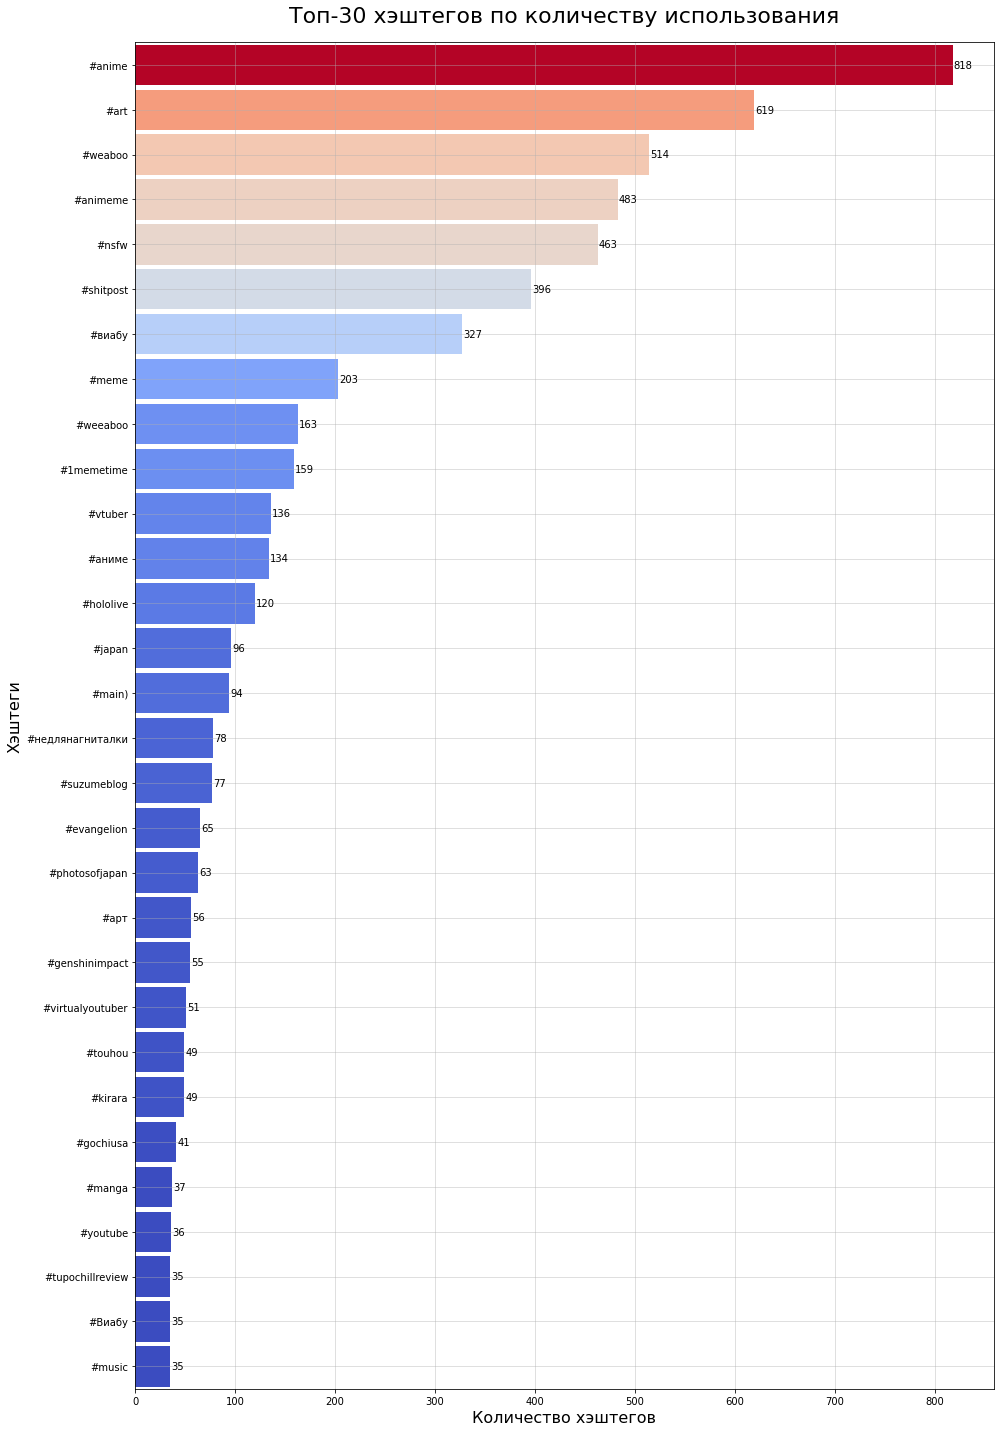

In [50]:
plt.rcParams["figure.figsize"] = [14, 20]

my_cmap = plt.get_cmap("coolwarm")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

labels = hshtgs.value_counts().head(30).index[::-1]
values = hshtgs.value_counts().head(30).values[::-1]

height = 0.9
plt.barh(y=labels, width=values, height=height, 
         color=my_cmap(rescale(values)), 
         align='center')

for i, (label, value) in enumerate(zip(labels, values)):
#     im = Image.open(requests.get(label, stream=True).raw)
#     plt.imshow(im, extent=[value - 200, value - 20, i - height / 2.5, i + height / 2.5], aspect='auto', zorder=2)
    plt.text(value + 1, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')

    
plt.xlim(0, max(values) * 1.05)
plt.ylim(-0.5, len(labels) - 0.5)
plt.xlabel('Количество хэштегов', fontsize=16)
plt.ylabel('Хэштеги', fontsize=16)
plt.title('Топ-30 хэштегов по количеству использования', fontsize=22, pad=20)
plt.grid(True, alpha=0.5)
plt.tight_layout()

# plt.savefig(PATH + "Full_analysis/hashtags.jpg", dpi=300, bbox_inches='tight')

plt.show()

### Дни недели

In [51]:
df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index)

In [52]:
df["hour"] = df.index.hour
df["month"] = df.index.month
df["weekday"] = df.index.day_name() #.weekday
df['is_weekend'] = df.weekday.isin(['Saturday',  'Sunday'])*1

In [53]:
df.head()

,id,url,author,comments_count,favorites_count,hits_count,is_repost,likes,subsite,title,...,images,videos,links,audio,total_mediacontent,hashtags,hour,month,weekday,is_weekend
date,,,,,,,,,,,,,,,,,,,,,
2021-04-02 10:56:55,690121,https://dtf.ru/s/weaboo/690121-itogi-mesyaca-mart,"{'id': 130392, 'url': 'https://dtf.ru/u/130392...",59,13,599,False,62,Виабу,Итоги месяца. Март,...,8,0,8,0,16,"[#), #weeabo, #anime, #weeaboomonthlytop, #виа...",10,4,Friday,0
2021-04-02 21:58:03,691434,https://dtf.ru/s/weaboo/691434,"{'id': 46404, 'url': 'https://dtf.ru/u/46404-o...",4,1,70,False,9,Виабу,NaN,...,1,0,0,0,1,"[#meme, #виабу]",21,4,Friday,0
2021-04-02 20:32:43,691350,https://dtf.ru/s/weaboo/691350,"{'id': 120739, 'url': 'https://dtf.ru/u/120739...",4,4,85,False,17,Виабу,NaN,...,3,0,0,0,3,[],20,4,Friday,0
2021-04-02 19:27:04,688125,https://dtf.ru/s/weaboo/688125-evangelion-podb...,"{'id': 165653, 'url': 'https://dtf.ru/u/165653...",5,9,88,False,23,Виабу,Евангелион: подборка артов,...,16,0,0,0,16,"[#подборка, #anime, #nsfw]",19,4,Friday,0
2021-04-02 18:50:34,691229,https://dtf.ru/u/195405-oleg-mattewho/691229-p...,"{'id': 195405, 'url': 'https://dtf.ru/u/195405...",6,11,177,True,37,Oleg Mattewho,Пятница в честь Курису Макисе,...,14,0,0,0,14,"[#mattewhoart, #sfw, #steinsgate]",18,4,Friday,0


In [54]:
df.sort_index(inplace=True)

In [55]:
df.head(15)

,id,url,author,comments_count,favorites_count,hits_count,is_repost,likes,subsite,title,...,images,videos,links,audio,total_mediacontent,hashtags,hour,month,weekday,is_weekend
date,,,,,,,,,,,,,,,,,,,,,
2018-03-12 21:59:15,17110,https://dtf.ru/flood/17110-ne-odin-lish-tip-luny,"{'id': 4876, 'url': 'https://dtf.ru/u/4876-geo...",19,32,1969,True,36,Офтоп,Не один лишь тип луны,...,42,3,0,0,45,[#long],21,3,Monday,0
2020-01-26 20:38:21,97215,https://dtf.ru/u/92907-aleksey-fedorov/97215-t...,"{'id': 92907, 'url': 'https://dtf.ru/u/92907-a...",11,47,659,True,56,Алексей Фёдоров,Тяночки в наших реалиях,...,17,0,0,0,17,[#anime],20,1,Sunday,1
2020-02-18 19:11:46,104163,https://dtf.ru/u/92907-aleksey-fedorov/104163-...,"{'id': 92907, 'url': 'https://dtf.ru/u/92907-a...",39,23,744,True,49,Алексей Фёдоров,Евангелион навсегда: Аска,...,32,0,0,0,32,"[#anime, #evangelion]",19,2,Tuesday,0
2020-02-29 18:25:10,108055,https://dtf.ru/u/92907-aleksey-fedorov/108055-...,"{'id': 92907, 'url': 'https://dtf.ru/u/92907-a...",7,18,236,True,41,Алексей Фёдоров,Милодевье в цветах неона,...,19,0,1,0,20,[#anime],18,2,Saturday,1
2020-03-16 10:36:03,113363,https://dtf.ru/u/4810-oleg-kubaneishvili/11336...,"{'id': 4810, 'url': 'https://dtf.ru/u/4810-ole...",5,8,180,True,15,Олег Кубанеишвили,Мнение о сериале Violet Evergarden,...,17,0,0,0,17,[],10,3,Monday,0
2020-06-22 12:06:01,155471,https://dtf.ru/anime/155471-obeshchannyy-never...,"{'id': 166371, 'url': 'https://dtf.ru/u/166371...",45,33,3952,True,16,Аниме,Обещанный Неверленд круто,...,5,0,0,0,5,"[#глед\_смотрит, #глед\_читает, #promisednever...",12,6,Monday,0
2020-07-13 12:44:35,169901,https://dtf.ru/u/92674-ayan-myrzagali/169901-m...,"{'id': 92674, 'url': 'https://dtf.ru/u/92674-a...",5,6,155,True,27,Ayan Myrzagali,Mariya Takeuchi — Sweetest Music,...,1,1,0,0,2,"[#music, #jpop, #mariyatakeuchi]",12,7,Monday,0
2020-07-14 20:10:03,170920,https://dtf.ru/s/weaboo/170920-nu-che-pacany-a...,"{'id': 212847, 'url': 'https://dtf.ru/u/212847...",42,4,1400,False,64,Виабу,"Ну че пацаны, аниме?",...,1,0,0,0,1,[],20,7,Tuesday,0
2020-07-14 20:49:12,170948,https://dtf.ru/s/weaboo/170948,"{'id': 92674, 'url': 'https://dtf.ru/u/92674-a...",6,1,160,False,24,Виабу,NaN,...,1,0,0,0,1,[],20,7,Tuesday,0


In [56]:
subset_posts = df.resample('D').apply({'id':'count'})

In [57]:
subset_posts = subset_posts[subset_posts.index > '2020-07-14']

In [58]:
subset_posts.head()

,id
date,
2020-07-15,55
2020-07-16,46
2020-07-17,39
2020-07-18,28
2020-07-19,44


In [59]:
sns.set_theme()

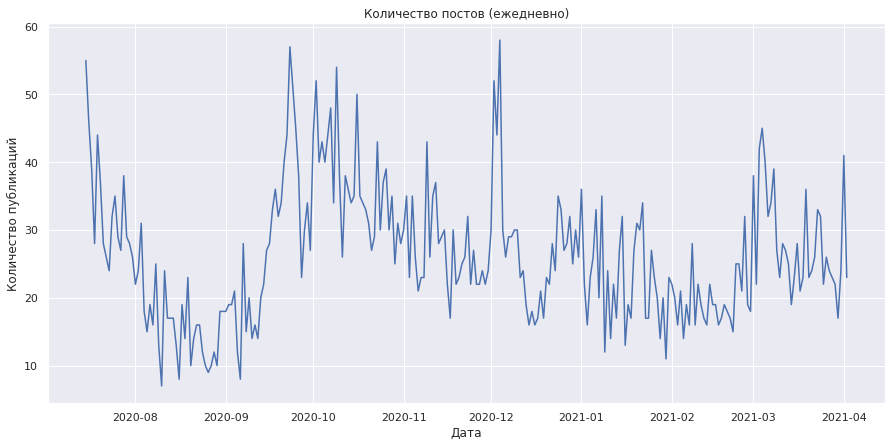

In [60]:
plt.figure(figsize=(15, 7))
sns.lineplot(data=subset_posts, x=subset_posts.index, y=subset_posts.id)
plt.title('Количество постов (ежедневно)')
plt.ylabel('Количество публикаций')
plt.xlabel('Дата')
plt.grid(True)
# plt.savefig(PATH + "Full_analysis/posts_by_day_din.jpg", dpi=300, bbox_inches='tight')

In [62]:
subset_com = df.resample('D').apply({'comments_count':'sum'})
subset_com = subset_com[subset_com.index > '2020-07-14']

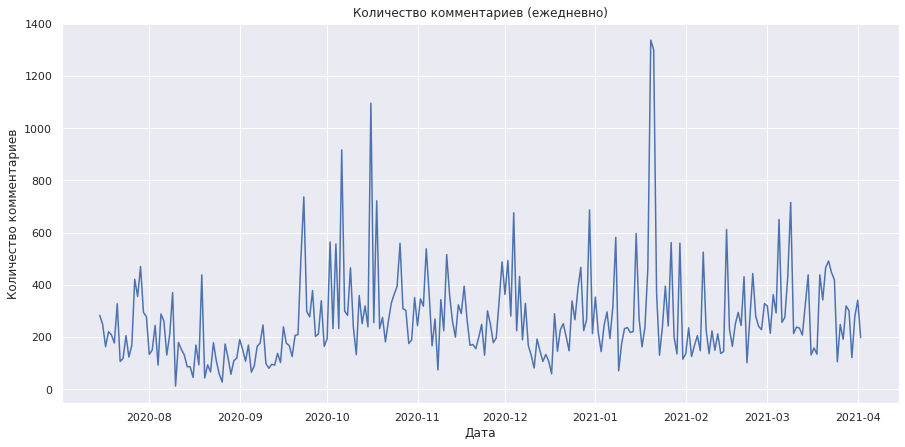

In [63]:
plt.figure(figsize=(15, 7))
sns.lineplot(data=subset_com, x=subset_com.index, y=subset_com.comments_count)
plt.title('Количество комментариев (ежедневно)')
plt.ylabel('Количество комментариев')
plt.xlabel('Дата')
plt.grid(True)
# plt.savefig(PATH + "Full_analysis/comments_by_day_din.jpg", dpi=300, bbox_inches='tight')

https://stackoverflow.com/questions/42473304/how-do-i-group-rows-by-month-in-a-pandas-dataframe

In [64]:
df['period'] = df.index.to_period('M')

<AxesSubplot:xlabel='period', ylabel='hits_count'>

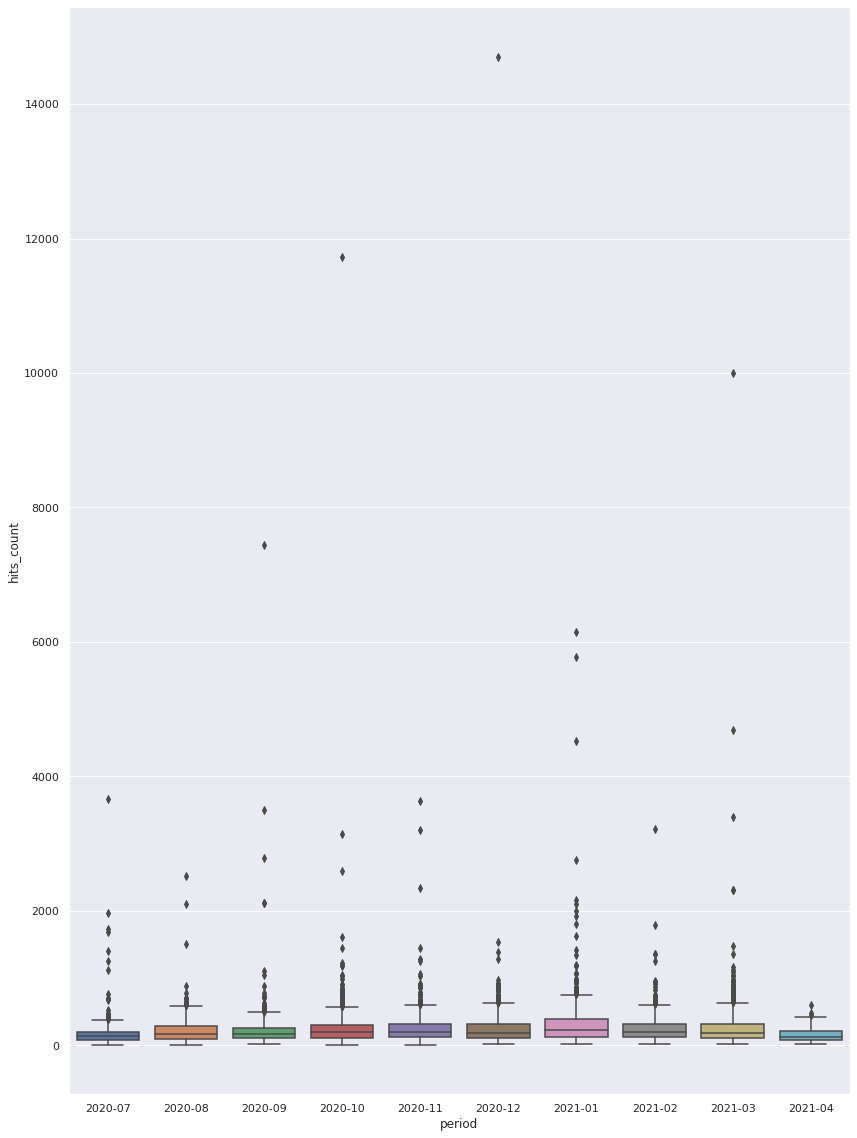

In [65]:
sns.boxplot(data=df[df.is_repost == False], x = 'period', y='hits_count')

### Немного поиграем с временными рядами

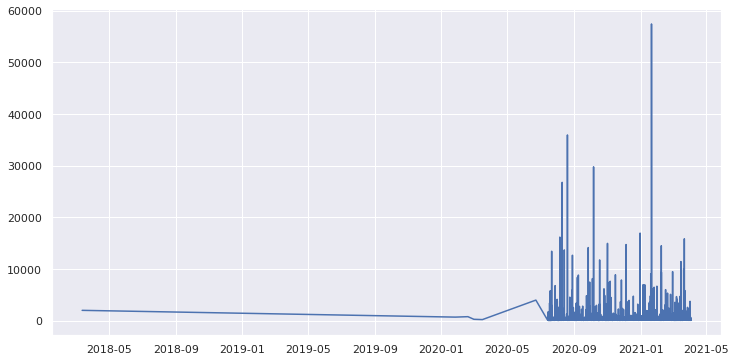

In [66]:
plt.figure(figsize=(12, 6))
plt.plot(df.hits_count)
plt.grid(True)
plt.show()

In [67]:
df.groupby(['weekday'])['id'].count().values

array([1124,  993,  867,  877, 1025,  944, 1070])

In [68]:
df.weekday.value_counts().values

array([1124, 1070, 1025,  993,  944,  877,  867])

In [69]:
df.weekday.value_counts().sort_index()

Friday       1124
Monday        993
Saturday      867
Sunday        877
Thursday     1025
Tuesday       944
Wednesday    1070
Name: weekday, dtype: int64

In [70]:
df.groupby(['weekday']).count()

,id,url,author,comments_count,favorites_count,hits_count,is_repost,likes,subsite,title,...,images,videos,links,audio,total_mediacontent,hashtags,hour,month,is_weekend,period
weekday,,,,,,,,,,,,,,,,,,,,,
Friday,1124,1124,1124,1124,1124,1124,1124,1124,1124,596,...,1124,1124,1124,1124,1124,1124,1124,1124,1124,1124
Monday,993,993,993,993,993,993,993,993,993,523,...,993,993,993,993,993,993,993,993,993,993
Saturday,867,867,867,867,867,867,867,867,867,424,...,867,867,867,867,867,867,867,867,867,867
Sunday,877,877,877,877,877,877,877,877,877,417,...,877,877,877,877,877,877,877,877,877,877
Thursday,1025,1025,1025,1025,1025,1025,1025,1025,1025,522,...,1025,1025,1025,1025,1025,1025,1025,1025,1025,1025
Tuesday,944,944,944,944,944,944,944,944,944,506,...,944,944,944,944,944,944,944,944,944,944
Wednesday,1070,1070,1070,1070,1070,1070,1070,1070,1070,528,...,1070,1070,1070,1070,1070,1070,1070,1070,1070,1070


In [ ]:
# sns.barplot(x=df.weekday.value_counts().index, y=df.groupby(['weekday'])['id'].count().values)

https://stackoverflow.com/questions/16180946/drawing-average-line-in-histogram-matplotlib

In [71]:
df.groupby("weekday")["id"].count().mean()

985.7142857142857

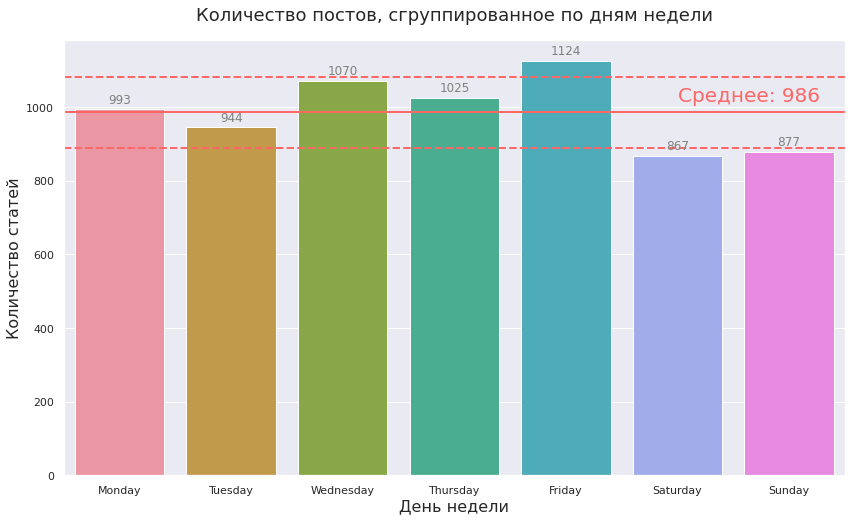

In [72]:
from pandas.api.types import CategoricalDtype

plt.figure(figsize=(14, 8))

cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cat_type = CategoricalDtype(categories=cats, ordered=True)
df['weekday'] = df['weekday'].astype(cat_type)

sns.set_palette('hls')

ax = sns.barplot(data=df, x=df.groupby("weekday")["id"].count().sort_index().index, 
            y=df.groupby("weekday")["id"].count().sort_index().values)



for p in ax.patches:
    ax.annotate("%.1d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='gray', xytext=(0, 10),
                 textcoords='offset points')  

plt.axhline(df.groupby("weekday")["id"].count().mean(), color='#ff6666', linestyle='-', linewidth=2)    
plt.text(5.0, df.groupby("weekday")["id"].count().mean()*1.03, 
         'Среднее: {:.0f}'.format(df.groupby("weekday")["id"].count().mean()), color='#ff6666', fontsize=20)
plt.axhline(df.groupby("weekday")["id"].count().mean() + df.groupby("weekday")["id"].count().std(), 
            color='#ff6666', linestyle='--', linewidth=2)
plt.axhline(df.groupby("weekday")["id"].count().mean() - df.groupby("weekday")["id"].count().std(), 
            color='#ff6666', linestyle='--', linewidth=2)
        
ax.set_title('Количество постов, сгруппированное по дням недели', fontsize=18, pad=20)
ax.set_xlabel('День недели', fontsize='16')
ax.set_ylabel('Количество статей', fontsize='16');

# plt.savefig(PATH + "Full_analysis/posts_by_day_sum.jpg", dpi=300, bbox_inches='tight')

### Возвращаемся к EDA

In [73]:
df.reset_index(inplace=True)
df.head()

,date,id,url,author,comments_count,favorites_count,hits_count,is_repost,likes,subsite,...,videos,links,audio,total_mediacontent,hashtags,hour,month,weekday,is_weekend,period
0,2018-03-12 21:59:15,17110,https://dtf.ru/flood/17110-ne-odin-lish-tip-luny,"{'id': 4876, 'url': 'https://dtf.ru/u/4876-geo...",19,32,1969,True,36,Офтоп,...,3,0,0,45,[#long],21,3,Monday,0,2018-03
1,2020-01-26 20:38:21,97215,https://dtf.ru/u/92907-aleksey-fedorov/97215-t...,"{'id': 92907, 'url': 'https://dtf.ru/u/92907-a...",11,47,659,True,56,Алексей Фёдоров,...,0,0,0,17,[#anime],20,1,Sunday,1,2020-01
2,2020-02-18 19:11:46,104163,https://dtf.ru/u/92907-aleksey-fedorov/104163-...,"{'id': 92907, 'url': 'https://dtf.ru/u/92907-a...",39,23,744,True,49,Алексей Фёдоров,...,0,0,0,32,"[#anime, #evangelion]",19,2,Tuesday,0,2020-02
3,2020-02-29 18:25:10,108055,https://dtf.ru/u/92907-aleksey-fedorov/108055-...,"{'id': 92907, 'url': 'https://dtf.ru/u/92907-a...",7,18,236,True,41,Алексей Фёдоров,...,0,1,0,20,[#anime],18,2,Saturday,1,2020-02
4,2020-03-16 10:36:03,113363,https://dtf.ru/u/4810-oleg-kubaneishvili/11336...,"{'id': 4810, 'url': 'https://dtf.ru/u/4810-ole...",5,8,180,True,15,Олег Кубанеишвили,...,0,0,0,17,[],10,3,Monday,0,2020-03


In [74]:
df.shape

(6900, 32)

In [80]:
df[df.author_type == 3]

,date,id,url,author,comments_count,favorites_count,hits_count,is_repost,likes,subsite,...,videos,links,audio,total_mediacontent,hashtags,hour,month,weekday,is_weekend,period
6255,2021-03-08 21:37:07,665947,https://dtf.ru/anime/665947-mangaki-scenaristk...,"{'id': 256351, 'url': 'https://dtf.ru/crunchyr...",90,221,4109,True,207,Аниме,...,0,0,0,21,"[#лонгрид, #аниме, #манга, #индустрия]",21,3,Monday,0,2021-03


In [81]:
df.loc[df[(df.author_type == 3)].index, 'author_type'] = 2

In [75]:
df.groupby(['is_repost']).agg({'id': "count"})

,id
is_repost,
False,6099
True,801


In [76]:
df.groupby(['is_repost']).agg({'id': "count"})['id']

is_repost
False    6099
True      801
Name: id, dtype: int64

In [82]:
tmp = df.groupby(['is_repost', 'author_type'], as_index=False).agg({'id': "count"})
tmp

,is_repost,author_type,id
0,False,1,6005
1,False,2,94
2,True,1,793
3,True,2,8


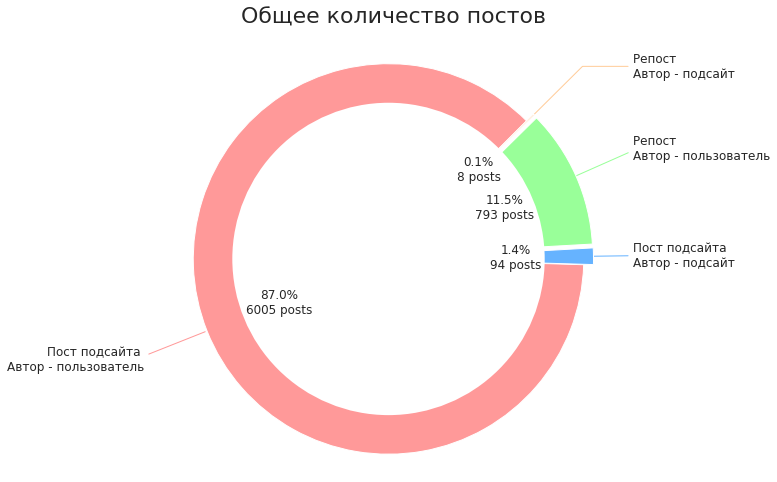

In [84]:
from matplotlib import gridspec

def func(pct, allvals):
    absolute = round(pct/100.*np.sum(allvals))
    return "{:.1f}%\n{:d} posts".format(pct, absolute)

fig=plt.figure(figsize=(14,10))
gs1 = gridspec.GridSpec(1,1,
    left=0.1,right=0.7,
    bottom=0.1,top=0.7,
)
# gs2 = gridspec.GridSpec(1,1,
#     left=0.05,right=0.95,
#     bottom=0.9,top=1.0,
# )

pie_ax=fig.add_subplot(gs1[0])
# title_ax=fig.add_subplot(gs2[0])

# Create a list of colors (from iWantHue)
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
labels = ['Пост подсайта \nАвтор - пользователь', 'Пост подсайта \nАвтор - подсайт', 
          'Репост \nАвтор - пользователь', 'Репост \nАвтор - подсайт']# tmp.author_type.values  

# Create a pie chart
wedges = pie_ax.pie(
    tmp['id'],
    shadow=False,
    colors=colors, 
    startangle=45, #frame=True, 
    autopct=lambda pct: func(pct, tmp['id']), 
    explode=(0, 0.05, 0.05, 0.05)
)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"), zorder=0, va="center")

for i, p in enumerate(wedges[0]):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle,
                             "color":colors[i]
#                              "color":'b'
                            })
    pie_ax.annotate(labels[i], xy=(x, y), xytext=(1.25*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)


centre_circle = plt.Circle((0,0), 0.8, color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Общее количество постов', fontsize=22, pad=20)

plt.axis('equal')

# plt.savefig(PATH + "Full_analysis/posts.jpg", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# sns.set_theme()
# sns.set_palette("husl")

# labels = 'Статья подсайта', 'Репост'
# sizes = df.groupby(['isRepost']).agg({'id': "count"})['id'].values
# explode = (0, 0.1)  

# fig1, ax1 = plt.subplots()
# ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
#         shadow=True, startangle=90)

# ax1.axis('equal')  
# plt.show()

In [85]:
sns.set_theme()

In [86]:
tmp = df.groupby(['is_repost', 'author_type'], as_index=False).agg({'comments_count': "sum"})
tmp

,is_repost,author_type,comments_count
0,False,1,45982
1,False,2,1075
2,True,1,23256
3,True,2,447


In [87]:
sns.set_palette("tab10")

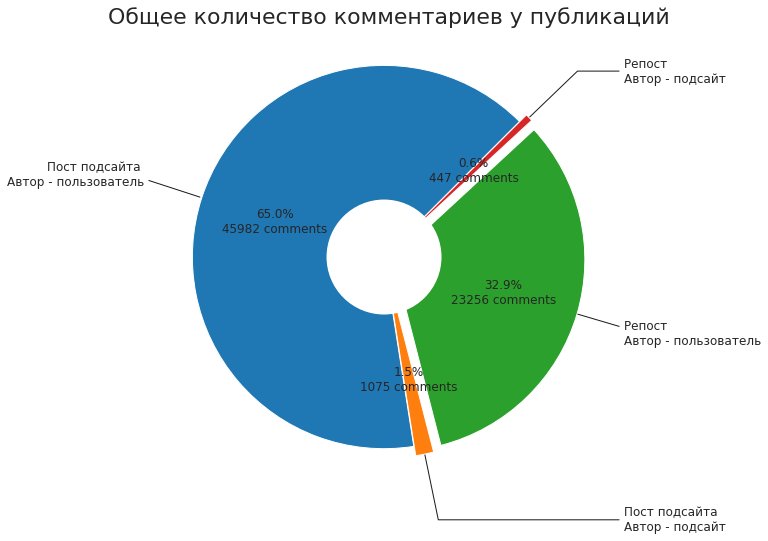

In [88]:
from matplotlib import gridspec

def func(pct, allvals):
    absolute = round(pct/100.*np.sum(allvals))
    return "{:.1f}%\n{:d} comments".format(pct, absolute)

fig=plt.figure(figsize=(14,10))
gs1 = gridspec.GridSpec(1,1,
    left=0.1,right=0.7,
    bottom=0.1,top=0.7,
)
# gs2 = gridspec.GridSpec(1,1,
#     left=0.05,right=0.95,
#     bottom=0.9,top=1.0,
# )

pie_ax=fig.add_subplot(gs1[0])
# title_ax=fig.add_subplot(gs2[0])

# Create a list of colors (from iWantHue)
# colors = ['#66b3ff', '#ffcc99', '#99ff99', '#ff6666']
labels = ['Пост подсайта \nАвтор - пользователь', 'Пост подсайта \nАвтор - подсайт', 
          'Репост \nАвтор - пользователь', 'Репост \nАвтор - подсайт']# tmp.author_type.values  

# Create a pie chart
wedges = pie_ax.pie(
    tmp['comments_count'],
    shadow=False,
#     colors=colors, 
    startangle=45, #frame=True, 
    autopct=lambda pct: func(pct, tmp['comments_count']), 
    explode=(0, 0.05, 0.05, 0.05)
)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"), zorder=0, va="center")

for i, p in enumerate(wedges[0]):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle,
#                              "color":colors[i]
                            "color":'k'
                            })
    pie_ax.annotate(labels[i], xy=(x, y), xytext=(1.25*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)


centre_circle = plt.Circle((0,0), 0.3, color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Общее количество комментариев у публикаций', fontsize=22, pad=20)

plt.axis('equal')

# plt.savefig(PATH + "Full_analysis/posts.jpg", dpi=300, bbox_inches='tight')

plt.show()

In [89]:
tmp = df.groupby(['is_repost'], as_index=False).agg({'hits_count': "sum"})
tmp

,is_repost,hits_count
0,False,1527258
1,True,953700


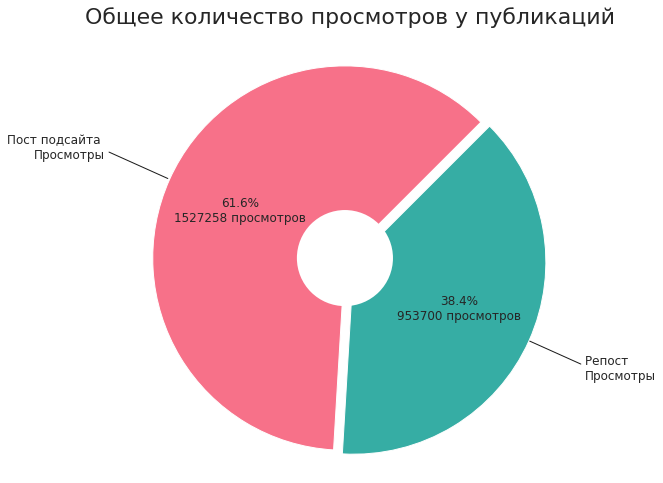

In [90]:
sns.set_palette("husl", 2)

def func(pct, allvals):
    absolute = round(pct/100.*np.sum(allvals))
    return "{:.1f}%\n{:d} просмотров".format(pct, absolute)

fig=plt.figure(figsize=(14,10))
gs1 = gridspec.GridSpec(1,1,
    left=0.1,right=0.7,
    bottom=0.1,top=0.7,
)
# gs2 = gridspec.GridSpec(1,1,
#     left=0.05,right=0.95,
#     bottom=0.9,top=1.0,
# )

pie_ax=fig.add_subplot(gs1[0])
# title_ax=fig.add_subplot(gs2[0])

# Create a list of colors (from iWantHue)
# colors = ['#66b3ff', '#ffcc99', '#99ff99', '#ff6666']
labels = ['Пост подсайта \nПросмотры',  
          'Репост \nПросмотры', ]

# Create a pie chart
wedges = pie_ax.pie(
    tmp['hits_count'],
    shadow=False,
#     colors=colors, 
    startangle=45, #frame=True, 
    autopct=lambda pct: func(pct, tmp['hits_count']), 
    explode=(0, 0.05)
)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"), zorder=0, va="center")

for i, p in enumerate(wedges[0]):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle,
#                              "color":colors[i]
                            "color":'k'
                            })
    pie_ax.annotate(labels[i], xy=(x, y), xytext=(1.25*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)


centre_circle = plt.Circle((0,0), 0.25, color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Общее количество просмотров у публикаций', fontsize=22, pad=20)

plt.axis('equal')

# plt.savefig(PATH + "Full_analysis/hits.jpg", dpi=300, bbox_inches='tight')

plt.show()

In [91]:
tmp = df.groupby(['is_repost'], as_index=False).agg({'favorites_count': "sum"})
tmp

,is_repost,favorites_count
0,False,45992
1,True,21775


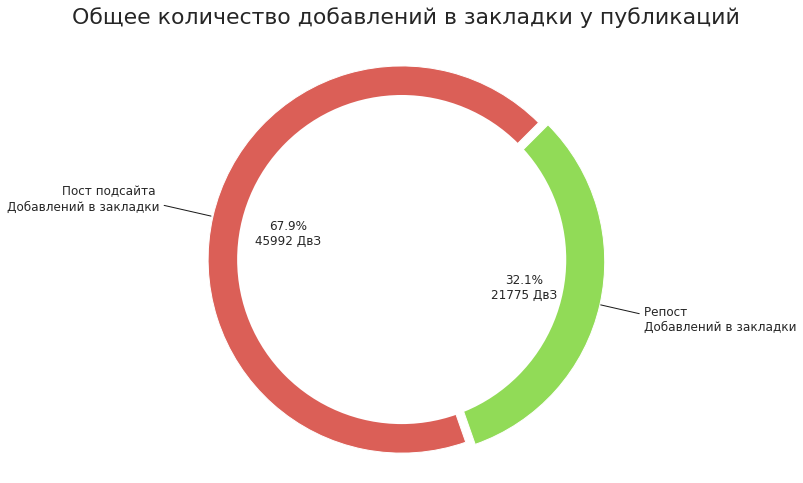

In [92]:
sns.set_palette("hls", 4)

def func(pct, allvals):
    absolute = round(pct/100.*np.sum(allvals))
    return "{:.1f}%\n{:d} ДвЗ".format(pct, absolute)

fig=plt.figure(figsize=(14,10))
gs1 = gridspec.GridSpec(1,1,
    left=0.1,right=0.7,
    bottom=0.1,top=0.7,
)
# gs2 = gridspec.GridSpec(1,1,
#     left=0.05,right=0.95,
#     bottom=0.9,top=1.0,
# )

pie_ax=fig.add_subplot(gs1[0])
# title_ax=fig.add_subplot(gs2[0])

# Create a list of colors (from iWantHue)
# colors = ['#66b3ff', '#ffcc99', '#99ff99', '#ff6666']
labels = ['Пост подсайта \nДобавлений в закладки',  
          'Репост \nДобавлений в закладки', ]

# Create a pie chart
wedges = pie_ax.pie(
    tmp['favorites_count'],
    shadow=False,
#     colors=colors, 
    startangle=45, #frame=True, 
    autopct=lambda pct: func(pct, tmp['favorites_count']), 
    explode=(0, 0.05)
)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"), zorder=0, va="center")

for i, p in enumerate(wedges[0]):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle,
#                              "color":colors[i]
                            "color":'k'
                            })
    pie_ax.annotate(labels[i], xy=(x, y), xytext=(1.25*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)


centre_circle = plt.Circle((0,0), 0.85, color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Общее количество добавлений в закладки у публикаций', fontsize=22, pad=20)

plt.axis('equal')

# plt.savefig(PATH + "Full_analysis/favs.jpg", dpi=300, bbox_inches='tight')

plt.show()

In [93]:
tmp = df.groupby(['is_repost', 'author_type'], as_index=False).agg({'likes': "sum"})
tmp

,is_repost,author_type,likes
0,False,1,167046
1,False,2,2001
2,True,1,39732
3,True,2,708


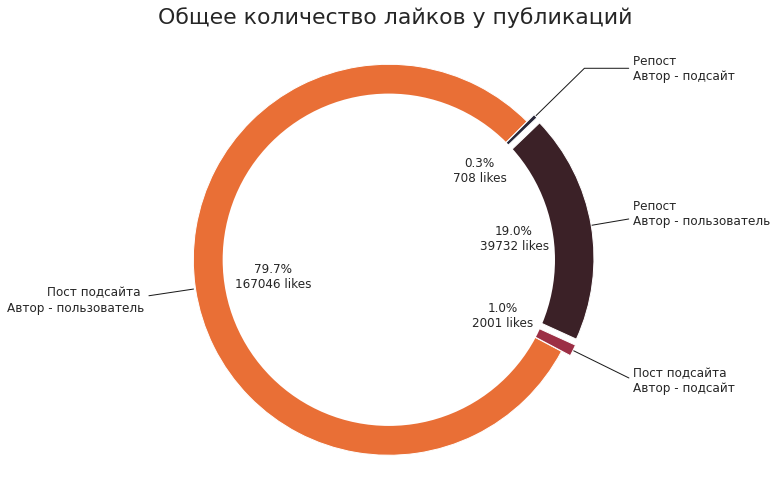

In [94]:
sns.set_palette("icefire_r")

def func(pct, allvals):
    absolute = round(pct/100.*np.sum(allvals))
    return "{:.1f}%\n{:d} likes".format(pct, absolute)

fig=plt.figure(figsize=(14,10))
gs1 = gridspec.GridSpec(1,1,
    left=0.1,right=0.7,
    bottom=0.1,top=0.7,
)
# gs2 = gridspec.GridSpec(1,1,
#     left=0.05,right=0.95,
#     bottom=0.9,top=1.0,
# )

pie_ax=fig.add_subplot(gs1[0])
# title_ax=fig.add_subplot(gs2[0])

# Create a list of colors (from iWantHue)
# colors = ['#66b3ff', '#ffcc99', '#99ff99', '#ff6666']
labels = ['Пост подсайта \nАвтор - пользователь', 'Пост подсайта \nАвтор - подсайт', 
          'Репост \nАвтор - пользователь', 'Репост \nАвтор - подсайт']# tmp.author_type.values  

# Create a pie chart
wedges = pie_ax.pie(
    tmp['likes'],
    shadow=False,
#     colors=colors, 
    startangle=45, #frame=True, 
    autopct=lambda pct: func(pct, tmp['likes']), 
    explode=(0, 0.05, 0.05, 0.05)
)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"), zorder=0, va="center")

for i, p in enumerate(wedges[0]):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle,
#                              "color":colors[i]
                            "color":'k'
                            })
    pie_ax.annotate(labels[i], xy=(x, y), xytext=(1.25*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)


centre_circle = plt.Circle((0,0), 0.85, color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Общее количество лайков у публикаций', fontsize=22, pad=20)

plt.axis('equal')

# plt.savefig(PATH + "Full_analysis/likes.jpg", dpi=300, bbox_inches='tight')

plt.show()

In [95]:
tmp_symbols = df.groupby(['is_repost', 'author_type'], as_index=False).agg({'symbols': "sum"})
tmp_symbols

,is_repost,author_type,symbols
0,False,1,983176
1,False,2,27389
2,True,1,1707723
3,True,2,28312


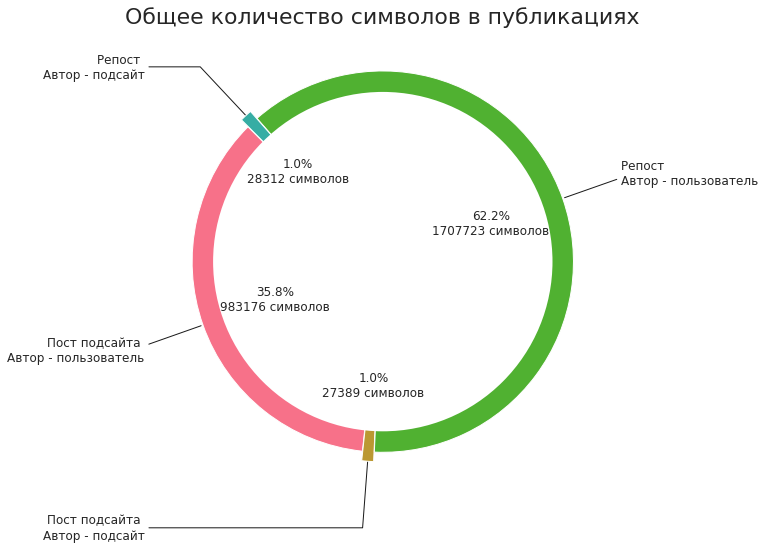

In [96]:
sns.set_palette("husl")

def func(pct, allvals):
    absolute = round(pct/100.*np.sum(allvals))
    return "{:.1f}%\n{:d} символов".format(pct, absolute)

fig=plt.figure(figsize=(14,10))
gs1 = gridspec.GridSpec(1,1,
    left=0.1,right=0.7,
    bottom=0.1,top=0.7,
)
# gs2 = gridspec.GridSpec(1,1,
#     left=0.05,right=0.95,
#     bottom=0.9,top=1.0,
# )

pie_ax=fig.add_subplot(gs1[0])
# title_ax=fig.add_subplot(gs2[0])

# Create a list of colors (from iWantHue)
# colors = ['#66b3ff', '#ffcc99', '#99ff99', '#ff6666']
labels = ['Пост подсайта \nАвтор - пользователь', 'Пост подсайта \nАвтор - подсайт', 
          'Репост \nАвтор - пользователь', 'Репост \nАвтор - подсайт']# tmp.author_type.values  

# Create a pie chart
wedges = pie_ax.pie(
    tmp_symbols['symbols'],
    shadow=False,
#     colors=colors, 
    startangle=135, #frame=True, 
    autopct=lambda pct: func(pct, tmp_symbols['symbols']), 
    explode=(0, 0.05, 0, 0.05)
)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"), zorder=0, va="center")

for i, p in enumerate(wedges[0]):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle,
#                              "color":colors[i]
                            "color":'k'
                            })
    pie_ax.annotate(labels[i], xy=(x, y), xytext=(1.25*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)


centre_circle = plt.Circle((0,0), 0.89, color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Общее количество символов в публикациях', fontsize=22, pad=26)

plt.axis('equal')

# plt.savefig(PATH + "Full_analysis/symbols.jpg", dpi=300, bbox_inches='tight')

plt.show()

In [97]:
tmp_media = df.groupby(['is_repost', 'author_type'], as_index=False).agg({'total_mediacontent': "sum"})
tmp_media

,is_repost,author_type,total_mediacontent
0,False,1,23233
1,False,2,164
2,True,1,10031
3,True,2,190


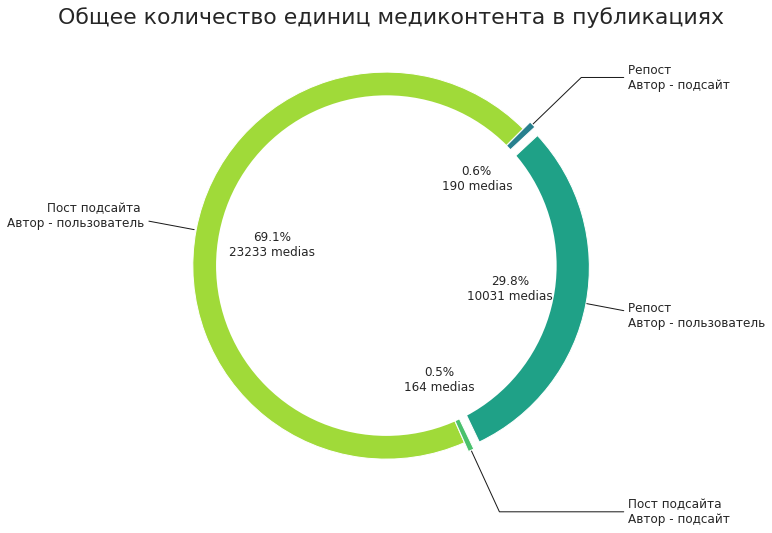

In [99]:
sns.set_palette("viridis_r")

def func(pct, allvals):
    absolute = round(pct/100.*np.sum(allvals))
    return "{:.1f}%\n{:d} medias".format(pct, absolute)

fig=plt.figure(figsize=(14,10))
gs1 = gridspec.GridSpec(1,1,
    left=0.1,right=0.7,
    bottom=0.1,top=0.7,
)
# gs2 = gridspec.GridSpec(1,1,
#     left=0.05,right=0.95,
#     bottom=0.9,top=1.0,
# )

pie_ax=fig.add_subplot(gs1[0])
# title_ax=fig.add_subplot(gs2[0])

# Create a list of colors (from iWantHue)
# colors = ['#66b3ff', '#ffcc99', '#99ff99', '#ff6666']
labels = ['Пост подсайта \nАвтор - пользователь', 'Пост подсайта \nАвтор - подсайт', 
          'Репост \nАвтор - пользователь', 'Репост \nАвтор - подсайт']# tmp.author_type.values  

# Create a pie chart
wedges = pie_ax.pie(
    tmp_media['total_mediacontent'],
    shadow=False,
#     colors=colors, 
    startangle=45, #frame=True, 
    autopct=lambda pct: func(pct, tmp_media['total_mediacontent']), 
    explode=(0, 0.05, 0.05, 0.05)
)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"), zorder=0, va="center")

for i, p in enumerate(wedges[0]):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle,
#                              "color":colors[i]
                            "color":'k'
                            })
    pie_ax.annotate(labels[i], xy=(x, y), xytext=(1.25*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)


centre_circle = plt.Circle((0,0), 0.88, color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Общее количество единиц медиконтента в публикациях', fontsize=22, pad=26)

plt.axis('equal')

# plt.savefig(PATH + "Full_analysis/medias.jpg", dpi=300, bbox_inches='tight')

plt.show()

In [100]:
print(len(df.author_name.unique()))
print(len(df[df.is_repost == False].author_name.unique()))
print(len(df[df.is_repost == True].author_name.unique()))

412
318
188


In [101]:
author_set_post = set(df[df.is_repost == False].author_name.unique())
author_set_repost = set(df[df.is_repost == True].author_name.unique())

#### Venn diagram

https://pypi.org/project/matplotlib-venn/
    
https://stackoverflow.com/questions/55622820/python-venn-diagram-actual-label

https://stackoverflow.com/questions/55717203/plot-actual-set-items-in-python-not-the-number-of-items/55718006#55718006

https://stackoverflow.com/questions/42855256/python-venn-diagram-how-to-show-the-diagram-contents

https://stackoverflow.com/questions/46224235/matplotlib-venn-diagram-with-legend

https://stackoverflow.com/questions/51052573/matplotlib-venn-changing-what-is-displayed-inside-the-venn-diagram

https://stackoverflow.com/questions/19841535/python-matplotlib-venn-diagram

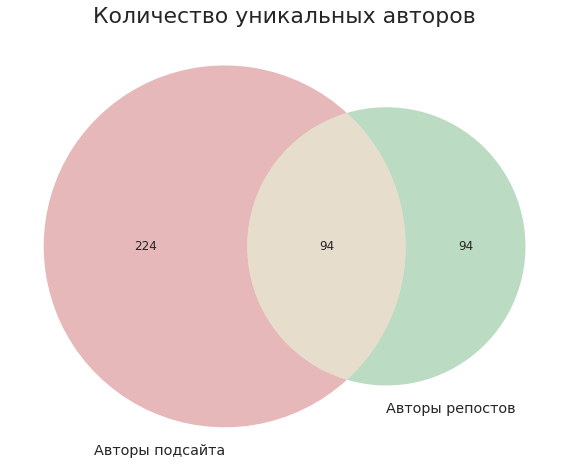

In [102]:
# Plotting Venn diagramm
from matplotlib_venn import venn2
plt.figure(figsize=(14,8))

venn = venn2([author_set_post, author_set_repost], ('Авторы подсайта', 'Авторы репостов'))

# venn.get_label_by_id('100').set_text('\n'.join(map(str, author_set_post-author_set_repost)))
# venn.get_label_by_id('110').set_text('\n'.join(map(str, author_set_post&author_set_repost)))
# venn.get_label_by_id('010').set_text('\n'.join(map(str, author_set_repost-author_set_post)))

plt.title('Количество уникальных авторов', fontsize=22)

# plt.savefig(PATH + "Full_analysis/authors_venn.jpg", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# feature_cols = ['comments_count', 'favorites_count', 'hits_count', 'likes', 'symbols', 'words', 
#                 'images', 'videos', 'links', 'audio', 'total_mediacontent']

In [ ]:
# fig, axs = plt.subplots(ncols = 3,nrows = 1, figsize = (36,8.5))
# for i,j in enumerate(feature_cols[0:3]):
#     df_sum = df.groupby([j],as_index = False).sum()
#     sns.barplot(x = j, y = "likes", ax = axs[i],
#                 data = df_sum,orient = "v", 
#                 order=df_sum.sort_values('likes', ascending = False)[j],
#                 palette = "mako")
# fig.suptitle("likes", fontsize=30)

# fig, axs = plt.subplots(ncols = 8,nrows = 1, figsize = (36,5))
# for i,j in enumerate(feature_cols[3:11]):
#     df_sum = df.groupby([j],as_index = False).sum()
#     sns.barplot(x = j, y = "likes", ax = axs[i],
#                 data = df_sum,orient = "v", 
#                 order=df_sum.sort_values('likes',ascending = False)[j],
#                 palette = "mako")

In [103]:
plt.rcParams["figure.figsize"] = [14, 10]
sns.set_theme()
sns.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [ ]:
# sns.scatterplot(x=df.symbols, size=df.likes, hue='is_repost', 
#                 y=sum([df.images, df.videos, df.links]), data=df)

# Разбираемся с построением столбчатых диаграмм

https://stackoverflow.com/questions/61971090/how-can-i-add-images-to-bars-in-axes-matplotlib

https://stackoverflow.com/questions/40066089/apply-images-to-pyplot-python-bar-graphs

# СУПЕР_ВАЖНО!

```python
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO

labels = ['CW', 'CV', 'GW', 'SX', 'DO']
colors = ['crimson', 'dodgerblue', 'teal', 'limegreen', 'gold']
values = 30 + np.random.randint(5, 20, len(labels)).cumsum()

height = 0.9
plt.barh(y=labels, width=values, height=height, color=colors, align='center')

for i, (label, value) in enumerate(zip(labels, values)):
    # load the image corresponding to label into img
    # with cbook.get_sample_data('ada.png') as image_file:
    #    img = plt.imread(image_file)
    response = requests.get(f'https://www.countryflags.io/{label}/flat/64.png')
    img = plt.imread(BytesIO(response.content))
    plt.imshow(img, extent=[value - 8, value - 2, i - height / 2, i + height / 2], aspect='auto', zorder=2)
plt.xlim(0, max(values) * 1.05)
plt.ylim(-0.5, len(labels) - 0.5)
plt.tight_layout()
plt.show()
```

# МЕГА-ВАЖНО!

https://stackoverflow.com/questions/61971090/how-can-i-add-images-to-bars-in-axes-matplotlib

https://stackoverflow.com/questions/7391945/how-do-i-read-image-data-from-a-url-in-python

In [ ]:
# Первый, неудачный вариант

# import requests
# from PIL import Image
# from io import BytesIO

# labels = tmp.index[:5]
# colors = ['tan', 'peru', 'grey', 'orchid', 'darkred']
# values = tmp.values.flatten()[:5]

# height = 0.9
# plt.barh(y=tmp.index[:5], width=tmp.values.flatten()[:5], height=height, color=colors, align='center')

# for i, (label, value) in enumerate(zip(labels, values)):
#     im = Image.open(requests.get(label, stream=True).raw)
#     plt.imshow(im, extent=[value - 150, value - 20, i - height / 2.5, i + height / 2.5], aspect='auto', zorder=2)
       
    
# plt.xlim(0, max(values) * 1.05)
# plt.ylim(-0.5, len(labels) - 0.5)
# plt.tight_layout()
# plt.show()

https://stackoverflow.com/questions/32059397/pandas-groupby-without-turning-grouped-by-column-into-index

### Tests

In [ ]:
# tmp_2 = df.groupby(['author_name','author_avatar_url'], as_index=False).count() \
# .sort_values(by="id", ascending=False).head(20).iloc[:, [0,1,3]]
# tmp_2

In [ ]:
# import requests
# from PIL import Image
# from io import BytesIO

# labels = tmp_2.author_avatar_url[:5][::-1]
# colors = ['peru', 'tan', 'grey', 'orchid', 'darkred'][::-1]
# values = tmp_2.id[:5][::-1] #.flatten()[:5]

# height = 0.9
# plt.barh(y=tmp_2.author_name[:5][::-1], width=tmp_2.id[:5][::-1], height=height, color=colors, align='center')

# for i, (label, value) in enumerate(zip(labels, values)):
#     im = Image.open(requests.get(label, stream=True).raw)
#     plt.imshow(im, extent=[value - 150, value - 20, i - height / 2.5, i + height / 2.5], aspect='auto', zorder=2)

# plt.style.use('seaborn')    
# plt.xlim(0, max(values) * 1.05)
# plt.ylim(-0.5, len(labels) - 0.5)
# plt.tight_layout()
# plt.show()

In [ ]:
# labels = tmp_2.author_avatar_url[:5][::-1]
# colors = ['peru', 'tan', 'grey', 'orchid', 'darkred'][::-1]
# values = tmp_2.id[:5][::-1] #.flatten()[:5]

# height = 0.9
# f = sns.barplot(y=tmp_2.author_name[:5][::-1], x=tmp_2.id[:5][::-1])
# ax = f

# for p in ax.patches:
#     width = p.get_width()    # get bar length
#     ax.text(width + 1,       # set the text at 1 unit right of the bar
#             p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
#             '{:1.0f}'.format(width), # set variable to display, 2 decimals
#             ha = 'left',   # horizontal alignment
#             va = 'center')  # vertical alignment

# # for i, (label, value) in enumerate(zip(labels, values)):
# #     im = Image.open(requests.get(label, stream=True).raw)
# #     plt.imshow(im, extent=[value - 150, value - 20, i - height / 2.5, i + height / 2.5], aspect='auto', zorder=2)
       
    
# # plt.xlim(0, max(values) * 1.05)
# # plt.ylim(-0.5, len(labels) - 0.5)
# # plt.tight_layout()
# # plt.show()

In [ ]:
# import requests
# from PIL import Image
# from io import BytesIO

# labels = tmp_2.author_avatar_url[:5][::-1]
# colors = ['peru', 'tan', 'grey', 'orchid', 'darkred'][::-1]
# values = tmp_2.id[:5][::-1] 

# height = 0.9
# plt.barh(y=tmp_2.author_name[:5][::-1], width=tmp_2.id[:5][::-1], height=height, color=colors, align='center')

# for i, (label, value) in enumerate(zip(labels, values)):
#     im = Image.open(requests.get(label, stream=True).raw)
#     plt.imshow(im, extent=[value - 150, value - 20, i - height / 2.5, i + height / 2.5], aspect='auto', zorder=2)
#     plt.text(value + 3, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')

    
# plt.xlim(0, max(values) * 1.05)
# plt.ylim(-0.5, len(labels) - 0.5)
# plt.tight_layout()
# plt.show()

https://stackoverflow.com/questions/49820549/labeling-horizontal-barplot-with-values-in-seaborn

https://stackoverflow.com/questions/45946970/displaying-of-values-on-barchart

### Tests end
# Конец тестовой зоны

# Смотрим на топы по различным признакам

In [104]:
tmp = df.groupby(['author_name'])['author_name'].count().sort_values(ascending=False).head(20)
tmp

author_name
Лолег                    827
Layben                   717
Гусь Хмурый              470
Suzume-sama              358
Diego Paw                324
Фанат Ани Тейлор-Джой    272
Just Chill               250
Pray for Megumin         246
Хасаги                   171
Koda                     129
mindtered                112
Oleg Mattewho             96
Виабу                     92
Анимемания                82
Алексей Кудрявцев         80
Saher                     77
Over9k5000                70
Marshal_New_Arleana       64
Revendi                   56
Shinji Matou              55
Name: author_name, dtype: int64

In [105]:
tmp_posts = df[df.is_repost == False].groupby(['author_name','author_avatar_url'], as_index=False) \
.agg({'id': 'count'}).sort_values(by='id', ascending=False).head(40)
tmp_posts_1 = tmp_posts.iloc[0:20]
tmp_posts_2 = tmp_posts.iloc[20:40]

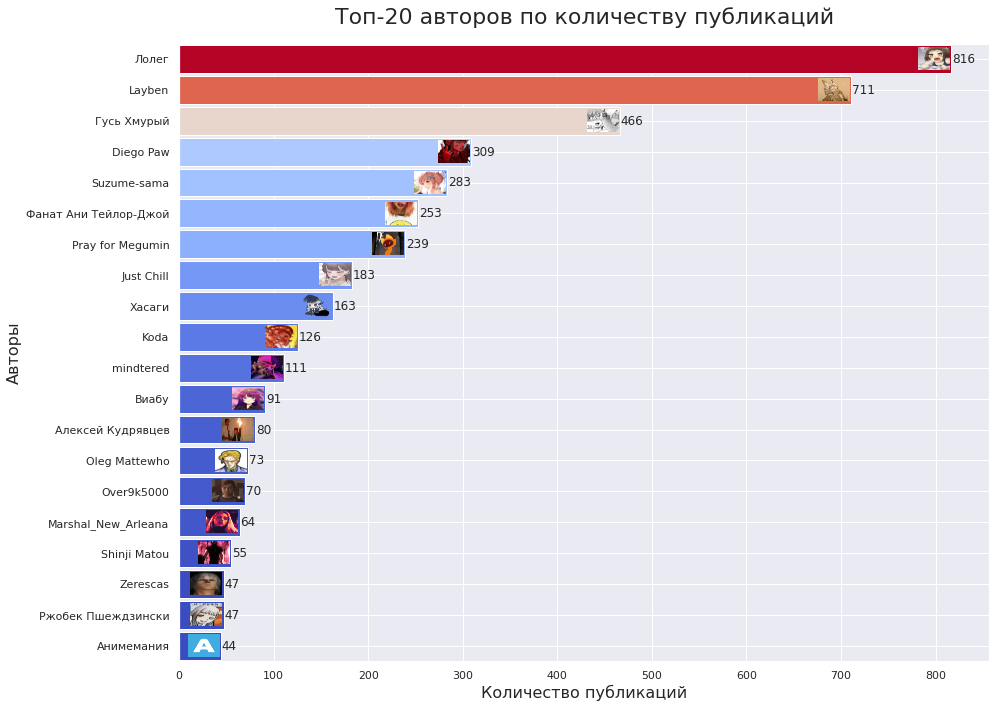

In [106]:
my_cmap = plt.get_cmap("coolwarm")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

labels = tmp_posts_1.author_avatar_url[::-1]
# colors = ['lightcoral', 'orchid', 'peachpuff', 'coral', 'tan', 'indigo', 'goldenrod', 'pink', 'darkturquoise', 'teal'][::-1]
values = tmp_posts_1.id[::-1] 

height = 0.9
plt.barh(y=tmp_posts_1.author_name[::-1], width=tmp_posts_1.id[::-1], height=height, 
         color=my_cmap(rescale(values)), 
         align='center')

for i, (label, value) in enumerate(zip(labels, values)):
    im = Image.open(requests.get(label, stream=True).raw)
    plt.imshow(im, extent=[value - 35, value - 2, i - height / 2.5, i + height / 2.5], aspect='auto', zorder=2)
    plt.text(value + 1, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')

    
plt.xlim(0, max(values) * 1.05)
plt.ylim(-0.5, len(labels) - 0.5)
plt.xlabel('Количество публикаций', fontsize=16)
plt.ylabel('Авторы', fontsize=16)
plt.title('Топ-20 авторов по количеству публикаций', fontsize=22, pad=20)
plt.tight_layout()

# plt.savefig(PATH + "Full_analysis/authors_posts_count_1.jpg", dpi=300, bbox_inches='tight')

plt.show()

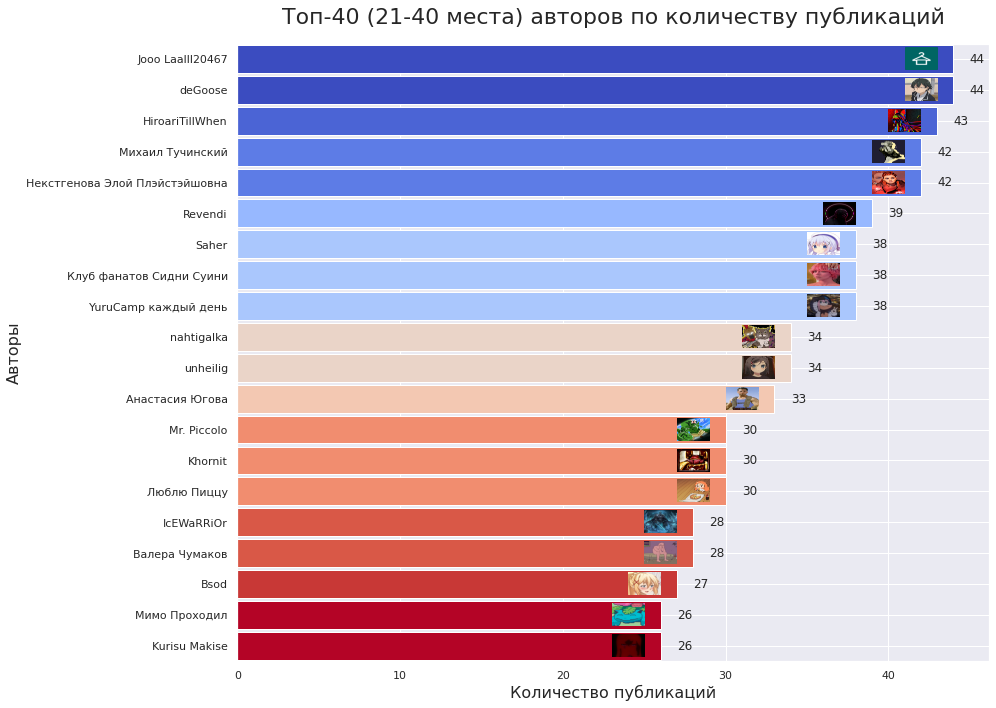

In [107]:
my_cmap = plt.get_cmap("coolwarm_r")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

labels = tmp_posts_2.author_avatar_url[::-1]
# colors = ['lightcoral', 'orchid', 'peachpuff', 'coral', 'tan', 'indigo', 'goldenrod', 'pink', 'darkturquoise', 'teal'][::-1]
values = tmp_posts_2.id[::-1] 

height = 0.9
plt.barh(y=tmp_posts_2.author_name[::-1], width=tmp_posts_2.id[::-1], height=height, 
         color=my_cmap(rescale(values)), 
         align='center')

for i, (label, value) in enumerate(zip(labels, values)):
    im = Image.open(requests.get(label, stream=True).raw)
    plt.imshow(im, extent=[value - 3, value - 1, i - height / 2.5, i + height / 2.5], aspect='auto', zorder=2)
    plt.text(value + 1, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')

    
plt.xlim(0, max(values) * 1.05)
plt.ylim(-0.5, len(labels) - 0.5)
plt.xlabel('Количество публикаций', fontsize=16)
plt.ylabel('Авторы', fontsize=16)
plt.title('Топ-40 (21-40 места) авторов по количеству публикаций', fontsize=22, pad=20)
plt.tight_layout()

# plt.savefig(PATH + "Full_analysis/authors_posts_count_2.jpg", dpi=300, bbox_inches='tight')

plt.show()

Reposts counts

In [108]:
tmp_posts_alter = df[df.is_repost == True].groupby(['author_name','author_avatar_url'], as_index=False) \
.agg({'id': 'count'}).sort_values(by='id', ascending=False).head(40)
tmp_posts_1 = tmp_posts_alter.iloc[0:20]

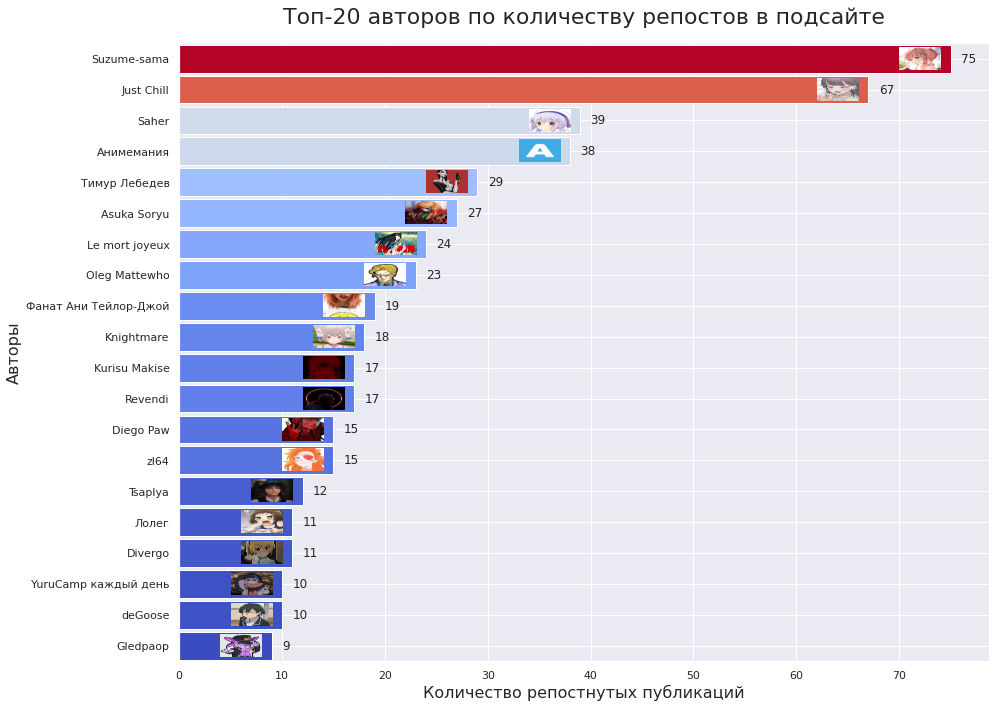

In [109]:
my_cmap = plt.get_cmap("coolwarm")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

labels = tmp_posts_1.author_avatar_url[::-1]
values = tmp_posts_1.id[::-1] 

height = 0.9
plt.barh(y=tmp_posts_1.author_name[::-1], width=tmp_posts_1.id[::-1], height=height, 
         color=my_cmap(rescale(values)), 
         align='center')

for i, (label, value) in enumerate(zip(labels, values)):
    im = Image.open(requests.get(label, stream=True).raw)
    plt.imshow(im, extent=[value - 5, value - 1, i - height / 2.5, i + height / 2.5], aspect='auto', zorder=2)
    plt.text(value + 1, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')

    
plt.xlim(0, max(values) * 1.05)
plt.ylim(-0.5, len(labels) - 0.5)
plt.xlabel('Количество репостнутых публикаций', fontsize=16)
plt.ylabel('Авторы', fontsize=16)
plt.title('Топ-20 авторов по количеству репостов в подсайте', fontsize=22, pad=20)
plt.tight_layout()

# plt.savefig(PATH + "Full_analysis/authors_posts_reposted.jpg", dpi=300, bbox_inches='tight')

plt.show()

In [110]:
df.columns

Index(['date', 'id', 'url', 'author', 'comments_count', 'favorites_count',
       'hits_count', 'is_repost', 'likes', 'subsite', 'title', 'type',
       'blocks', 'repost', 'stacked_reposts_authors', 'media_content_types',
       'author_name', 'author_type', 'author_avatar_url', 'symbols', 'words',
       'images', 'videos', 'links', 'audio', 'total_mediacontent', 'hashtags',
       'hour', 'month', 'weekday', 'is_weekend', 'period'],
      dtype='object')

# ---

In [111]:
tmp_likes = df[df.is_repost == False].groupby(['author_name','author_avatar_url'], as_index=False) \
.agg({"likes": "sum"}).sort_values(by="likes", ascending=False).head(40)
tmp_likes_1 = tmp_likes.iloc[0:20]
tmp_likes_2 = tmp_likes.iloc[20:40]
tmp_likes.head(5)

,author_name,author_avatar_url,likes
271,Лолег,https://leonardo.osnova.io/b6f745b6-3963-56d5-...,24499
88,Layben,https://leonardo.osnova.io/7fec5e46-2507-5dcd-...,14702
238,Гусь Хмурый,https://leonardo.osnova.io/8fd51f8a-d2eb-2130-...,13349
145,Suzume-sama,https://leonardo.osnova.io/efb06bbf-cd2a-5011-...,10324
38,Diego Paw,https://leonardo.osnova.io/7df667af-003c-502d-...,7031


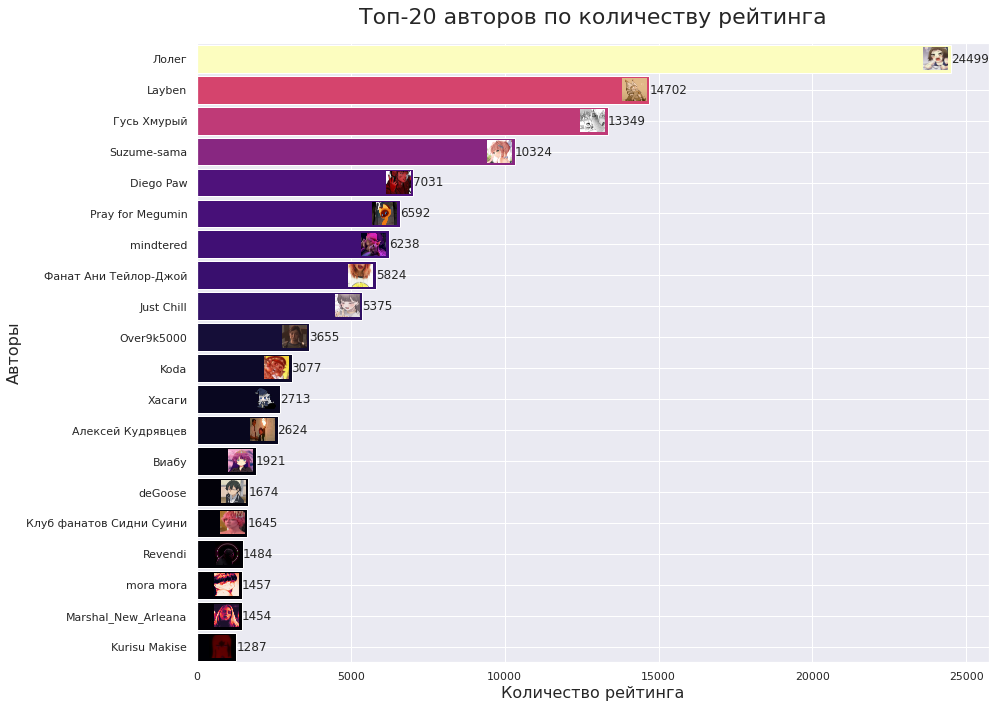

In [116]:
plt.rcParams["figure.figsize"] = [14, 10]
my_cmap = plt.get_cmap("magma")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

labels = tmp_likes_1.author_avatar_url[::-1]
# colors = ['lightcoral', 'orchid', 'peachpuff', 'coral', 'tan', 'indigo', 'goldenrod', 'pink', 'darkturquoise', 'teal'][::-1]
values = tmp_likes_1.likes[::-1] 

height = 0.9
plt.barh(y=tmp_likes_1.author_name[::-1], width=tmp_likes_1.likes[::-1], height=height, 
         color=my_cmap(rescale(values)), 
         align='center')

for i, (label, value) in enumerate(zip(labels, values)):
    im = Image.open(requests.get(label, stream=True).raw)
    plt.imshow(im, extent=[value - 900, value - 100, i - height / 2.5, i + height / 2.5], aspect='auto', zorder=2)
    plt.text(value + 1, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')

    
plt.xlim(0, max(values) * 1.05)
plt.ylim(-0.5, len(labels) - 0.5)
plt.xlabel('Количество рейтинга', fontsize=16)
plt.ylabel('Авторы', fontsize=16)
plt.title('Топ-20 авторов по количеству рейтинга', fontsize=22, pad=20)
plt.tight_layout()

# plt.savefig(PATH + "Full_analysis/authors_rating_1.jpg", dpi=300, bbox_inches='tight')

plt.show()

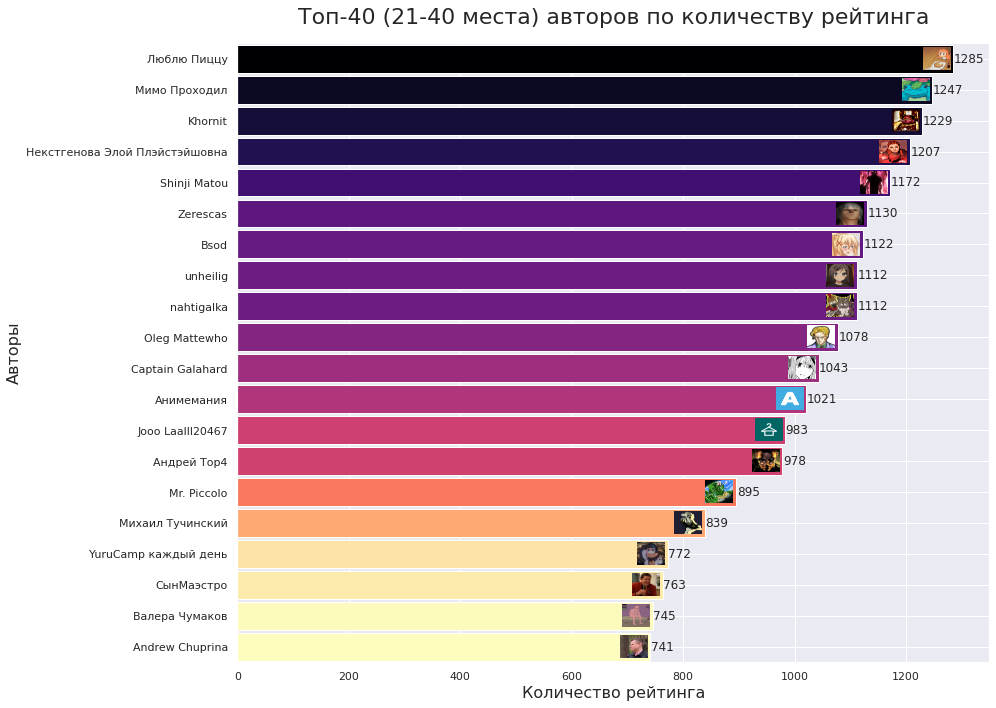

In [118]:
my_cmap = plt.get_cmap("magma_r")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

labels = tmp_likes_2.author_avatar_url[::-1]
# colors = ['lightcoral', 'orchid', 'peachpuff', 'coral', 'tan', 'indigo', 'goldenrod', 'pink', 'darkturquoise', 'teal'][::-1]
values = tmp_likes_2.likes[::-1] 

height = 0.9
plt.barh(y=tmp_likes_2.author_name[::-1], width=tmp_likes_2.likes[::-1], height=height, 
         color=my_cmap(rescale(values)), 
         align='center')

for i, (label, value) in enumerate(zip(labels, values)):
    im = Image.open(requests.get(label, stream=True).raw)
    plt.imshow(im, extent=[value - 55, value - 5, i - height / 2.5, i + height / 2.5], aspect='auto', zorder=2)
    plt.text(value + 1, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')

    
plt.xlim(0, max(values) * 1.05)
plt.ylim(-0.5, len(labels) - 0.5)
plt.xlabel('Количество рейтинга', fontsize=16)
plt.ylabel('Авторы', fontsize=16)
plt.title('Топ-40 (21-40 места) авторов по количеству рейтинга', fontsize=22, pad=20)
plt.tight_layout()

# plt.savefig(PATH + "Full_analysis/authors_rating_2.jpg", dpi=300, bbox_inches='tight')

plt.show()

# ---

# ---

In [119]:
df.head()

,date,id,url,author,comments_count,favorites_count,hits_count,is_repost,likes,subsite,...,videos,links,audio,total_mediacontent,hashtags,hour,month,weekday,is_weekend,period
0,2018-03-12 21:59:15,17110,https://dtf.ru/flood/17110-ne-odin-lish-tip-luny,"{'id': 4876, 'url': 'https://dtf.ru/u/4876-geo...",19,32,1969,True,36,Офтоп,...,3,0,0,45,[#long],21,3,Monday,0,2018-03
1,2020-01-26 20:38:21,97215,https://dtf.ru/u/92907-aleksey-fedorov/97215-t...,"{'id': 92907, 'url': 'https://dtf.ru/u/92907-a...",11,47,659,True,56,Алексей Фёдоров,...,0,0,0,17,[#anime],20,1,Sunday,1,2020-01
2,2020-02-18 19:11:46,104163,https://dtf.ru/u/92907-aleksey-fedorov/104163-...,"{'id': 92907, 'url': 'https://dtf.ru/u/92907-a...",39,23,744,True,49,Алексей Фёдоров,...,0,0,0,32,"[#anime, #evangelion]",19,2,Tuesday,0,2020-02
3,2020-02-29 18:25:10,108055,https://dtf.ru/u/92907-aleksey-fedorov/108055-...,"{'id': 92907, 'url': 'https://dtf.ru/u/92907-a...",7,18,236,True,41,Алексей Фёдоров,...,0,1,0,20,[#anime],18,2,Saturday,1,2020-02
4,2020-03-16 10:36:03,113363,https://dtf.ru/u/4810-oleg-kubaneishvili/11336...,"{'id': 4810, 'url': 'https://dtf.ru/u/4810-ole...",5,8,180,True,15,Олег Кубанеишвили,...,0,0,0,17,[],10,3,Monday,0,2020-03


In [120]:
plt.rcParams["figure.figsize"] = [14, 10]

def histogram_plotting(srs: pd.Series, path: str, xlim: int, ci_wide=90, desc_stat='mean', bins='auto'):
    """Function for plitting histogram (seaborn) with custom confidence interval
    and descriptive statistics.
    
    Parameters
    ----------
    srs : pd.Series
        Data for which the histogram is plotted. 
        
    ci_wide : int, default=90
        Wide of confidence interval in percents.
        
    desc_stat : str, default="mean"
        Calculated descriptive statistics.

    Returns
    -------
        None. Printing histogram.
    
    """
       
    ci = (100 - ci_wide) / 200
    confidence_interval = list(srs.quantile([ci, 1-ci]))
    
    ax = sns.histplot(srs, kde=True, bins=bins)
    max_bar_height = max([h.get_height() for h in ax.patches])
    
    ax.plot(confidence_interval, [max_bar_height*1.05, max_bar_height*1.05], color='black')
    
    for x in confidence_interval:
        ax.plot([x, x], [0, max_bar_height*1.1], color='black')
        ax.text(x, max_bar_height*1.13, f'{x:.0f}', horizontalalignment='center', verticalalignment='center')
    
    ax.text(sum(confidence_interval) / 2, max_bar_height*1.07, str(ci_wide) + '% interval',
                horizontalalignment='center', verticalalignment='center')

    descriptive_statistics = getattr(srs, desc_stat)()

    ax.plot([descriptive_statistics, descriptive_statistics], 
            [0, max_bar_height*1.05], color='black', linestyle='--')
    
    ax.text(descriptive_statistics, max_bar_height*0.15, 
            desc_stat.capitalize() + f': {descriptive_statistics:.0f}',
            bbox=dict(facecolor='white', edgecolor='white', alpha=0.5),
            horizontalalignment='center', verticalalignment='center')
    
    ax.set_ylim(0, max_bar_height*1.2)
    ax.set_xlim(left=-10, right=xlim)

    plt.tight_layout()
    
    plt.savefig(PATH + "Full_analysis/" + path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # END OF FUNC

In [121]:
df.columns

Index(['date', 'id', 'url', 'author', 'comments_count', 'favorites_count',
       'hits_count', 'is_repost', 'likes', 'subsite', 'title', 'type',
       'blocks', 'repost', 'stacked_reposts_authors', 'media_content_types',
       'author_name', 'author_type', 'author_avatar_url', 'symbols', 'words',
       'images', 'videos', 'links', 'audio', 'total_mediacontent', 'hashtags',
       'hour', 'month', 'weekday', 'is_weekend', 'period'],
      dtype='object')

In [ ]:
# df.favorites_count.sort_values(ascending=False).head(20)

Text(0.5, 1.0, 'Лайки')

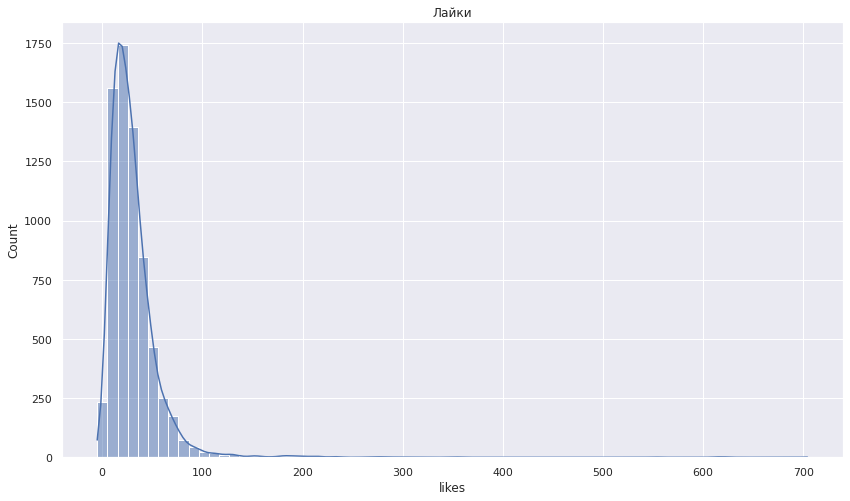

In [122]:
plt.rcParams["figure.figsize"] = [14, 8]

sns.histplot(x = df.likes, data=df, kde=True, bins=70).set_title("Лайки")
# plt.savefig(PATH + "Full_analysis/simple_likes_hist.jpg", dpi=300, bbox_inches='tight')

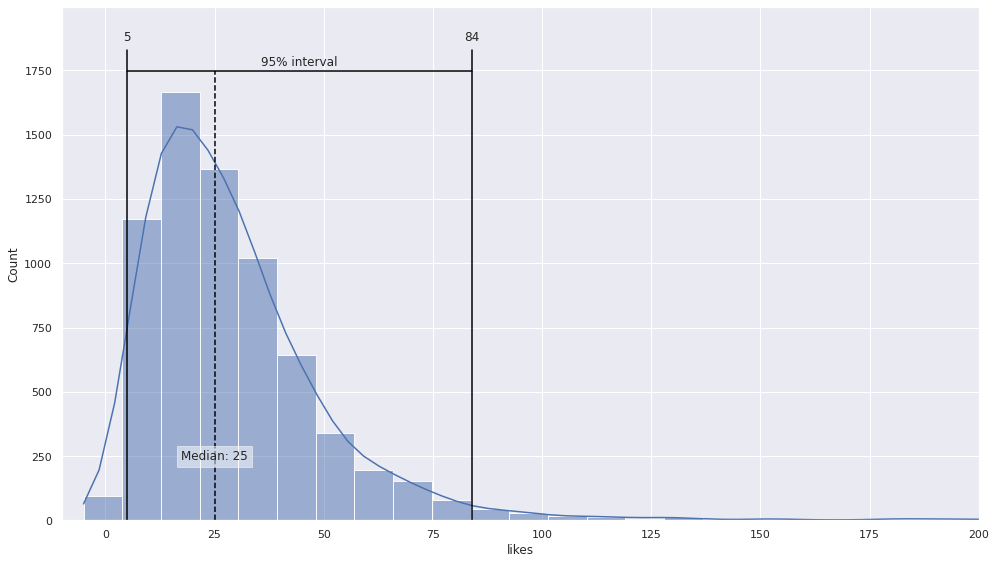

In [123]:
histogram_plotting(df.likes, "simple_likes_CI_hist.jpg", 200, desc_stat='median', ci_wide=95, bins=80)
plt.show()

Text(0.5, 1.0, 'Добавления в закладки')

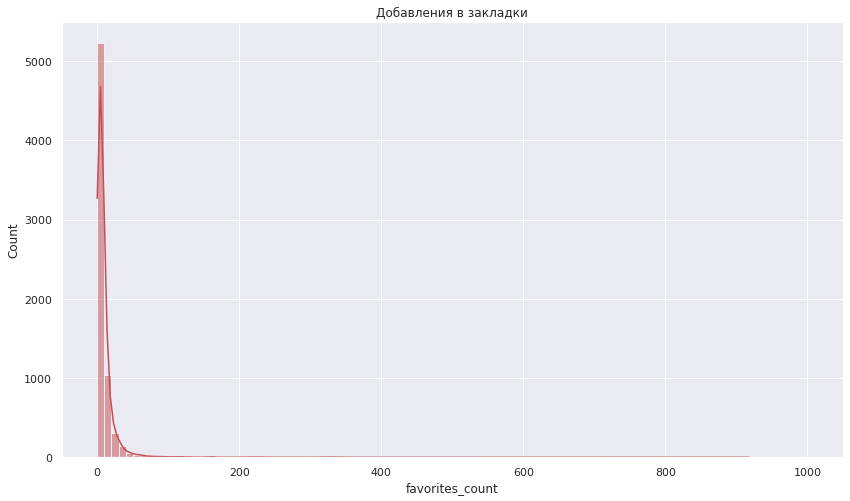

In [124]:
sns.histplot(x = df.favorites_count, data=df, kde=True, color="r", 
    bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 500, 1000]).set_title("Добавления в закладки")
# plt.savefig(PATH + "Full_analysis/simple_fav_hist.jpg", dpi=300, bbox_inches='tight')

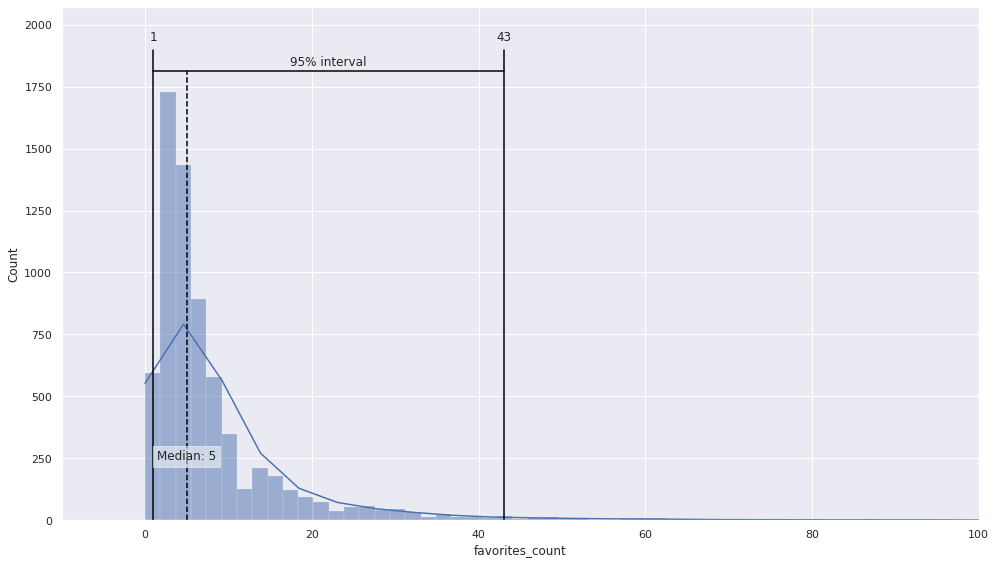

In [125]:
histogram_plotting(df.favorites_count, "simple_favs_CI_hist.jpg", 100, desc_stat='median', 
                   ci_wide=95, bins=500)
plt.show()

Text(0.5, 1.0, 'Комментарии')

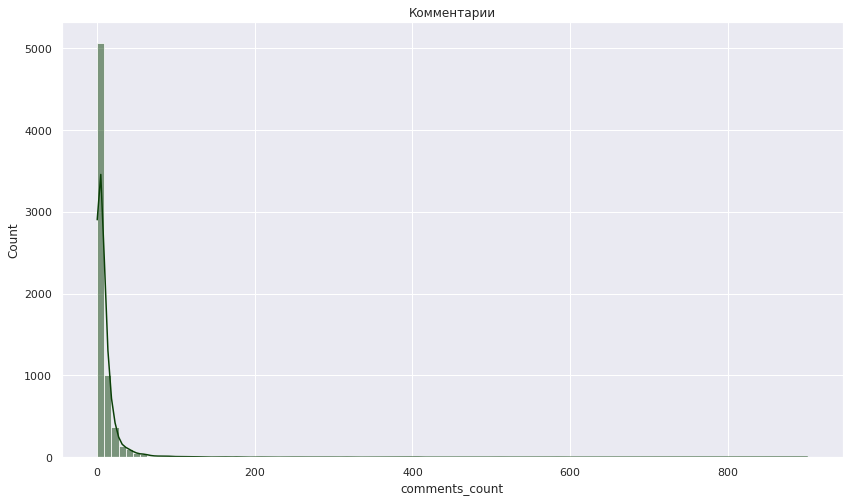

In [126]:
sns.histplot(x = df.comments_count, data=df, kde=True, color="#0b4008", 
             bins=100).set_title("Комментарии")
# plt.savefig(PATH + "Full_analysis/simple_comm_hist.jpg", dpi=300, bbox_inches='tight')

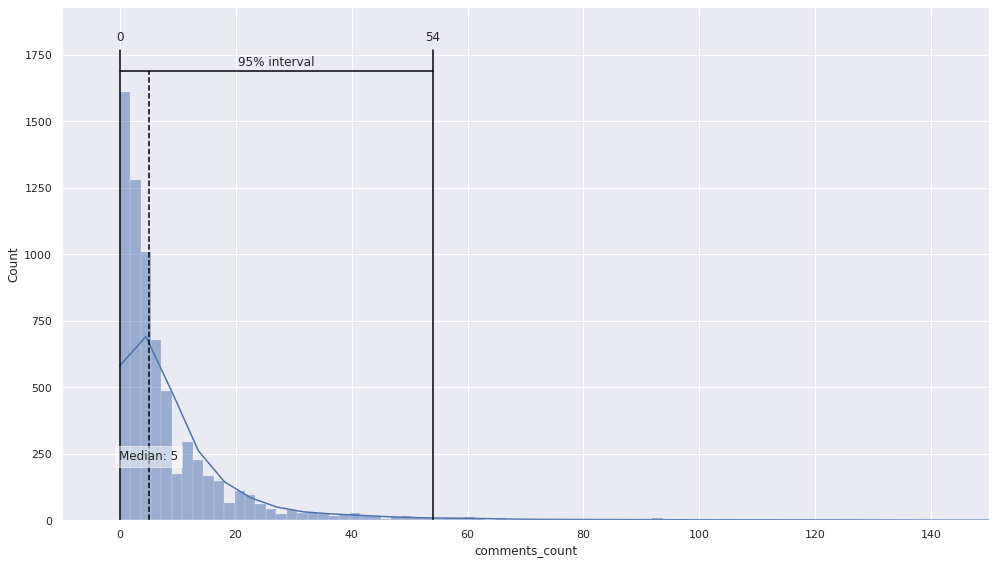

In [127]:
histogram_plotting(df.comments_count, "simple_comm_CI_hist.jpg", 150, desc_stat='median', 
                   ci_wide=95, bins=500)
plt.show()

In [128]:
df.hits_count.sort_values(ascending=False)

5170    57398
909     35914
2138    29741
766     26743
4680    16922
        ...  
2934       12
3286       11
620        11
207        11
2937        8
Name: hits_count, Length: 6900, dtype: int64

Text(0.5, 1.0, 'Просмотры')

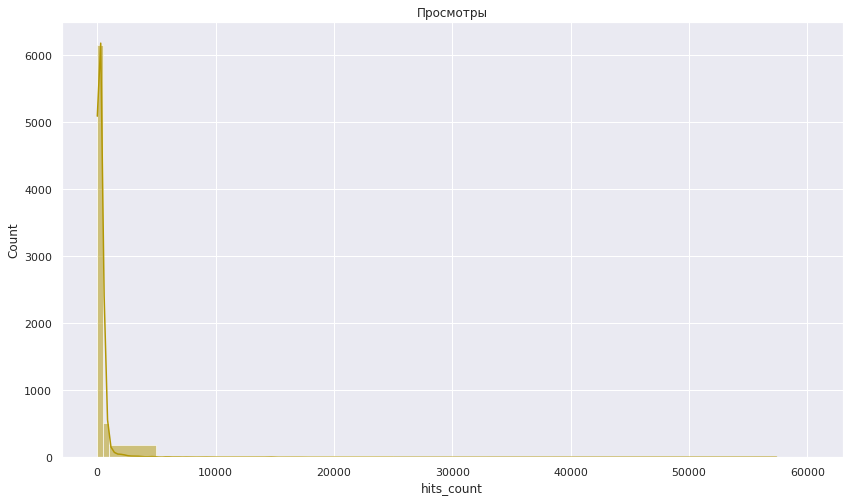

In [129]:
sns.histplot(x = df.hits_count, data=df, kde=True, color="#b29705", 
             bins=[0, 500, 1000, 5000, 10000, 25000, 60000]
            ).set_title("Просмотры")
# plt.savefig(PATH + "Full_analysis/simple_hits_hist.jpg", dpi=300, bbox_inches='tight')

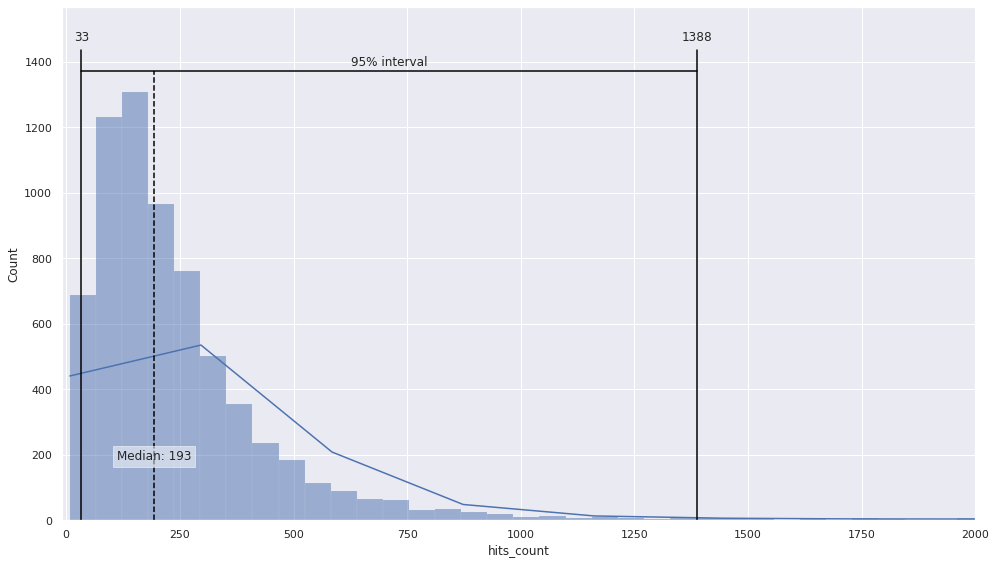

In [130]:
histogram_plotting(df.hits_count, "simple_hits_CI_hist.jpg", 2000, desc_stat='median', 
                   ci_wide=95, bins=1000)
plt.show()

Text(0.5, 1.0, 'Просмотры')

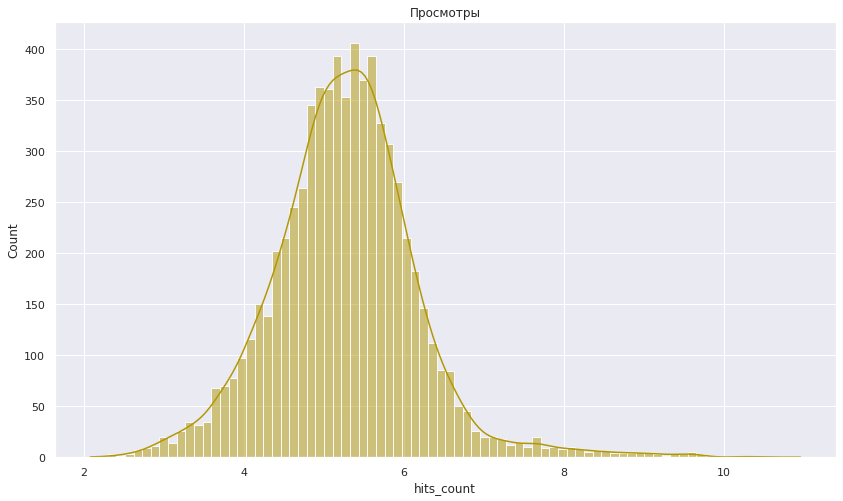

In [131]:
sns.histplot(x = np.log(df.hits_count), data=df, kde=True, color="#b29705", 
#              bins=[0, 500, 1000, 5000, 10000, 25000, 60000]
            ).set_title("Просмотры")

In [132]:
from matplotlib.colors import get_named_colors_mapping
get_named_colors_mapping()

{'xkcd:cloudy blue': '#acc2d9',
 'xkcd:dark pastel green': '#56ae57',
 'xkcd:dust': '#b2996e',
 'xkcd:electric lime': '#a8ff04',
 'xkcd:fresh green': '#69d84f',
 'xkcd:light eggplant': '#894585',
 'xkcd:nasty green': '#70b23f',
 'xkcd:really light blue': '#d4ffff',
 'xkcd:tea': '#65ab7c',
 'xkcd:warm purple': '#952e8f',
 'xkcd:yellowish tan': '#fcfc81',
 'xkcd:cement': '#a5a391',
 'xkcd:dark grass green': '#388004',
 'xkcd:dusty teal': '#4c9085',
 'xkcd:grey teal': '#5e9b8a',
 'xkcd:macaroni and cheese': '#efb435',
 'xkcd:pinkish tan': '#d99b82',
 'xkcd:spruce': '#0a5f38',
 'xkcd:strong blue': '#0c06f7',
 'xkcd:toxic green': '#61de2a',
 'xkcd:windows blue': '#3778bf',
 'xkcd:blue blue': '#2242c7',
 'xkcd:blue with a hint of purple': '#533cc6',
 'xkcd:booger': '#9bb53c',
 'xkcd:bright sea green': '#05ffa6',
 'xkcd:dark green blue': '#1f6357',
 'xkcd:deep turquoise': '#017374',
 'xkcd:green teal': '#0cb577',
 'xkcd:strong pink': '#ff0789',
 'xkcd:bland': '#afa88b',
 'xkcd:deep aqua': '#0

Text(0.5, 1.0, 'Количество символов')

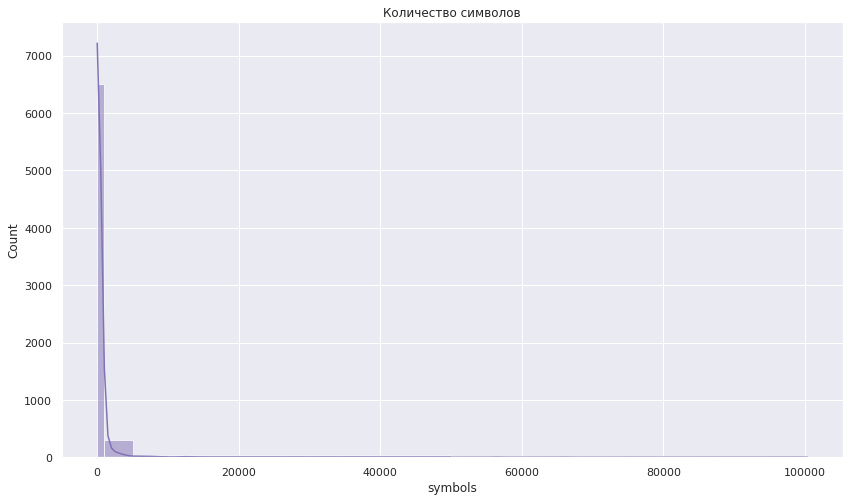

In [133]:
sns.histplot(x = df.symbols, data=df, kde=True, color="m", 
#              bins=[0, 100, 200, 300, 400, 500, 1000, 2000, 5000, 10000, 25000, 50000, 100000]
             bins=[0, 1000, 5000, 10000, 50000, 100000]
            ).set_title("Количество символов")
# plt.savefig(PATH + "Full_analysis/simple_symb_hist.jpg", dpi=300, bbox_inches='tight')

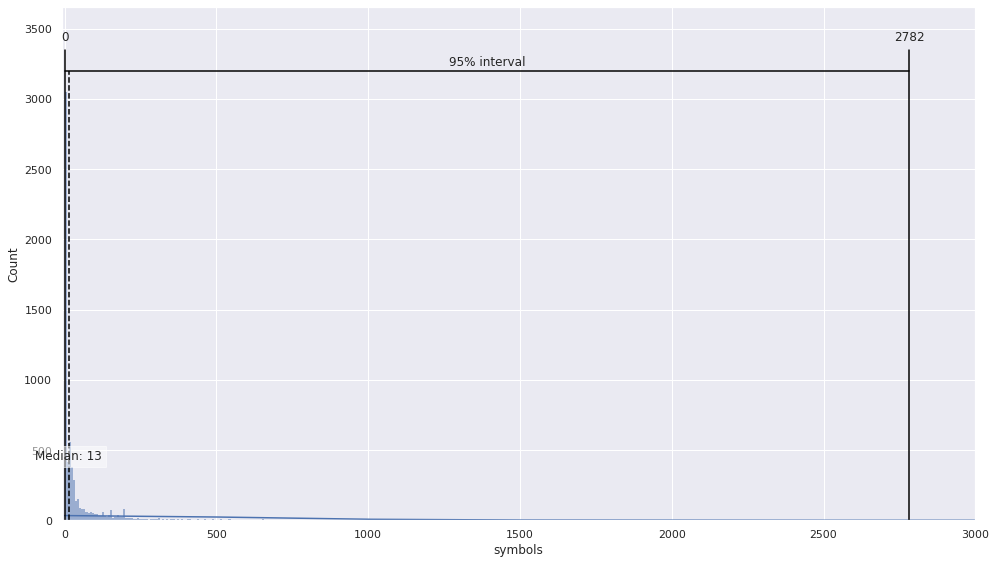

In [139]:
histogram_plotting(df.symbols, "simple_symbols_CI_hist.jpg", 3000, desc_stat='median', 
                   ci_wide=95)
plt.show()

Text(0.5, 1.0, 'Количество символов')

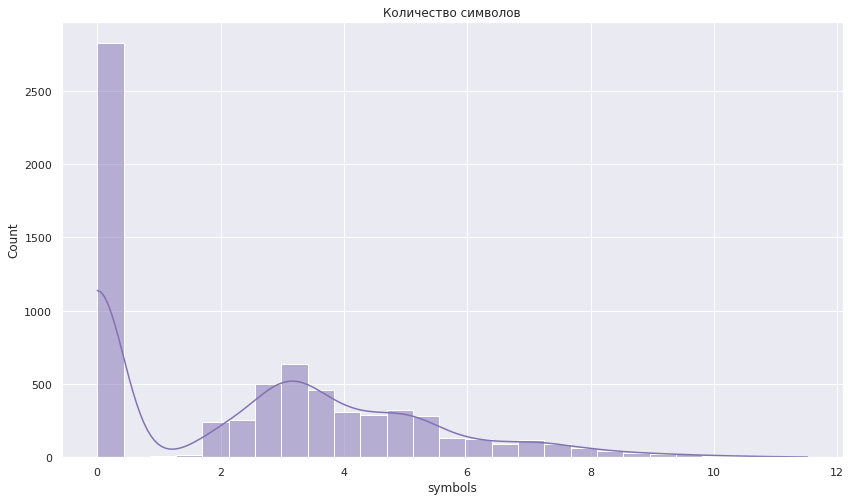

In [135]:
sns.histplot(x = np.log(df.symbols +1), data=df, kde=True, color="m", 
#              bins=[0, 100, 200, 300, 400, 500, 1000, 2000, 5000, 10000, 25000, 50000, 100000]
#              bins=[0, 1000, 5000, 10000, 50000, 100000]
            ).set_title("Количество символов")

Text(0.5, 1.0, 'Количество медиаконтента')

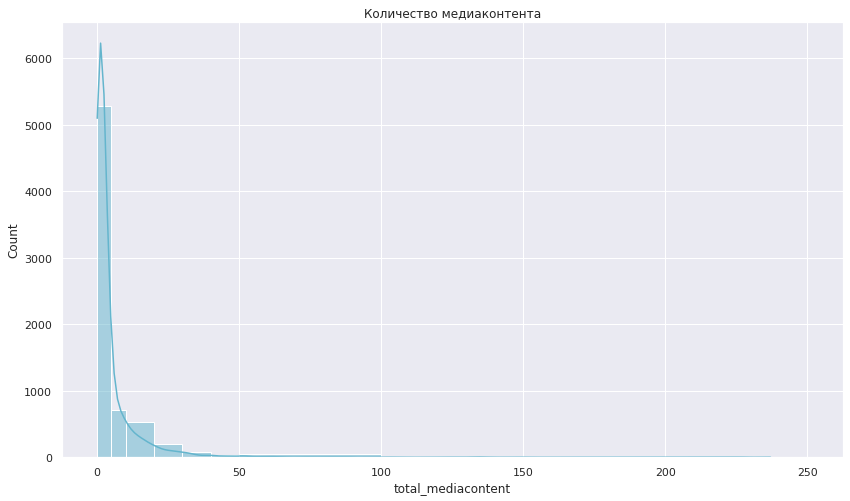

In [136]:
sns.histplot(x = df.total_mediacontent, data=df, kde=True, color="c", 
                bins=[0,5,10,20,30,40,50,100,150,200,250]
            ).set_title("Количество медиаконтента")
# plt.savefig(PATH + "Full_analysis/simple_symb_hist.jpg", dpi=300, bbox_inches='tight')

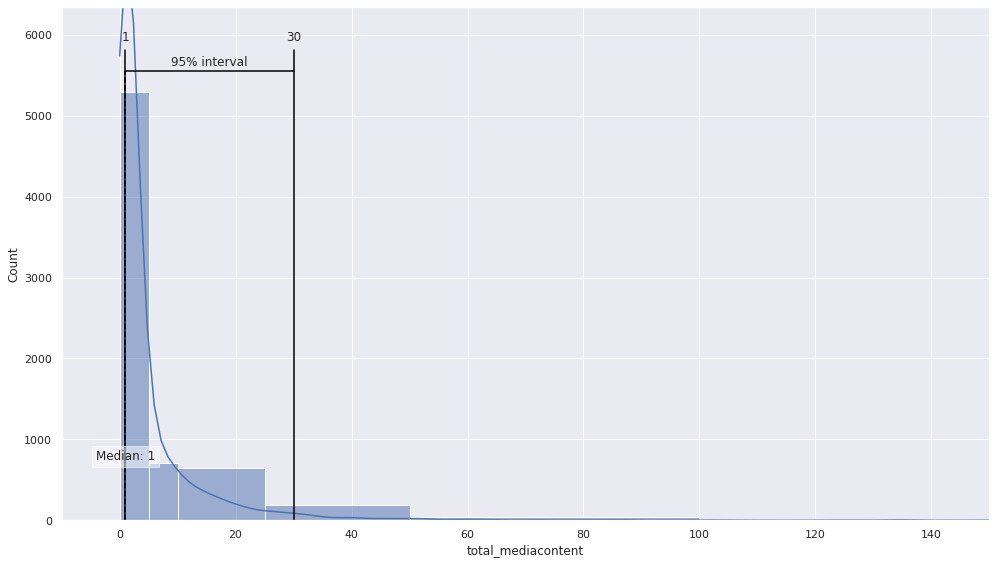

In [137]:
histogram_plotting(df.total_mediacontent, "simple_mc_CI_hist.jpg", 150, desc_stat='median', 
                   ci_wide=95, bins=[0,5,10,25,50,100])
plt.show()

Text(0.5, 1.0, 'Количество медиаконтента')

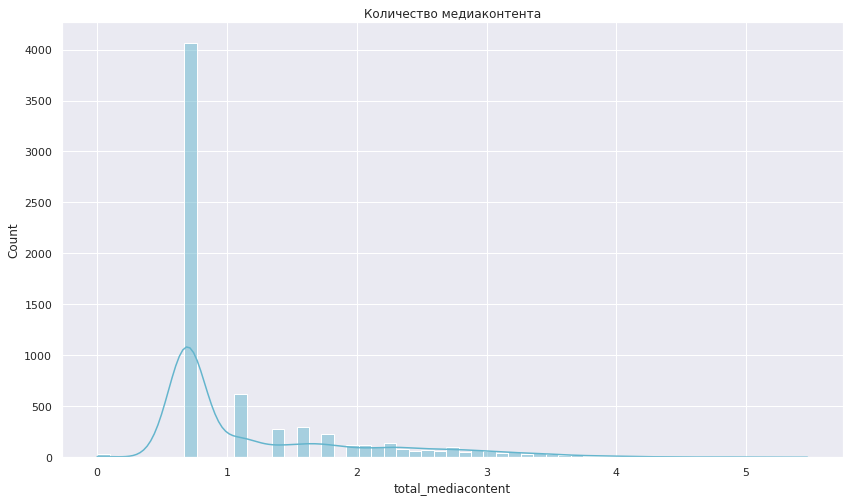

In [138]:
sns.histplot(x = np.log(df.total_mediacontent + 1), data=df, kde=True, color="c", 
#                 bins=[0,1,2,3,4,5]
            ).set_title("Количество медиаконтента")

In [ ]:
# plt.rcParams["figure.figsize"] = [16, 14]
# f, axes = plt.subplots(2, 3, )
# f.suptitle("Количественные характеристики публикаций")

# sns.histplot(x = df.likes, data=df, kde=True, ax=axes[0,0], bins=70).set_title("Лайки")
# sns.histplot(x = df.comments_count, data=df, kde=True, color="#0b4008", 
#              ax=axes[0,1], bins=100).set_title("Комментарии")
# sns.histplot(x = df.favorites_count, data=df, kde=True, color="#de0c62", 
#              bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 500, 1000], ax=axes[0,2]) \
# .set_title("Добавления в закладки")

In [140]:
df.columns

Index(['date', 'id', 'url', 'author', 'comments_count', 'favorites_count',
       'hits_count', 'is_repost', 'likes', 'subsite', 'title', 'type',
       'blocks', 'repost', 'stacked_reposts_authors', 'media_content_types',
       'author_name', 'author_type', 'author_avatar_url', 'symbols', 'words',
       'images', 'videos', 'links', 'audio', 'total_mediacontent', 'hashtags',
       'hour', 'month', 'weekday', 'is_weekend', 'period'],
      dtype='object')

In [141]:
plt.rcParams["figure.figsize"] = [14, 10]

In [ ]:
# df.likes[(df.is_repost == False) & (df.author_type == 2)]

In [ ]:
f, axes = plt.subplots(2, 2, )#sharey=True, sharex=True)
f.suptitle("Распределение количества лайков у постов")

sns.histplot(x = df.likes[(df.is_repost == False) & (df.author_type == 1)], 
             data=df, kde=True, ax=axes[0,0], bins=20).set_title("Посты подсайта")

sns.histplot(x = df.likes[(df.is_repost == True) & (df.author_type == 1)], 
             data=df, kde=True, ax=axes[1,0], bins=30).set_title("Репосты")

sns.histplot(x = df.likes[(df.is_repost == False) & (df.author_type == 2)], 
             data=df, kde=True, ax=axes[0,1], bins=20).set_title("Посты подсайта")

sns.histplot(x = df.likes[(df.is_repost == True) & (df.author_type == 2)], 
             data=df, kde=True, ax=axes[1,1], bins=30).set_title("Репосты")

In [ ]:
f, axes = plt.subplots(1, 2, sharey=True, sharex=True)
f.suptitle("Распределение количества лайков у постов")

sns.histplot(x = df.likes[df.is_repost == False], 
             data=df, kde=True, ax=axes[0], bins=20).set_title("Посты подсайта")

sns.histplot(x = df.likes[df.is_repost == True], 
             data=df, kde=True, ax=axes[1], bins=30).set_title("Репосты")

In [ ]:
sns.distplot(df.likes, kde=True, color="b")

In [ ]:
len('двенадцать')

In [ ]:
f, axes = plt.subplots(2, 4, figsize=(14, 10))
sns.despine(left=True)

# Plot a simple histogram with binsize determined automatically
sns.distplot(df.likes, kde=True, color="b", ax=axes[0, 0])

# Plot a kernel density estimate and rug plot
sns.distplot(df.favorites_count, kde=True, color="r", ax=axes[0, 1])

# Plot a filled kernel density estimate
sns.distplot(df.hits_count, kde=True, color="g", kde_kws={"shade": True}, ax=axes[0, 2])

# Plot a histogram and kernel density estimate
sns.distplot(df.comments_count, kde=True, color="m", kde_kws={"shade": True}, ax=axes[0, 3])

# sns.distplot(df.comments_count, kde=True, color="m", kde_kws={"shade": True}, ax=axes[1, 0])

plt.setp(axes, yticks=[])
plt.tight_layout()

#### Корреляция

In [142]:
df.columns

Index(['date', 'id', 'url', 'author', 'comments_count', 'favorites_count',
       'hits_count', 'is_repost', 'likes', 'subsite', 'title', 'type',
       'blocks', 'repost', 'stacked_reposts_authors', 'media_content_types',
       'author_name', 'author_type', 'author_avatar_url', 'symbols', 'words',
       'images', 'videos', 'links', 'audio', 'total_mediacontent', 'hashtags',
       'hour', 'month', 'weekday', 'is_weekend', 'period'],
      dtype='object')

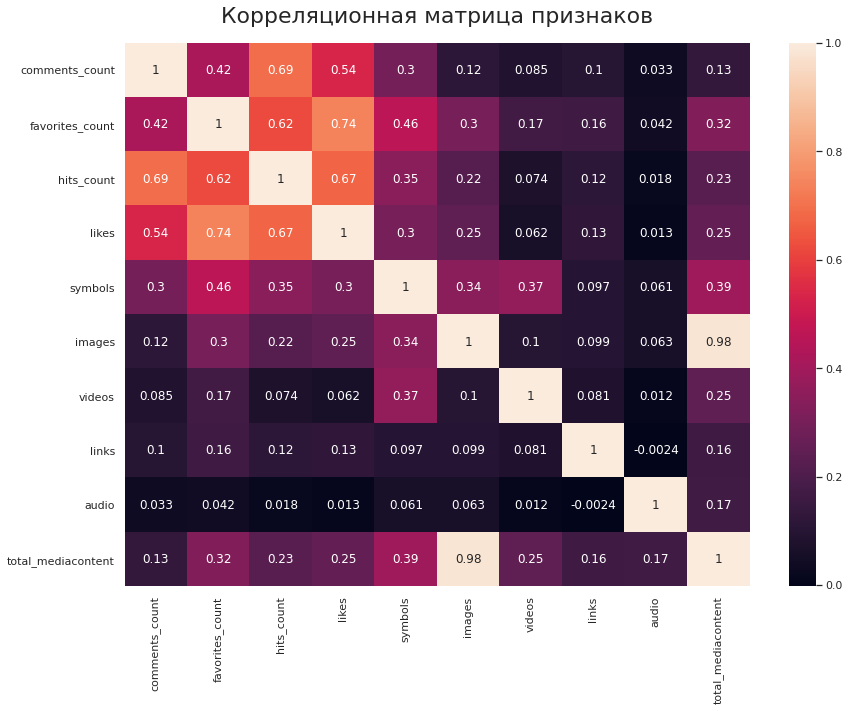

In [143]:
sns.heatmap(df.loc[:, ['comments_count', 'favorites_count', 'hits_count', 'likes', 'symbols',
                       'images', 'videos', 'links', 'audio', 'total_mediacontent']].corr(method='pearson'), 
            annot=True)

plt.title('Корреляционная матрица признаков', fontsize=22, pad=20);
# plt.savefig(PATH + "Full_analysis/corr_matrix.jpg", dpi=300, bbox_inches='tight')

In [ ]:
# from scipy import stats

# cols = ['comments_count', 'favorites_count', 'hits_count', 'symbols',
#         'images', 'videos', 'links', 'audio', 'total_mediacontent']

# for col in cols: 
#     pearson_coef, p_value = stats.pearsonr(df[col], df['likes'])
#     print("PearsonR между {} и likes {} с P-значением P = {}".format(
#           col, pearson_coef, p_value ))
    
#     if p_value < 0.001:
#         print('Корреляция между {} и likes статистически значимая'.format(col))
#     elif p_value < 0.05:
#         print('Корреляция между {} и likes средняя'.format(col))
#     elif p_value < 0.1:
#         print('Корреляция между {} и likes слабая'.format(col))
#     else:
#         print('Корреляция между {} и likes статистически незначимая'.format(col))
        
#     if pearson_coef > 0 :
#         if pearson_coef > 0.85:
#             print('Коэффициент ~{} показывает положительную очень сильную связь\n'.format(pearson_coef))
#         elif pearson_coef > 0.75 :
#             print('Коэффициент ~{} показывает положительную достаточно сильную связь\n'.format(pearson_coef))
#         elif pearson_coef > 0.60:
#             print('Коэффициент ~{} показывает положительную относительно сильную связь\n'.format(pearson_coef))
#         elif pearson_coef > 0.50 :
#             print('Коэффициент ~{} показывает положительную среднюю связь\n'.format(pearson_coef))
#         else:
#             print('Коэффициент ~{} показывает положительную слабую связь\n'.format(pearson_coef))
#     else:
#         if abs(pearson_coef) > 0.85:
#             print('Коэффициент ~{} показывает негативную очень сильную связь\n'.format(pearson_coef))
#         elif abs(pearson_coef) > 0.75 :
#             print('Коэффициент ~{} показывает негативную достаточно сильную связь\n'.format(pearson_coef))
#         elif abs(pearson_coef) > 0.60:
#             print('Коэффициент ~{} показывает негативную относительно сильную связь\n'.format(pearson_coef))
#         elif abs(pearson_coef) > 0.50 :
#             print('Коэффициент ~{} показывает негативную среднюю связь\n'.format(pearson_coef))
#         else:
#             print('Коэффициент ~{} показывает негативную слабую связь\n'.format(pearson_coef))

In [ ]:
# pearson_coef, p_value = stats.pearsonr(np.log(df.total_mediacontent+1), np.log(df.likes+10))
# print(pearson_coef, p_value)
# sns.scatterplot(data=df, x=np.log(df.total_mediacontent+1), y=np.log(df.likes+10))

In [ ]:
# pearson_coef, p_value = stats.pearsonr(np.log(df.symbols+10), np.log(df.likes+10))
# print(pearson_coef, p_value)
# sns.scatterplot(data=df, x=np.log(df.symbols+10), y=np.log(df.likes+10))

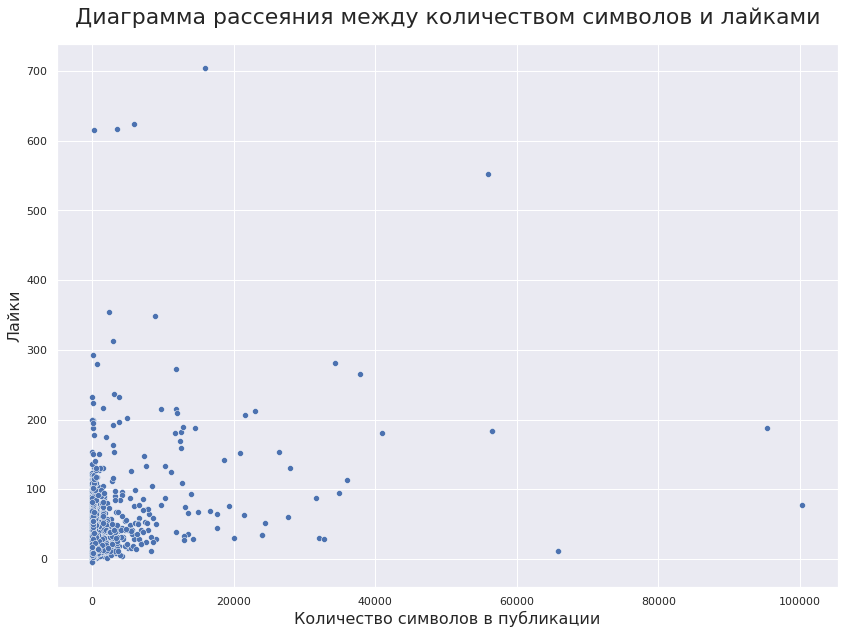

In [144]:
sns.scatterplot(data=df, x='symbols', y='likes')
plt.xlabel('Количество символов в публикации', fontsize=16)
plt.ylabel('Лайки', fontsize=16)
plt.title('Диаграмма рассеяния между количеством символов и лайками', fontsize=22, pad=20);
# plt.savefig(PATH + "Full_analysis/scatter_likes_symbols.jpg", dpi=300, bbox_inches='tight')

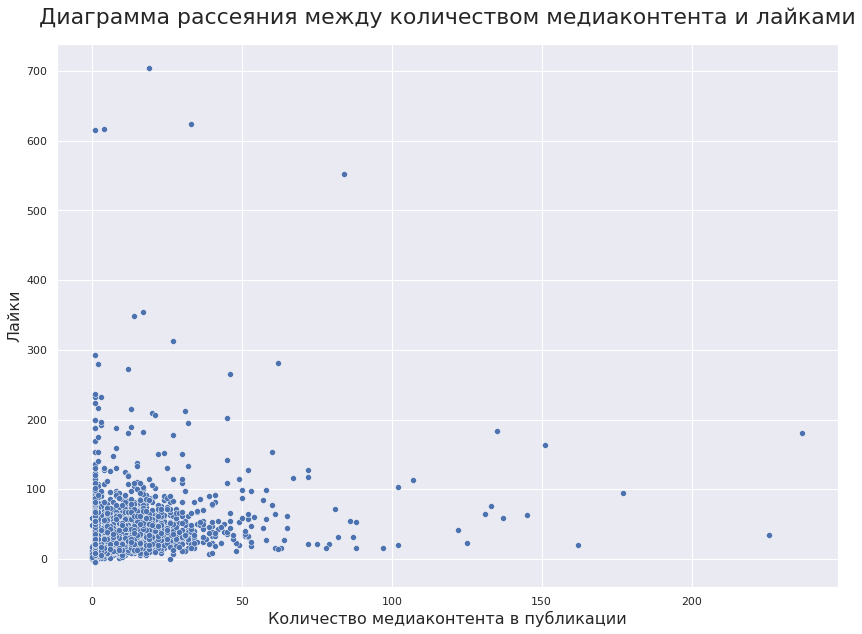

In [145]:
sns.scatterplot(data=df, x='total_mediacontent', y='likes')
plt.xlabel('Количество медиаконтента в публикации', fontsize=16)
plt.ylabel('Лайки', fontsize=16)
plt.title('Диаграмма рассеяния между количеством медиаконтента и лайками', fontsize=22, pad=20);
# plt.savefig(PATH + "Full_analysis/scatter_likes_media.jpg", dpi=300, bbox_inches='tight')

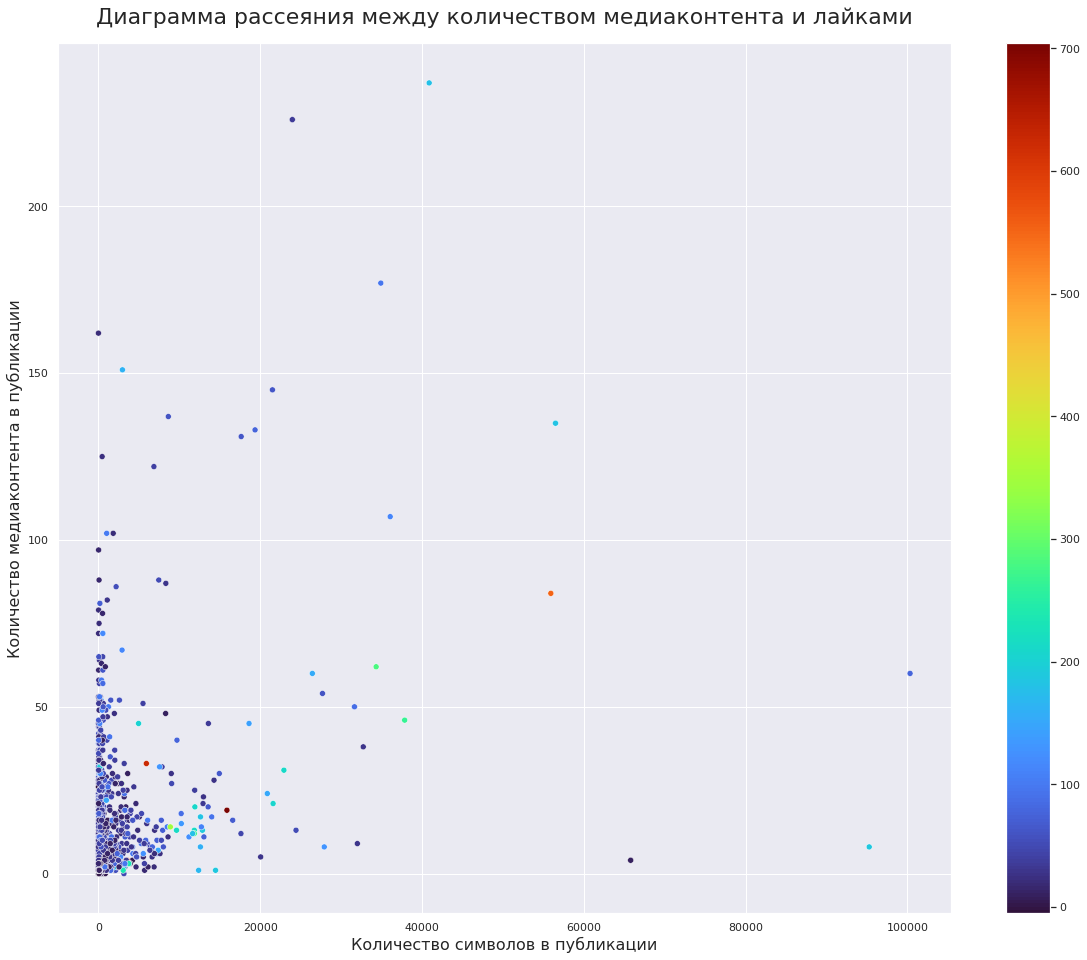

In [146]:
plt.rcParams["figure.figsize"] = [20, 16]

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
ax = sns.scatterplot(x='symbols', y='total_mediacontent', hue='likes', palette='turbo', data=df)

norm = plt.Normalize(df.likes.min(), df.likes.max())
sm = plt.cm.ScalarMappable(cmap="turbo", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)

plt.xlabel('Количество символов в публикации', fontsize=16)
plt.ylabel('Количество медиаконтента в публикации', fontsize=16)
plt.title('Диаграмма рассеяния между количеством медиаконтента и лайками', fontsize=22, pad=20);

# plt.savefig(PATH + "Full_analysis/scatter_symbols_media_likes.jpg", dpi=300, bbox_inches='tight')

plt.show()

In [147]:
df.groupby(['author_name']).agg({'id': 'count', 'likes': ['max', 'sum']}) \
    .sort_values(by=("id",'count'), ascending=False)

id likes       
               count   max    sum
author_name                      
Лолег            827   130  24876
Layben           717    91  14874
Гусь Хмурый      470    99  13566
Suzume-sama      358   114  13374
Diego Paw        324   124   7350
...              ...   ...    ...
Андрей Мятцуев     1    33     33
Hikaaaaaaaari      1    28     28
Аниме Бот          1   192    192
Grak Pilatus       1    39     39
💱                  1    10     10

[412 rows x 3 columns]

In [148]:
df.groupby(['author_name', 'is_repost']).agg({'id': 'count', 'likes': ['max', 'sum']}).sort_values(by=("id",'count'), ascending=False)

id likes       
                      count   max    sum
author_name is_repost                   
Лолег       False       816   130  24499
Layben      False       711    91  14702
Гусь Хмурый False       466    99  13349
Diego Paw   False       309   124   7031
Suzume-sama False       283   114  10324
...                     ...   ...    ...
Sm1LeXZ     True          1    44     44
Skayraks    True          1    33     33
Shy         False         1    47     47
Shot        False         1    28     28
💱           False         1    10     10

[506 rows x 3 columns]

https://stackoverflow.com/questions/62884183/trying-to-add-a-colorbar-to-a-seaborn-scatterplot

https://stackoverflow.com/questions/47311632/jupyter-how-to-rotate-3d-graph

https://stackoverflow.com/questions/33436221/displaying-rotatable-3d-plots-in-ipython-or-jupyter-notebook

https://matplotlib.org/2.2.5/gallery/mplot3d/rotate_axes3d.html

https://stackoverflow.com/questions/49981313/rotate-interactively-a-3d-plot-in-python-matplotlib-jupyter-notebook

https://stackoverflow.com/questions/14261903/how-can-i-open-the-interactive-matplotlib-window-in-ipython-notebook

https://stackoverflow.com/questions/38326983/how-to-rotate-a-3d-surface-in-matplotlib

https://matplotlib.org/stable/gallery/mplot3d/surface3d.html

https://stackoverflow.com/questions/9170838/surface-plots-in-matplotlib

https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html

https://stackoverflow.com/questions/36296101/donut-chart-python

https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html

https://medium.com/@krishnakummar/donut-chart-with-python-matplotlib-d411033c960b

In [ ]:
# %matplotlib notebook

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams["figure.figsize"] = [12, 16]

x,y,z = df.symbols.values, df.total_mediacontent.values, df.likes.values
# x = x.reshape(-1,1)
# y = y.reshape(-1,1)
# z = z.reshape(-1,1)
# x_scaled = StandardScaler().fit_transform(x)
# y_scaled = StandardScaler().fit_transform(y)
# z_scaled = StandardScaler().fit_transform(z)

fig = plt.figure()
ax = Axes3D(fig)
# # surf = ax.plot_trisurf(x, y, z, cmap=cm.jet, linewidth=0.01)
# # fig.colorbar(surf, shrink=0.05, aspect=50)
# # plt.show()

# c = np.arange(len(z_scaled)) / len(z_scaled)
c = np.arange(len(z)) / len(z)
# p = ax.scatter3D(x_scaled, y_scaled, z_scaled, c=c)
ax.scatter3D(x, y, z, c=c)

plt.title('3D диаграмма рассеяния')
plt.xlabel('Количество символов в публикациях')
plt.ylabel('Количество медиаконтента в публикациях')

In [ ]:
# plt.rcParams["figure.figsize"] = [14, 10]

# def histogram_plotting(srs: pd.Series, ci_wide=90, desc_stat='mean'):
#     """Function for plitting histogram (seaborn) with custom confidence interval
#     and descriptive statistics.
    
#     Parameters
#     ----------
#     srs : pd.Series
#         Data for which the histogram is plotted. 
        
#     ci_wide : int, default=90
#         Wide of confidence interval in percents.
        
#     desc_stat : str, default="mean"
#         Calculated descriptive statistics.

#     Returns
#     -------
#         None. Printing histogram.
    
#     """
       
#     ci = (100 - ci_wide) / 200
#     confidence_interval = list(srs.quantile([ci, 1-ci]))
    
#     ax = sns.histplot(srs, kde=True, bins='auto')
#     max_bar_height = max([h.get_height() for h in ax.patches])
    
#     ax.plot(confidence_interval, [max_bar_height*1.05, max_bar_height*1.05], color='black')
    
#     for x in confidence_interval:
#         ax.plot([x, x], [0, max_bar_height*1.1], color='black')
#         ax.text(x, max_bar_height*1.13, f'{x:.0f}', horizontalalignment='center', verticalalignment='center')
    
#     ax.text(sum(confidence_interval) / 2, max_bar_height*1.07, str(ci_wide) + '% interval',
#                 horizontalalignment='center', verticalalignment='center')

#     descriptive_statistics = getattr(srs, desc_stat)()

#     ax.plot([descriptive_statistics, descriptive_statistics], 
#             [0, max_bar_height*1.05], color='black', linestyle='--')
    
#     ax.text(descriptive_statistics, max_bar_height*0.15, 
#             desc_stat.capitalize() + f': {descriptive_statistics:.0f}',
#             bbox=dict(facecolor='white', edgecolor='white', alpha=0.5),
#             horizontalalignment='center', verticalalignment='center')
    
#     ax.set_ylim(0, max_bar_height*1.2)

#     plt.tight_layout()
#     plt.show()
    
#     # END OF FUNC

In [ ]:
# df.columns

In [ ]:
# histogram_plotting(df.total_mediacontent, desc_stat='median')

In [ ]:
sns.scatterplot(x=df.symbols, y=df.total_mediacontent, hue='is_repost', data=df)

In [ ]:
sns.histplot(x = df.comments_count, kde=True)

In [ ]:
# sns.boxplot(data=df, x="is_repost", y="likes")

In [ ]:
a = df.groupby(['author_name']).agg({'id': 'count'})
a[a['id'] > 1].sort_values(by='id', ascending=False)

In [ ]:
a[a['id'] > 100].index

In [ ]:
tmp = df.groupby(['author_name']).agg({'id': 'count'})

In [ ]:
# sns.boxplot(data=df, y="author_name", x="likes")

In [ ]:
# sns.violinplot(y=df.likes)

## TEST OF PLONINE

In [ ]:
from plotnine import *
from plotnine.data import *

https://plotnine.readthedocs.io/en/stable/generated/plotnine.geoms.geom_violin.html?highlight=violin#violins-boxes-points-and-lines

In [ ]:
(ggplot(df, aes(x=df.is_repost, y=df.likes, fill=df.is_repost)) + geom_violin(show_legend=False) + geom_boxplot(width = .2)
+ scale_fill_manual(values=['dodgerblue', 'darkorange'])
+ theme_classic()
+ theme(figure_size=(8, 6))
)

In [ ]:
df[df.title == 'Статья удалена'].shape[0]

In [ ]:
df[df.title == 'Статья удалена'].author_name.unique()

In [ ]:
df[sum([df.images, df.videos, df.links]) == 0].symbols.unique()

In [ ]:
df[df.total_mediacontent == 0].symbols.unique()

In [ ]:
df.total_mediacontent.value_counts(normalize=True, sort=True)

In [ ]:
df.shape[0]

## END OF TEST

In [ ]:
# sns.displot(x=df.symbols, y=df.total_mediacontent, col='is_repost', data=df)

In [ ]:
sns.scatterplot(x=df.symbols, y=df.total_mediacontent, hue='is_repost', data=df)

In [ ]:
# sns.histplot(data=df, x=df.total_mediacontent, kde=True)

In [ ]:
# sns.histplot(data=df, x=df.likes, kde=True)#, bins=70)

# CLUSTERING

In [ ]:
X = np.array([df.symbols, df.total_mediacontent]).T
X

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics

inertia = []
k = range(1, 10)
for k_i in k:
    km = KMeans(n_clusters=k_i).fit(X)
    km.fit(X)
    inertia.append(km.inertia_)
    
plt.plot(k, inertia)
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('The Elbow Method showing the optimal k')

In [ ]:
from sklearn.metrics import silhouette_score
inertia = []
k = range(2, 10)
for k_i in k:
    km = KMeans(n_clusters=k_i).fit(X)
    km.fit(X)
    inertia.append(silhouette_score(X, km.labels_))

print(inertia)
    
plt.plot(k, inertia)
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('The Elbow Method showing the optimal k')

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=10)
y_pred = kmeans.fit_predict(X)

# Plot the prediction
# plt.scatter(X[:,0], X[:,1], c=y_pred)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y_pred)

In [ ]:
from sklearn.cluster import DBSCAN

X = np.array([df.symbols, df.total_mediacontent]).T
X

In [ ]:
clustering = DBSCAN(eps=15, min_samples=10)
y_pred = clustering.fit_predict(X)

plt.rcParams["figure.figsize"] = [20, 16]
print(np.unique(y_pred))

sns.scatterplot(x=X[:,0], y=X[:,1], hue=y_pred, palette='turbo')

### DBScan не работает при различных плотностях кластеров. Собственно это и можно наблюдать.

In [ ]:
np.unique(y_pred)

In [ ]:
from sklearn.cluster import SpectralClustering

X = np.array([df.symbols, df.total_mediacontent]).T
X

Очень долго работало и не доработало до конца. Нужно попробовать в колабе.

In [ ]:
# clustering = SpectralClustering(n_clusters=5, assign_labels="discretize", affinity='rbf')
# y_pred = clustering.fit_predict(X)

# plt.rcParams["figure.figsize"] = [20, 16]
# print(np.unique(y_pred))

# sns.scatterplot(x=X[:,0], y=X[:,1], hue=y_pred, palette='turbo')

In [ ]:
from sklearn import cluster
from sklearn.cluster import MeanShift

bandwidth = cluster.estimate_bandwidth(X, quantile=0.2, n_samples=50)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
y_pred = ms.fit_predict(X)

plt.rcParams["figure.figsize"] = [20, 16]
print(np.unique(y_pred))

labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

sns.scatterplot(x=X[:,0], y=X[:,1], hue=y_pred, palette='turbo')

# from itertools import cycle
# colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
# for k, col in zip(range(n_clusters_), colors):
#     my_members = labels == k
#     cluster_center = cluster_centers[k]
#     plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
#     plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
#              markeredgecolor='k', markersize=14)
# plt.title('Estimated number of clusters: %d' % n_clusters_)
# plt.show()

Почему нормально не сошлись алгоритмы кластеризации? 
#### Потому что я сделал чушь. Основные метрики использованных алгоритмов - плотность и расстояние. Учитывая, что я не нормализировал и не стандартизировал входные данные - алгоритмы просто не могли нормально сойтись. 

Слишком высокая дисперсия по абсциссе, по отношению к дисперсию по ординате. 
#### НОРМАЛИЗАЦИЯ НУЖНА ОБЯЗАТЕЛЬНО!

Для DBSCAN важны параметры эпсилон и н_сэмплс - т. е. эпсилон-окрестность точки и количество точек, входящих в эту окрестность, которые необходимы для определения их принадлежности к одному кластеру. 

Следует также попробовать иерархическую кластеризацию на данных. 

In [ ]:
from sklearn import preprocessing

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
X_scaled = StandardScaler().fit_transform(X)
X_scaled

In [ ]:
clustering = DBSCAN(eps=0.15, min_samples=7)
y_pred = clustering.fit_predict(X_scaled)

plt.rcParams["figure.figsize"] = [20, 16]
print(np.unique(y_pred))

sns.scatterplot(x=X_scaled[:,0], y=X_scaled[:,1], hue=y_pred, palette='turbo')

# HIERARCHIAL CLUSTERING

In [ ]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [ ]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

# # https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
distance_mat = pdist(X_scaled) # pdist посчитает нам верхний треугольник матрицы попарных расстояний

Z = hierarchy.linkage(distance_mat, 'ward') # linkage — реализация агломеративного алгоритма
# plt.figure(figsize=(20, 10))
# dn = hierarchy.dendrogram(Z, leaf_font_size=8., leaf_rotation=90.)

In [ ]:
from scipy.cluster.hierarchy import dendrogram

In [ ]:
plt.figure(figsize=(20, 10))
# выводим размеры кластеров

plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,                   # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,   # to get a distribution impression in truncated branches
)
plt.show()

In [ ]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Дендрограмма иерархической кластеризации (усечённая)')
        plt.xlabel('Индекс элемента выборки или (размер кластера)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [ ]:
plt.figure(figsize=(20, 10))
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)

plt.axhline(25, color='#ff6666', linestyle='-', linewidth=2)

# plt.savefig(PATH + "Full_analysis/clustering_tree.jpg", dpi=300, bbox_inches='tight')

plt.show()

## Наконец-то адекватный результат!

In [ ]:
# Зная расстояние
from scipy.cluster.hierarchy import fcluster
# max_d = 25 # Шикарный результат!
max_d = 25
clusters = fcluster(Z, max_d, criterion='distance')
print(np.unique(clusters))
sns.scatterplot(x=X[:,0], y=X[:,1], hue=clusters, palette='turbo_r')

- Мем
- заметка
- мини_подборка
- статья
- подборка
- супер_подборка
- лонгрид
- супер_лонгрид

https://scikit-learn.org/stable/modules/mixture.html

https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture

https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.inconsistent.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html

https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc

https://scikit-learn.org/stable/modules/preprocessing.html



https://medium.com/@krishnakummar/donut-chart-with-python-matplotlib-d411033c960b

https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html

https://stackoverflow.com/questions/36296101/donut-chart-python

https://seaborn.pydata.org/tutorial/relational.html

In [ ]:
df.head()

In [ ]:
clusters

In [ ]:
df = df.assign(type_of_post=pd.Series(clusters).values)

In [ ]:
df.head()

In [ ]:
# print(np.unique(clusters))
# print(df.type_of_post.unique())
# print(clusters == df.type_of_post)

In [ ]:
# Alternative
max_d = 25
clusters = fcluster(Z, max_d, criterion='distance')

# sns.scatterplot(x=X[:,0], y=X[:,1], hue=df.type_of_post, 
#                 style=df.is_repost, palette='turbo_r', s=50, legend='full')

sns.scatterplot(x=df.symbols, y=df.total_mediacontent, hue=df.type_of_post, 
                style=df.is_repost, palette='turbo_r', s=50, legend='full')

In [ ]:
# df[df["is_repost"] == True].likes

In [ ]:
# from scipy.stats import ks_2samp

# ks_2samp(df[df["is_repost"] == True].likes, df[df["is_repost"] == False].likes)

https://stackoverflow.com/questions/58665252/python-compare-distribution-scipy-ks-2samp-p-value-always-0-0

https://stats.stackexchange.com/questions/18408/two-samples-of-the-same-distribution

https://stackoverflow.com/questions/36846620/comparing-distributions-with-chi-square-in-python

https://stats.stackexchange.com/questions/354035/how-to-compare-the-data-distribution-of-2-datasets

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html

In [ ]:
plt.figure(figsize=(20, 10))
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=40,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)
plt.show()

https://stackoverflow.com/questions/28988627/pandas-correlation-groupby

## Попытки построить поверхность. Неудачные.

In [ ]:
# df[df.symbols > 40000]

In [ ]:
# df[sum([df.images, df.videos, df.links]) > 150]

In [ ]:
# len(x_scaled)

In [ ]:
# x_scaled.reshape(6177)

In [ ]:
# # import pandas as pd
# # from mpl_toolkits.mplot3d import Axes3D
# from matplotlib import cm
# from matplotlib.ticker import LinearLocator, FormatStrFormatter
# from scipy.interpolate import griddata

# # x,y,z = df.symbols, sum([df.images, df.videos, df.links]), df.likes
# xyz = {'x': x_scaled.reshape(6177), 'y': y_scaled.reshape(6177), 'z': z_scaled.reshape(6177)}

# df_plotting = pd.DataFrame(xyz, index=range(len(xyz['x']))) 

# # fig = plt.figure(figsize=(12, 8))
# # ax = Axes3D(fig, azim=-115, elev=15)
# # ax.plot_trisurf(df_plotting.x, df_plotting.y, df_plotting.z, cmap=cm.jet, linewidth=0.2)
# # plt.show()

# x1 = np.linspace(df_plotting['x'].min(), df_plotting['x'].max(), len(df_plotting['x'].unique()))
# y1 = np.linspace(df_plotting['y'].min(), df_plotting['y'].max(), len(df_plotting['y'].unique()))

# x2, y2 = np.meshgrid(x1, y1)

# # Interpolate unstructured D-dimensional data.
# z2 = griddata((df_plotting['x'], df_plotting['y']), df_plotting['z'], (x2, y2), method='cubic')

# # Ready to plot
# # z2
# fig = plt.figure()
# ax = fig.gca(projection='3d')
# surf = ax.plot_surface(x2, y2, z2, rstride=1, cstride=1, cmap=cm.jet,
#                        linewidth=0, antialiased=False, vmin=np.nanmin(z2), vmax=np.nanmax(z2))
# # ax.set_zlim(-1.01, 1.01)

# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# fig.colorbar(surf, shrink=0.5, aspect=5)
# plt.title('Meshgrid Created from 3 1D Arrays')

# plt.show()

Эксперимент с построением 3Д-графика можно считать провалившимся. Слишком разная плотность точек, поэтому поверхность получается очень неровной. Хотя, 3Д диаграмма рассеяния, в принципе, неплоха. Только нужно добавить цвета и будет более-менее неплохо. 

https://stackoverflow.com/questions/52444555/seaborn-scatterplot-legend-not-showing

https://stackoverflow.com/questions/44968012/unable-to-show-legend-in-seaborn-distplot



https://plotly.com/python/pie-charts/

https://medium.com/@kvnamipara/a-better-visualisation-of-pie-charts-by-matplotlib-935b7667d77f

https://plotly.com/python/sunburst-charts/

https://stackoverflow.com/questions/62469436/python-plotly-sunburst-graph-opens-empty-page

https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html

https://stackoverflow.com/questions/55806320/how-to-add-box-and-label-to-pie-graph-exactly-as-shown-in-figure-below

https://stackoverflow.com/questions/59153347/matplotlib-pie-donut-chart-annotation-text-size

```python
from matplotlib import gridspec

custpref=pd.DataFrame({'tov_type':['Inpatient','Office Visit','Appointment Schedule','Allergy Sheet'],'count':[7,6,1,1]})

fig=plt.figure(figsize=(6,4))
gs1 = gridspec.GridSpec(1,1,
    left=0.1,right=0.7,
    bottom=0.1,top=0.7,
)
gs2 = gridspec.GridSpec(1,1,
    left=0.05,right=0.95,
    bottom=0.9,top=1.0,
)

pie_ax=fig.add_subplot(gs1[0])
title_ax=fig.add_subplot(gs2[0])

# Create a list of colors (from iWantHue)
colors = ["#6287da","#72ac5c","#8653aa","#bb7438","#b94b75"]

# Create a pie chart
wedges, texts = pie_ax.pie(
    # using data total)arrests
    custpref['count'],
    # with no shadows
    shadow=False,
    # with colors
    colors=colors,
    # with the start angle at 90%
    startangle=90,
)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"), zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle,"color":colors[i]})
    pie_ax.annotate(custpref['tov_type'][i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

# View the plot drop above
pie_ax.axis('equal')


title_ax.set_facecolor('k')

title_ax.text(0.5,0.5,"Top 5 Visit Types                  Total = 15 Visits",
    ha="center",va="center",transform=title_ax.transAxes,color="w")

for side in ['top', 'bottom', 'left', 'right']:
    title_ax.spines[side].set_visible(False)
title_ax.axes.get_xaxis().set_visible(False)    
title_ax.axes.get_yaxis().set_visible(False)    

plt.show()
```

In [ ]:
df.head()

In [ ]:
df.groupby(['is_repost', 'author_type']).agg({'id': "count"})

In [ ]:
df.groupby(['is_repost', 'author_type'], as_index=False).agg({'id': "count"})

### Эксперименты с plotly

In [ ]:
# # Import the necessaries libraries
# import plotly.offline as pyo
# import plotly.graph_objs as go
# import plotly.express as px
# # Set notebook mode to work in offline
# pyo.init_notebook_mode()
# # Create traces
# fig = px.sunburst(tmp, path=['is_repost', 'author_type'], values='id')
# # Plot it and save as basic-line.html
# # pyo.iplot(fig, filename = 'sunburst')

In [ ]:
# print(tmp.author_type.values)
# print(tmp.isRepost.values)
# print(tmp.id.values)

In [ ]:
# import plotly.graph_objects as go

# pprree = ['', '']
# pprree.extend(tmp.author_type.values)

# pre = ['', '']
# pre.extend(tmp.isRepost.values)

# fig =go.Figure(go.Sunburst(
#     labels=pprree,
#     parents=pre,
#     values=tmp.id.values
    
# ))
# # fig.update_layout(margin = dict(t=0, l=0, r=0, b=0))

# fig.show()

На 13.03.2021 Эксперимент не удался. 

# Попытки выделить мемы

In [ ]:
tmp = df.groupby(['type_of_post']).agg({'id': 'count'})
tmp

In [ ]:
tmp_2 = df[(df.type_of_post == 1) & (df.total_mediacontent == 1) & (df.symbols < 20)]

In [ ]:
tmp_2.shape

In [ ]:
sns.histplot(tmp_2.symbols)
plt.xlim(0, 50)

In [ ]:
tmp = df[(df.type_of_post == 1)]

In [ ]:
sns.scatterplot(tmp.symbols, tmp.total_mediacontent)

In [ ]:
df.loc[df[(df.type_of_post == 1) & (df.total_mediacontent == 1) & (df.symbols < 20)].index, 'type_of_post'] = 0

In [ ]:
df

In [ ]:
df.type_of_post.unique()

In [ ]:
df_copy = df.copy()

In [ ]:
df_copy.replace({'type_of_post': {0: "SMC", 1: "Мем", 2: "Лонгрид", 3: "Подборка", 
                                  4: "Заметка", 5: "Ультра-Лонгрид", 
                                  6: "Ультра-Медиа-Статья", 7: "Ультраподборка"}}, inplace=True)

In [ ]:
sns.scatterplot(x=df_copy.symbols, y=df_copy.total_mediacontent, hue=df_copy.type_of_post, 
                style=df_copy.is_repost, palette='turbo_r', s=50, legend='full')

# plt.savefig(PATH + "Full_analysis/scatter_symbols_media_clustered.jpg", dpi=300, bbox_inches='tight')

In [ ]:
sns.relplot(x=df_copy.symbols, y=df_copy.total_mediacontent, hue=df_copy.type_of_post, col=df_copy.is_repost,
                style=df_copy.is_repost, palette='turbo_r', s=50, legend='full')

---

In [ ]:
# df[(df.words < 10) & (df.total_mediacontent).eq(1)]

In [ ]:
# sum([df.images, df.videos, df.links]).eq(1)

In [ ]:
# df['class'] = np.where((df.words < 50) & (sum([df.images, df.videos, df.links]).eq(1)), 0, 1)

In [ ]:
# df['class']

In [ ]:
# df.head()

In [ ]:
# sns.scatterplot(x=df.symbols, y=sum([df.images, df.videos, df.links]), hue='class', data=df)

In [ ]:
# df.words.sort_values()

In [ ]:
# [x for x in range(0,20000,50)]

In [ ]:
# sns.histplot(df.words.sort_values(), bins=[50,250,500,1000,2000,5000,10000,20000]) #bins=[x for x in range(0,20000,50)]

In [ ]:
# df.groupby(['class', 'isRepost']).agg({'likes': ["sum", "median", "mean", "max", "min"]})

In [ ]:
# df.likes.sum()

In [ ]:
# df[(df['class'] == 0) & (df['likes'] > 500)]

In [ ]:
# df[df['likes'] < 0]

In [ ]:
# tmp

In [ ]:
# custpref=pd.DataFrame({'tov_type':['Inpatient','Office Visit','Appointment Schedule','Allergy Sheet'],'count':[7,6,1,1]})

# fig=plt.figure(figsize=(6,4))
# gs1 = gridspec.GridSpec(1,1,
#     left=0.1,right=0.7,
#     bottom=0.1,top=0.7,
# )
# gs2 = gridspec.GridSpec(1,1,
#     left=0.05,right=0.95,
#     bottom=0.9,top=1.0,
# )

# pie_ax=fig.add_subplot(gs1[0])
# title_ax=fig.add_subplot(gs2[0])

# # Create a list of colors (from iWantHue)
# colors = ["#6287da","#72ac5c","#8653aa","#bb7438","#b94b75"]

# # Create a pie chart
# wedges, texts = pie_ax.pie(
#     # using data total)arrests
#     tmp['id'],
#     # with no shadows
#     shadow=False,
#     # with colors
#     colors=colors,
#     # with the start angle at 90%
#     startangle=90,
# )

# bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
# kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"), zorder=0, va="center")

# for i, p in enumerate(wedges):
#     ang = (p.theta2 - p.theta1)/2. + p.theta1
#     y = np.sin(np.deg2rad(ang))
#     x = np.cos(np.deg2rad(ang))
#     horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
#     connectionstyle = "angle,angleA=0,angleB={}".format(ang)
#     kw["arrowprops"].update({"connectionstyle": connectionstyle,"color":colors[i]})
#     pie_ax.annotate(tmp['author_type'][i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
#                  horizontalalignment=horizontalalignment, **kw)

# # View the plot drop above
# pie_ax.axis('equal');

Для того, чтобы рассказать эту историю я пожертвовал математической  строгостью изложения, поскольку в противном случае сделанные выводы можно было бы сформулировать только в виде «нулевая/альтернативная гипотеза отвергается/принимается», что не очень информативно для рядового читателя.

---

# Аналитика за март

In [ ]:
df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index)

In [ ]:
march_subs = df["2021-03"]
march_subs.reset_index(inplace=True)
march_subs.head()

In [ ]:
march_subs.head()

In [ ]:
march_subs.tail()

In [ ]:
pandas_profiling.ProfileReport(march_subs)

In [ ]:
march_subs.shape

In [ ]:
tmp = march_subs.groupby(['is_repost']).agg({'id': "count"})['id'].values
tmp

In [ ]:
tmp = march_subs.groupby(['is_repost', 'author_type'], as_index=False).agg({'id': "count"})
tmp

In [ ]:
from matplotlib import gridspec

def func(pct, allvals):
    absolute = round(pct/100.*np.sum(allvals))
    return "{:.1f}%\n{:d} posts".format(pct, absolute)

fig=plt.figure(figsize=(14,10))
gs1 = gridspec.GridSpec(1,1,
    left=0.1,right=0.7,
    bottom=0.1,top=0.7,
)
# gs2 = gridspec.GridSpec(1,1,
#     left=0.05,right=0.95,
#     bottom=0.9,top=1.0,
# )

pie_ax=fig.add_subplot(gs1[0])
# title_ax=fig.add_subplot(gs2[0])

# Create a list of colors (from iWantHue)
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
labels = ['Пост подсайта \nАвтор - пользователь', 'Пост подсайта \nАвтор - подсайт', 
          'Репост \nАвтор - пользователь', 'Репост \nАвтор - подсайт']# tmp.author_type.values  

# Create a pie chart
wedges = pie_ax.pie(
    tmp['id'],
    shadow=False,
    colors=colors, 
    startangle=45, #frame=True, 
    autopct=lambda pct: func(pct, tmp['id']), 
    explode=(0, 0.05, 0.05, 0.05)
)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"), zorder=0, va="center")

for i, p in enumerate(wedges[0]):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle,
                             "color":colors[i]
#                              "color":'b'
                            })
    pie_ax.annotate(labels[i], xy=(x, y), xytext=(1.25*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)


centre_circle = plt.Circle((0,0), 0.8, color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Общее количество постов', fontsize=22, pad=20)

plt.axis('equal')

# plt.savefig(PATH + "Full_analysis/posts.png", dpi=300, bbox_inches='tight')

plt.show()

# Аналитика за февраль

In [ ]:
df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index)

In [ ]:
fev_subs = df["2021-02"]
fev_subs.reset_index(inplace=True)
fev_subs.head()

In [ ]:
fev_subs.tail()

In [ ]:
fev_subs.shape

In [ ]:
import matplotlib as mpl
sns.set_palette('husl', 10)

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n{:d} posts".format(pct, absolute)

plt.rcParams["figure.figsize"] = [14, 10]
mpl.rcParams['font.size'] = 14.0

labels = 'Статья подсайта', 'Репост'
sizes = fev_subs.groupby(['isRepost']).agg({'id': "count"})['id'].values
explode = (0, 0.1)  

fig1, ax1 = plt.subplots()
patches, texts, autotexts = ax1.pie(sizes, explode=explode, labels=labels, autopct=lambda pct: func(pct, sizes), #shadow=True, 
        startangle=90)

texts[0].set_fontsize(14)
texts[1].set_fontsize(14)

ax1.axis('equal')
plt.title('Доля репостов от общего количества публикаций за февраль', fontsize=22, pad=20)

# plt.savefig(PATH + "March_2021/part_of_reposts.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
fev_subs.commentsCount.sum()

In [ ]:
fev_subs.groupby(["isRepost"]).commentsCount.sum()

In [ ]:
import matplotlib as mpl

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n{:d} comments".format(pct, absolute)

sns.set_theme()
sns.set_palette("pastel")

plt.rcParams["figure.figsize"] = [14, 10]
mpl.rcParams['font.size'] = 14.0

labels = 'Статья подсайта', 'Репост'
sizes = fev_subs.groupby(["isRepost"]).commentsCount.sum().values
explode = (0, 0.1)  

fig1, ax1 = plt.subplots()
patches, texts, autotexts = ax1.pie(sizes, explode=explode, labels=labels, 
                                    autopct=lambda pct: func(pct, sizes), #shadow=True, 
        startangle=90)

texts[0].set_fontsize(14)
texts[1].set_fontsize(14)
ax1.axis('equal')
plt.title('Количество комментариев в публикациях за февраль', fontsize=22, pad=20)

# plt.savefig(PATH + "March_2021/comments_parted.png", dpi=300, bbox_inches='tight')
plt.show()

sns.set_theme()

In [ ]:
sns.set_theme()

In [ ]:
from pandas.plotting import table 

In [ ]:
fev_subs.groupby(['isRepost']).agg({'commentsCount': ["sum", "median", "mean", "max", "min"]})

In [ ]:
# ax = plt.subplot(111, frame_on=False) # no visible frame
# ax.xaxis.set_visible(False)  # hide the x axis
# ax.yaxis.set_visible(False)  # hide the y axis

# table(ax, fev_subs.groupby(['isRepost']).agg({'commentsCount': ["sum", "median", "mean", "max", "min"]}))  # where df is your data frame
# plt.tight_layout()
# plt.savefig(PATH + "March_2021/test_table.png", dpi=300, bbox_inches='tight')
# plt.show()

In [ ]:
# sns.histplot(x = fev_subs.commentsCount, data=fev_subs, hue="isRepost", kde=True)
sns.displot(x = fev_subs.commentsCount, data=fev_subs, col="isRepost", kde=True)

Надо попробовать посчитать количество уникальных авторов, которые зарепосчены извне.

In [ ]:
len(fev_subs[fev_subs.isRepost == False].author_name.unique())

In [ ]:
len(fev_subs[fev_subs.isRepost == True].author_name.unique())

In [ ]:
fev_subs[(fev_subs.isRepost == False) & (fev_subs.title != "Статья удалена")].likes.sum()

In [ ]:
fev_subs.groupby(['isRepost']).author_name.unique()

In [ ]:
fev_subs.author_name.unique()

In [ ]:
fev_subs.columns

In [ ]:
fev_subs.hitsCount.sum()

In [ ]:
fev_subs.groupby(['isRepost']).agg({'hitsCount': ["sum", "median", "mean", "max", "min"]})

In [ ]:
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n{:d} просмотров".format(pct, absolute)

sns.set_palette("rainbow")

plt.rcParams["figure.figsize"] = [14, 10]
mpl.rcParams['font.size'] = 14.0

labels = 'Статья подсайта', 'Репост'
sizes = fev_subs.groupby(["isRepost"]).hitsCount.sum().values
explode = (0, 0.1)  

fig1, ax1 = plt.subplots()
patches, texts, autotexts = ax1.pie(sizes, explode=explode, labels=labels, autopct=lambda pct: func(pct, sizes), #shadow=True, 
        startangle=90)

texts[0].set_fontsize(14)
texts[1].set_fontsize(14)

ax1.axis('equal')
plt.title('Просмотры публикаций за февраль', fontsize=22, pad=20)

# plt.savefig(PATH + "March_2021/part_of_reposts_hits.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
fev_subs.favoritesCount.sum()

In [ ]:
fev_subs.groupby(['isRepost']).agg({'favoritesCount': ["sum", "median", "mean", "max", "min"]})

In [ ]:
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n{:d} добавлений в закладки".format(pct, absolute)

sns.set_palette("summer")

plt.rcParams["figure.figsize"] = [14, 10]
mpl.rcParams['font.size'] = 12.0

labels = 'Статья подсайта', 'Репост'
sizes = fev_subs.groupby(["isRepost"]).favoritesCount.sum().values
explode = (0, 0.1)  

fig1, ax1 = plt.subplots()
patches, texts, autotexts = ax1.pie(sizes, explode=explode, labels=labels, autopct=lambda pct: func(pct, sizes), #shadow=True, 
        startangle=90)

texts[0].set_fontsize(14)
texts[1].set_fontsize(14)

ax1.axis('equal')
plt.title('Добавления статей в закладки за февраль', fontsize=22, pad=20)

# plt.savefig(PATH + "March_2021/part_of_reposts_fav.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
fev_subs.likes.sum()

In [ ]:
fev_subs[fev_subs.title != 'Статья удалена'].likes.sum()

In [ ]:
fev_subs[fev_subs.title != 'Статья удалена'].groupby(['isRepost']).agg({'likes': ["sum", "median", "mean", "max", "min"]})

In [ ]:
18492 + 4570

In [ ]:
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n{:d} лайков".format(pct, absolute)

sns.set_palette("Spectral")

plt.rcParams["figure.figsize"] = [14, 10]
mpl.rcParams['font.size'] = 14.0

labels = 'Статья подсайта', 'Репост'
sizes = fev_subs[fev_subs.title != 'Статья удалена'].groupby(["isRepost"]).likes.sum().values
explode = (0, 0.1)  

fig1, ax1 = plt.subplots()
patches, texts, autotexts = ax1.pie(sizes, explode=explode, labels=labels, autopct=lambda pct: func(pct, sizes), #shadow=True, 
        startangle=90)

texts[0].set_fontsize(14)
texts[1].set_fontsize(14)

ax1.axis('equal')
plt.title('Количество лайков за февраль', fontsize=22, pad=20)

# plt.savefig(PATH + "March_2021/part_of_reposts_likes.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# fev_subs.likes[fev_subs.isRepost == True]
# fev_subs.likes[fev_subs.isRepost == False]

In [ ]:
# fev_subs.groupby(['isRepost']).agg({})

In [ ]:
f, axes = plt.subplots(1, 2, sharey=True, sharex=True)
f.suptitle("Распределение количества лайков у постов")

sns.histplot(x = fev_subs.likes[fev_subs.isRepost == False], 
             data=fev_subs, kde=True, ax=axes[0], bins=20).set_title("Посты подсайта")

sns.histplot(x = fev_subs.likes[fev_subs.isRepost == True], 
             data=fev_subs, kde=True, ax=axes[1], bins=20).set_title("Репосты")


# plt.savefig(PATH + "March_2021/part_of_reposts_dist_likes.png", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
fev_subs.symbols.sum()

In [ ]:
fev_subs.images.sum() + fev_subs.videos.sum() + fev_subs.links.sum()

In [ ]:
tmp_2 = fev_subs[fev_subs.isRepost == False].groupby(['author_name','author_avatar_url'], as_index=False).agg({"likes": "sum"}) \
.sort_values(by="likes", ascending=False).head(20)
tmp_2.head(10)

In [ ]:
sum(tmp_2.likes[:5])

In [ ]:
sum(tmp_2.likes[:5]) / (fev_subs[(fev_subs.isRepost == False) & (fev_subs.title != "Статья удалена")].likes.sum()) * 100

In [ ]:
plt.rcParams["figure.figsize"] = [14, 20]

my_cmap = plt.get_cmap("coolwarm")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

labels = tmp_2.author_avatar_url[::-1]
# colors = ['lightcoral', 'orchid', 'peachpuff', 'coral', 'tan', 'indigo', 'goldenrod', 'pink', 'darkturquoise', 'teal'][::-1]
values = tmp_2.likes[::-1] 

height = 0.9
plt.barh(y=tmp_2.author_name[::-1], width=tmp_2.likes[::-1], height=height, 
         color=my_cmap(rescale(values)), 
         align='center')

for i, (label, value) in enumerate(zip(labels, values)):
    im = Image.open(requests.get(label, stream=True).raw)
    plt.imshow(im, extent=[value - 200, value - 20, i - height / 2.5, i + height / 2.5], aspect='auto', zorder=2)
    plt.text(value + 1, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')

    
plt.xlim(0, max(values) * 1.05)
plt.ylim(-0.5, len(labels) - 0.5)
plt.xlabel('Сумма рейтинга за месяц', fontsize=16)
plt.ylabel('Авторы', fontsize=16)
plt.title('Топ-20 авторов по сумме рейтинга за февраль', fontsize=22, pad=20)
plt.tight_layout()

# plt.savefig(PATH + "March_2021/authors_top20_sum_likes.png", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
tmp_3 = fev_subs[fev_subs.isRepost == False].groupby(['author_name','author_avatar_url'], as_index=False).count() \
.sort_values(by="id", ascending=False).iloc[:, [0,1,3]].head(10)
tmp_3.head(20)

In [ ]:
sum(tmp_3.id[:3])

In [ ]:
sum(tmp_3.id[:3]) / 518 * 100

In [ ]:
plt.rcParams["figure.figsize"] = [14, 10]

labels = tmp_3.author_avatar_url[::-1]
colors = ['lightcoral', 'orchid', 'tan', 'peachpuff', 'goldenrod', 'darkred', 'darkturquoise', 'indigo', 'coral', 'pink'][::-1]
values = tmp_3.id[::-1] 

height = 0.9
plt.barh(y=tmp_3.author_name[::-1], width=tmp_3.id[::-1], height=height, color=colors, align='center')

for i, (label, value) in enumerate(zip(labels, values)):
    im = Image.open(requests.get(label, stream=True).raw)
    plt.imshow(im, extent=[value - 8, value - 2, i - height / 2.5, i + height / 2.5], aspect='auto', zorder=2)
    plt.text(value + 1, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')

    
plt.xlim(0, max(values) * 1.05)
plt.ylim(-0.5, len(labels) - 0.5)
plt.xlabel('Количество постов за месяц', fontsize=16)
plt.ylabel('Авторы', fontsize=16)
plt.title('Топ-10 авторов по количеству постов за февраль', fontsize=22, pad=20)
plt.tight_layout()

# plt.savefig(PATH + "March_2021/authors_top10_posts.png", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
tmp_4 = fev_subs[(fev_subs.isRepost == False)].sort_values(by='likes', ascending=False).head(10).loc[:, ["id", 'author_name','author_avatar_url', 'title', "likes", 'date']]
# tmp_4.loc[137, 'title'] = 'Японский бренд совместно с CDPR представил линейку одежды и ...'
tmp_4.loc[581, 'title'] = "Запись пользователя Over9k5000"
tmp_4.loc[99, 'title'] = "Запись пользователя СынМаэстро"
# tmp_4 = tmp_4[tmp_4.index != 128]
tmp_4

In [ ]:
# tmp_4 = fev_subs.sort_values(by='likes', ascending=False).head(10).loc[:, ["id", 'author_name','author_avatar_url', 'title', "likes", 'date']]
# tmp_4.loc[137, 'title'] = 'Японский бренд совместно с CDPR представил линейку одежды и ...'
# # tmp_4.loc[383, 'title'] = 'Спорт, офис, чулочки и жаркое лето от infin...'
# # tmp_4.loc[581, 'title'] = "Запись пользователя Over9k5000"
# # tmp_4.loc[99, 'title'] = "Запись пользователя СынМаэстро"
# # # tmp_4 = tmp_4[tmp_4.index != 128]
# tmp_4

In [ ]:
from matplotlib import cm

labels = tmp_4.title[::-1]#.astype('str')
values = tmp_4.likes[::-1]

my_cmap = plt.get_cmap("Wistia")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
height = 0.9

plt.barh(y=tmp_4.id[::-1].astype("str"), 
         width=values, height=height, 
         align='center', color=my_cmap(rescale(values)))

for i, (label, value) in enumerate(zip(labels, values)):
    plt.text(value + 1, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')
    plt.text(5, i, '{}'.format(label), ha = 'left', va = 'center')

    
plt.xlim(0, max(values) * 1.05)
plt.ylim(-0.5, len(labels) - 0.5)
plt.xlabel('Количество лайков', fontsize=16)
plt.ylabel('ID публикации', fontsize=16)
plt.title('Топ-10 публикаций по лайкам за февраль', fontsize=22, pad=20)
plt.tight_layout()

plt.savefig(PATH + "March_2021/top10_posts_likes.png", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
tmp_5 = fev_subs[(fev_subs.isRepost == False)].sort_values(by='hitsCount', ascending=False).head(11).loc[:, ["id", 'author_name','author_avatar_url', 'title', "hitsCount", 'date']]
tmp_5.loc[237, 'title'] = 'Арифурэта: Сильнейший ремесленник в мире. Как ...'
tmp_5.loc[159, 'title'] = '( ͡° ͜ʖ ͡°) Интересный музей в ...' 
tmp_5.loc[353, 'title'] = 'Чулочки, каре и немного игривости от ...' 
tmp_5.loc[339, 'title'] = 'Он вам не Rintarou Okabe (перез...' 
tmp_5.loc[383, 'title'] = 'Спорт, офис, чулочки и жарк...' 
tmp_5.loc[475, 'title'] = "RASP/28 Подборка работ ..."
tmp_5 = tmp_5[tmp_5.index != 128]
tmp_5

In [ ]:
# tmp_5 = fev_subs.sort_values(by='hitsCount', ascending=False).head(10).loc[:, ["id", 'author_name','author_avatar_url', 'title', "hitsCount", 'date']]
# # tmp_5.loc[237, 'title'] = 'Арифурэта: Сильнейший ремесленник в мире. Как ...'
# # tmp_5.loc[159, 'title'] = '( ͡° ͜ʖ ͡°) Интересный музей в ...' 
# # tmp_5.loc[353, 'title'] = 'Чулочки, каре и немного игривости от ...' 
# # tmp_5.loc[339, 'title'] = 'Он вам не Rintarou Okabe (перез...' 
# # tmp_5.loc[383, 'title'] = 'Спорт, офис, чулочки и жарк...' 
# # tmp_5.loc[475, 'title'] = "RASP/28 Подборка работ ..."
# # tmp_5 = tmp_5[tmp_5.index != 128]
# # tmp_5['title'] = tmp_5['title'].str.slice(0,30) + str("...")
# tmp_5.loc[587, 'title'] = "Удивительный мир видеоигр по мотивам Neon Gene..."
# tmp_5.loc[380, 'title'] = "Neon Genesis Evangelion и эмоции, ..."
# tmp_5.loc[123, 'title'] = 'Отзыв на мангу "О т...'
# # tmp_5.loc[432, 'title'] = 'Гость Блогосф...'
# tmp_5

In [ ]:
from matplotlib import cm

labels = tmp_5.title[::-1]#.astype('str')
values = tmp_5.hitsCount[::-1]

my_cmap = plt.get_cmap("summer")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
height = 0.9

plt.barh(y=tmp_5.id[::-1].astype("str"), 
         width=values, height=height, 
         align='center', color=my_cmap(rescale(values)))

for i, (label, value) in enumerate(zip(labels, values)):
    plt.text(value + 1, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')
    plt.text(50, i, '{}'.format(label), ha = 'left', va = 'center')

    
plt.xlim(0, max(values) * 1.05)
plt.ylim(-0.5, len(labels) - 0.5)
plt.xlabel('Количество просмотров', fontsize=16)
plt.ylabel('ID публикации', fontsize=16)
plt.title('Топ-10 публикаций по просмотрам за февраль', fontsize=22, pad=20)
plt.tight_layout()

# plt.savefig(PATH + "March_2021/top10_posts_hits_alter.png", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
tmp_6 = fev_subs[(fev_subs.isRepost == False)].sort_values(by='commentsCount', ascending=False).head(11).loc[:, ["id", 'author_name','author_avatar_url', 'title', "commentsCount", 'date']]
# tmp_6.loc[137, 'title'] = 'Японский бренд совместно с CDPR представил линейку одежды и ...'
# tmp_6['title'] = tmp_6['title'].str.slice(0,50)
tmp_6.loc[237, 'title'] = 'Арифурэта: Сильнейший ремесленник в мире. Как ...'
tmp_6 = tmp_6[tmp_6.index != 128]
tmp_6

In [ ]:
tmp_6 = fev_subs.sort_values(by='commentsCount', ascending=False).head(10).loc[:, ["id", 'author_name','author_avatar_url', 'title', "commentsCount", 'date']]
tmp_6.loc[137, 'title'] = 'Японский бренд совместно с CDPR представил ...'
# tmp_6['title'] = tmp_6['title'].str.slice(0,50)
# tmp_6.loc[237, 'title'] = 'Арифурэта: Сильнейший ремесленник в мире. Как ...'
# tmp_6 = tmp_6[tmp_6.index != 128]
tmp_6.loc[587, 'title'] = "Удивительный мир ..."
tmp_6.loc[380, 'title'] = "Neon Genesis Evangelion и ..."
tmp_6.loc[197, 'title'] = 'Беспокойные Сердца - ...'
tmp_6.loc[375, 'title'] = 'Re:DTF Жизнь с нуля в...'
tmp_6

In [ ]:
labels = tmp_6.title[::-1]#.astype('str')
values = tmp_6.commentsCount[::-1]

my_cmap = plt.get_cmap("coolwarm")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
height = 0.9

plt.barh(y=tmp_6.id[::-1].astype("str"), 
         width=values, height=height, 
         align='center', color=my_cmap(rescale(values)))

for i, (label, value) in enumerate(zip(labels, values)):
    plt.text(value + 1, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')
    plt.text(2, i, '{}'.format(label), ha = 'left', va = 'center')

    
plt.xlim(0, max(values) * 1.05)
plt.ylim(-0.5, len(labels) - 0.5)
plt.xlabel('Количество комментариев', fontsize=16)
plt.ylabel('ID публикации', fontsize=16)
plt.title('Топ-10 публикаций по количеству комментариев за февраль', fontsize=22, pad=20)
plt.tight_layout()

# plt.savefig(PATH + "March_2021/alter_top10_posts_comments_alter.png", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
tmp_7 = fev_subs[(fev_subs.isRepost == False)].sort_values(by='favoritesCount', ascending=False).head(11).loc[:, ["id", 'author_name','author_avatar_url', 'title', "favoritesCount", 'date']]
# tmp_7['title'] = tmp_7['title'].str.slice(0,25) + str("...")
tmp_7 = tmp_7[tmp_7.index != 128]
tmp_7.loc[339, 'title'] = 'Он вам не Rintarou Okabe (перезалив, автор Mah...' 
tmp_7

In [ ]:
tmp_7 = fev_subs.sort_values(by='favoritesCount', ascending=False).head(10).loc[:, ["id", 'author_name','author_avatar_url', 'title', "favoritesCount", 'date']]
# tmp_7['title'] = tmp_7['title'].str.slice(0,25) + str("...")
# tmp_7 = tmp_7[tmp_7.index != 128]
# tmp_7.loc[339, 'title'] = 'Он вам не Rintarou Okabe (перезалив, автор Mah...' 
# tmp_7.loc[587, 'title'] = "Удивительный мир ..."
# tmp_7.loc[380, 'title'] = "Neon Genesis Evangelion и ..."
tmp_7.loc[197, 'title'] = 'Беспокойные Сердца - Замечатель...'
tmp_7.loc[353, 'title'] = 'Чулочки, каре и немного игривости ...' 
tmp_7.loc[136, 'title'] = 'Столько интересных аниме п...'
tmp_7.loc[137, 'title'] = 'Японский бренд совм...'
tmp_7.loc[123, 'title'] = 'Отзыв на мангу "О т...'
tmp_7

In [ ]:
plt.rcParams["figure.figsize"] = [16, 10]

labels = tmp_7.title[::-1]#.astype('str')
values = tmp_7.favoritesCount[::-1]

my_cmap = plt.get_cmap("Spectral")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
height = 0.9

plt.barh(y=tmp_7.id[::-1].astype("str"), 
         width=values, height=height, 
         align='center', color=my_cmap(rescale(values)))

for i, (label, value) in enumerate(zip(labels, values)):
    plt.text(value + 1, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')
    plt.text(2, i, '{}'.format(label), ha = 'left', va = 'center')

    
plt.xlim(0, max(values) * 1.05)
plt.ylim(-0.5, len(labels) - 0.5)
plt.xlabel('Количество добавлений в закладки', fontsize=16)
plt.ylabel('ID публикации', fontsize=16)
plt.title('Топ-10 публикаций по количеству добавлений в закладки за февраль', fontsize=22, pad=20)
plt.tight_layout()

# plt.savefig(PATH + "March_2021/alter_top10_posts_favorites_alter.png", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# fev_subs[(fev_subs["images"] + fev_subs["videos"] + fev_subs["links"]) < 100]

In [ ]:
tmp = fev_subs[#(fev_subs.symbols < 10000) 
               #& ((fev_subs["images"] + fev_subs["videos"] + fev_subs["links"]) < 100) & 
               (fev_subs.isRepost == False)]

In [ ]:
plt.rcParams["figure.figsize"] = [14, 10]

ax = sns.scatterplot(x=tmp.symbols, hue=tmp.likes, 
                y=sum([tmp.images, tmp.videos, tmp.links]), data=tmp, 
                palette = "rocket_r")
                #cmap="icefire")
ax.set_title('Диаграмма зависимости количества лайков от количества символов и медиаконтента в статье', fontsize=18, pad=20)
ax.get_legend().set_title('Лайки')
plt.setp(ax.get_legend().get_texts(), fontsize='14') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='16') # for legend title

ax.set_xlabel('Количество символов в статье', fontsize='16')
ax.set_ylabel('Количество медиаконтента в статье', fontsize='16');

plt.savefig(PATH + "March_2021/scatterplot.png", dpi=300, bbox_inches='tight')

In [ ]:
tmp_8 = fev_subs[(fev_subs.isRepost == False) & (fev_subs.symbols > 2000)].sort_values(by='likes', ascending=False).head(10) \
.loc[:, ["id", 'author_name','author_avatar_url', 'title', "likes", 'date', 'symbols']]
# tmp_4.loc[137, 'title'] = 'Японский бренд совместно с CDPR представил линейку одежды и ...'
# tmp_8.loc[581, 'title'] = "Запись пользователя Over9k5000"
tmp_8.loc[237, 'title'] = "Арифурэта: Сильнейший ремесл..."
tmp_8

In [ ]:
labels = tmp_8.title[::-1]#.astype('str')
values = tmp_8.likes[::-1]

my_cmap = plt.get_cmap("Wistia")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
height = 0.9

plt.barh(y=tmp_8.id[::-1].astype("str"), 
         width=values, height=height, 
         align='center', color=my_cmap(rescale(values)))

for i, (label, value) in enumerate(zip(labels, values)):
    plt.text(value + 1, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')
    plt.text(2, i, '{}'.format(label), ha = 'left', va = 'center')

    
plt.xlim(0, max(values) * 1.05)
plt.ylim(-0.5, len(labels) - 0.5)
plt.xlabel('Количество лайков', fontsize=16)
plt.ylabel('ID публикации', fontsize=16)
plt.title('Топ-7 лонгридов (по лайкам) за февраль', fontsize=22, pad=20)
plt.tight_layout()

# plt.savefig(PATH + "March_2021/top7_longreads.png", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
tmp_9 = fev_subs[(fev_subs.isRepost == False) & (fev_subs.images > 5)].sort_values(by='likes', ascending=False).head(10) \
.loc[:, ["id", 'author_name','author_avatar_url', 'title', "likes", 'date']]
# tmp_4.loc[137, 'title'] = 'Японский бренд совместно с CDPR представил линейку одежды и ...'
# tmp_8.loc[581, 'title'] = "Запись пользователя Over9k5000"
# tmp_8.loc[99, 'title'] = "Запись пользователя СынМаэстро"
tmp_9

In [ ]:
labels = tmp_9.title[::-1]#.astype('str')
values = tmp_9.likes[::-1]

my_cmap = plt.get_cmap("Wistia")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
height = 0.9

plt.barh(y=tmp_9.id[::-1].astype("str"), 
         width=values, height=height, 
         align='center', color=my_cmap(rescale(values)))

for i, (label, value) in enumerate(zip(labels, values)):
    plt.text(value + 1, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')
    plt.text(5, i, '{}'.format(label), ha = 'left', va = 'center')

    
plt.xlim(0, max(values) * 1.05)
plt.ylim(-0.5, len(labels) - 0.5)
plt.xlabel('Количество лайков', fontsize=16)
plt.ylabel('ID публикации', fontsize=16)
plt.title('Топ-10 подборок (по лайкам) за февраль', fontsize=22, pad=20)
plt.tight_layout()

# plt.savefig(PATH + "March_2021/top10_sets.png", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
tmp_10 = fev_subs[(fev_subs.isRepost == False) & (fev_subs.images+fev_subs.videos+fev_subs.links == 1)].sort_values(by='likes', ascending=False).head(10) \
.loc[:, ["id", 'author_name','author_avatar_url', 'title', "likes", 'date']]
# tmp_4.loc[137, 'title'] = 'Японский бренд совместно с CDPR представил линейку одежды и ...'
tmp_10.loc[581, 'title'] = "Запись пользователя Over9k5000"
tmp_10.loc[99, 'title'] = "Запись пользователя СынМаэстро"
tmp_10.loc[429, 'title'] = "Запись пользователя Лолег"
tmp_10.loc[430, 'title'] = "Запись пользователя Лолег"
tmp_10.loc[381, 'title'] = "Запись пользователя Diego Paw"
tmp_10

In [ ]:
labels = tmp_10.title[::-1]#.astype('str')
values = tmp_10.likes[::-1]

my_cmap = plt.get_cmap("Wistia")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
height = 0.9

plt.barh(y=tmp_10.id[::-1].astype("str"), 
         width=values, height=height, 
         align='center', color=my_cmap(rescale(values)))

for i, (label, value) in enumerate(zip(labels, values)):
    plt.text(value + 1, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')
    plt.text(5, i, '{}'.format(label), ha = 'left', va = 'center')

    
plt.xlim(0, max(values) * 1.05)
plt.ylim(-0.5, len(labels) - 0.5)
plt.xlabel('Количество лайков', fontsize=16)
plt.ylabel('ID публикации', fontsize=16)
plt.title('Топ-10 мемов (по лайкам) за февраль', fontsize=22, pad=20)
plt.tight_layout()

# plt.savefig(PATH + "March_2021/top10_memes.png", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = [14, 10]

ax = sns.scatterplot(x=df.symbols, hue=df.likes, 
                y=sum([df.images, df.videos, df.links]), data=df[df.isRepost == False], 
                palette = "crest")
                #cmap="icefire")
ax.set_title('Диаграмма зависимости количества лайков от количества символов и медиаконтента в статье', fontsize=18, pad=20)
ax.get_legend().set_title('Лайки')
plt.setp(ax.get_legend().get_texts(), fontsize='14') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='16') # for legend title

ax.set_xlabel('Количество символов в статье', fontsize='16')
ax.set_ylabel('Количество медиаконтента в статье', fontsize='16');


In [ ]:
df[(df.symbols > 20000)]# & (df.isRepost == False)].author_name

In [ ]:
# fev_subs[fev_subs.likes > 150]

In [ ]:
tmp = fev_subs[fev_subs.title == "Статья удалена"]
tmp

In [ ]:
tmp.id.unique()

In [ ]:
sns.scatterplot(x=tmp.likes, #hue=tmp.subsite, 
                y=tmp.hitsCount, data=tmp)

In [ ]:
fev_subs

In [ ]:
fev_subs.set_index('date', inplace=True)
fev_subs.index = pd.to_datetime(fev_subs.index)

In [ ]:
# # #fev_subs.reset_index(inplace=True)
fev_subs.head()

In [ ]:
fev_subs["2021-02-08"]

In [ ]:
feb_ts = fev_subs.resample('D').apply({'id':'count'})
feb_ts["weekday"] = feb_ts.index.weekday
feb_ts

In [ ]:
fe = sns.barplot(data=feb_ts, x=feb_ts.index, y=feb_ts.id)
ax = fe

for item in fe.get_xticklabels():
    item.set_rotation(90)

for p in ax.patches:
             ax.annotate("%.1d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='gray', xytext=(0, 10),
                 textcoords='offset points')    
        
ax.set_title('Количество постов, публикуемых ежедневно в течение месяца', fontsize=18, pad=20)
ax.set_xlabel('Число месяца', fontsize='16')
ax.set_ylabel('Количество статей', fontsize='16');

plt.savefig(PATH + "March_2021/posts_by_day.png", dpi=300, bbox_inches='tight')

In [ ]:
feb_ts.groupby("weekday").sum()

In [ ]:
days = {'Monday': 'Понедельник', 'Tuesday': 'Вторник', 'Wednesday': 'Среда', 'Thursday': 'Четверг', 
 'Friday': 'Пятница', 'Saturday': 'Суббота',  'Sunday': 'Воскресенье'}  

from pandas.api.types import CategoricalDtype

cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cat_type = CategoricalDtype(categories=cats, ordered=True)
fev_subs['weekday'] = fev_subs['weekday'].astype(cat_type)
# fev_subs['weekday'].replace(to_replace=days, inplace=True)

In [ ]:
sns.set_palette('hls')

ax = sns.barplot(data=fev_subs, x=fev_subs.groupby("weekday")["id"].count().sort_index().index, 
            y=fev_subs.groupby("weekday")["id"].count().sort_index().values)

for p in ax.patches:
             ax.annotate("%.1d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='gray', xytext=(0, 10),
                 textcoords='offset points')  

ax.set_title('Количество постов, сгруппированное по дням недели', fontsize=18, pad=20)
ax.set_xlabel('День недели', fontsize='16')
ax.set_ylabel('Количество статей', fontsize='16');

plt.savefig(PATH + "March_2021/posts_by_day_sum.png", dpi=300, bbox_inches='tight')

In [ ]:
# fev_subs.groupby("weekday")["id"].count().sort_index().values